<h1> Networking Project: GAN and DRL for instusion detection </h1>
The following workflow is maintained for genating new data for the two rare classes of NSL-KDD:
<ul>
    <li> Load the training and testing datasets, rename columns </li>
    <li> inspect the training data: is there any null value, characteristics of numerical values and categorical vlaues</li>
    <li> Map all categorical values to numerical classes </li>
    <li> Look for correlation of all the features with the output label </li>
</ul>

In [1]:
#!pip install imblearn

In [2]:
#! wget http://205.174.165.80/CICDataset/NSL-KDD/Dataset/NSL-KDD.zip
#! unzip NSL-KDD.zip -d dataset

In [3]:
# Some common data manipulation imports
import numpy as np
import pandas as pd
import tensorflow as tf

#some other imports
import os

# For stable output on each run
np.random.seed(3)

# To plot easily visible pictures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [4]:
#Get the feature names to rename all the columns
features = pd.read_csv('NSL-KDD Features - Sheet1.csv')
def rename_column(dataframe):
    df = dataframe.rename(columns = features['Feature Name'])
    return df

In [5]:
#imports to load and modify text files, dataframes
import pandas as pd
#settig this option to see the entire results of a dataframe
pd.set_option('display.max_rows', 100000)
#loading training, testing data; renaming the column names
def load_data():
    train = pd.read_csv('KDDTrain+.txt', sep=",", header=None)
    train = rename_column(train)
    test = pd.read_csv('KDDTest+.txt', sep=",", header=None)
    test = rename_column(test)
    return train, test
train, test = load_data()

<h3> Total 43 features, 2 of them represents output: class of the attack and severity of the input itself. All the features including the labels will be investigated further </h3> 

In [6]:
#see the overall structure of the data: type of data, null values etc.
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125973 entries, 0 to 125972
Data columns (total 43 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Duration                     125973 non-null  int64  
 1   Protocol Type                125973 non-null  object 
 2   Service                      125973 non-null  object 
 3   Flag                         125973 non-null  object 
 4   Src Bytes                    125973 non-null  int64  
 5   Dst Bytes                    125973 non-null  int64  
 6   Land                         125973 non-null  int64  
 7   Wrong Fragment               125973 non-null  int64  
 8   Urgent                       125973 non-null  int64  
 9   Hot                          125973 non-null  int64  
 10  Num Failed Logins            125973 non-null  int64  
 11  Logged In                    125973 non-null  int64  
 12  Num Compromised              125973 non-null  int64  
 13 

In [7]:
train.head(10)

,Duration,Protocol Type,Service,Flag,Src Bytes,Dst Bytes,Land,Wrong Fragment,Urgent,Hot,...,Dst Host Same Srv Rate,Dst Host Diff Srv Rate,Dst Host Same Src Port Rate,Dst Host Srv Diff Host Rate,Dst Host Serror Rate,Dst Host Srv Serror Rate,Dst Host Rerror Rate,Dst Host Srv Rerror Rate,Class,Difficulty Level
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21
5,0,tcp,private,REJ,0,0,0,0,0,0,...,0.07,0.07,0.00,0.00,0.00,0.00,1.00,1.00,neptune,21
6,0,tcp,private,S0,0,0,0,0,0,0,...,0.04,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,21
7,0,tcp,private,S0,0,0,0,0,0,0,...,0.06,0.07,0.00,0.00,1.00,1.00,0.00,0.00,neptune,21
8,0,tcp,remote_job,S0,0,0,0,0,0,0,...,0.09,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,21
9,0,tcp,private,S0,0,0,0,0,0,0,...,0.05,0.06,0.00,0.00,1.00,1.00,0.00,0.00,neptune,21


In [8]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22544 entries, 0 to 22543
Data columns (total 43 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Duration                     22544 non-null  int64  
 1   Protocol Type                22544 non-null  object 
 2   Service                      22544 non-null  object 
 3   Flag                         22544 non-null  object 
 4   Src Bytes                    22544 non-null  int64  
 5   Dst Bytes                    22544 non-null  int64  
 6   Land                         22544 non-null  int64  
 7   Wrong Fragment               22544 non-null  int64  
 8   Urgent                       22544 non-null  int64  
 9   Hot                          22544 non-null  int64  
 10  Num Failed Logins            22544 non-null  int64  
 11  Logged In                    22544 non-null  int64  
 12  Num Compromised              22544 non-null  int64  
 13  Root Shell      

In [9]:
#look for properties of numerical columns
train.describe()

,Duration,Src Bytes,Dst Bytes,Land,Wrong Fragment,Urgent,Hot,Num Failed Logins,Logged In,Num Compromised,...,Dst Host Srv Count,Dst Host Same Srv Rate,Dst Host Diff Srv Rate,Dst Host Same Src Port Rate,Dst Host Srv Diff Host Rate,Dst Host Serror Rate,Dst Host Srv Serror Rate,Dst Host Rerror Rate,Dst Host Srv Rerror Rate,Difficulty Level
count,125973.00000,1.259730e+05,1.259730e+05,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,...,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000
mean,287.14465,4.556674e+04,1.977911e+04,0.000198,0.022687,0.000111,0.204409,0.001222,0.395736,0.279250,...,115.653005,0.521242,0.082951,0.148379,0.032542,0.284452,0.278485,0.118832,0.120240,19.504060
std,2604.51531,5.870331e+06,4.021269e+06,0.014086,0.253530,0.014366,2.149968,0.045239,0.489010,23.942042,...,110.702741,0.448949,0.188922,0.308997,0.112564,0.444784,0.445669,0.306557,0.319459,2.291503
min,0.00000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.00000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,10.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.000000
50%,0.00000,4.400000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,63.000000,0.510000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000
75%,0.00000,2.760000e+02,5.160000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,255.000000,1.000000,0.070000,0.060000,0.020000,1.000000,1.000000,0.000000,0.000000,21.000000
max,42908.00000,1.379964e+09,1.309937e+09,1.000000,3.000000,3.000000,77.000000,5.000000,1.000000,7479.000000,...,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,21.000000


array([[<AxesSubplot:title={'center':'Duration'}>,
        <AxesSubplot:title={'center':'Src Bytes'}>,
        <AxesSubplot:title={'center':'Dst Bytes'}>,
        <AxesSubplot:title={'center':'Land'}>,
        <AxesSubplot:title={'center':'Wrong Fragment'}>,
        <AxesSubplot:title={'center':'Urgent'}>],
       [<AxesSubplot:title={'center':'Hot'}>,
        <AxesSubplot:title={'center':'Num Failed Logins'}>,
        <AxesSubplot:title={'center':'Logged In'}>,
        <AxesSubplot:title={'center':'Num Compromised'}>,
        <AxesSubplot:title={'center':'Root Shell'}>,
        <AxesSubplot:title={'center':'Su Attempted'}>],
       [<AxesSubplot:title={'center':'Num Root'}>,
        <AxesSubplot:title={'center':'Num File Creations'}>,
        <AxesSubplot:title={'center':'Num Shells'}>,
        <AxesSubplot:title={'center':'Num Access Files'}>,
        <AxesSubplot:title={'center':'Num Outbound Cmds'}>,
        <AxesSubplot:title={'center':'Is Hot Logins'}>],
       [<AxesSubplot:titl

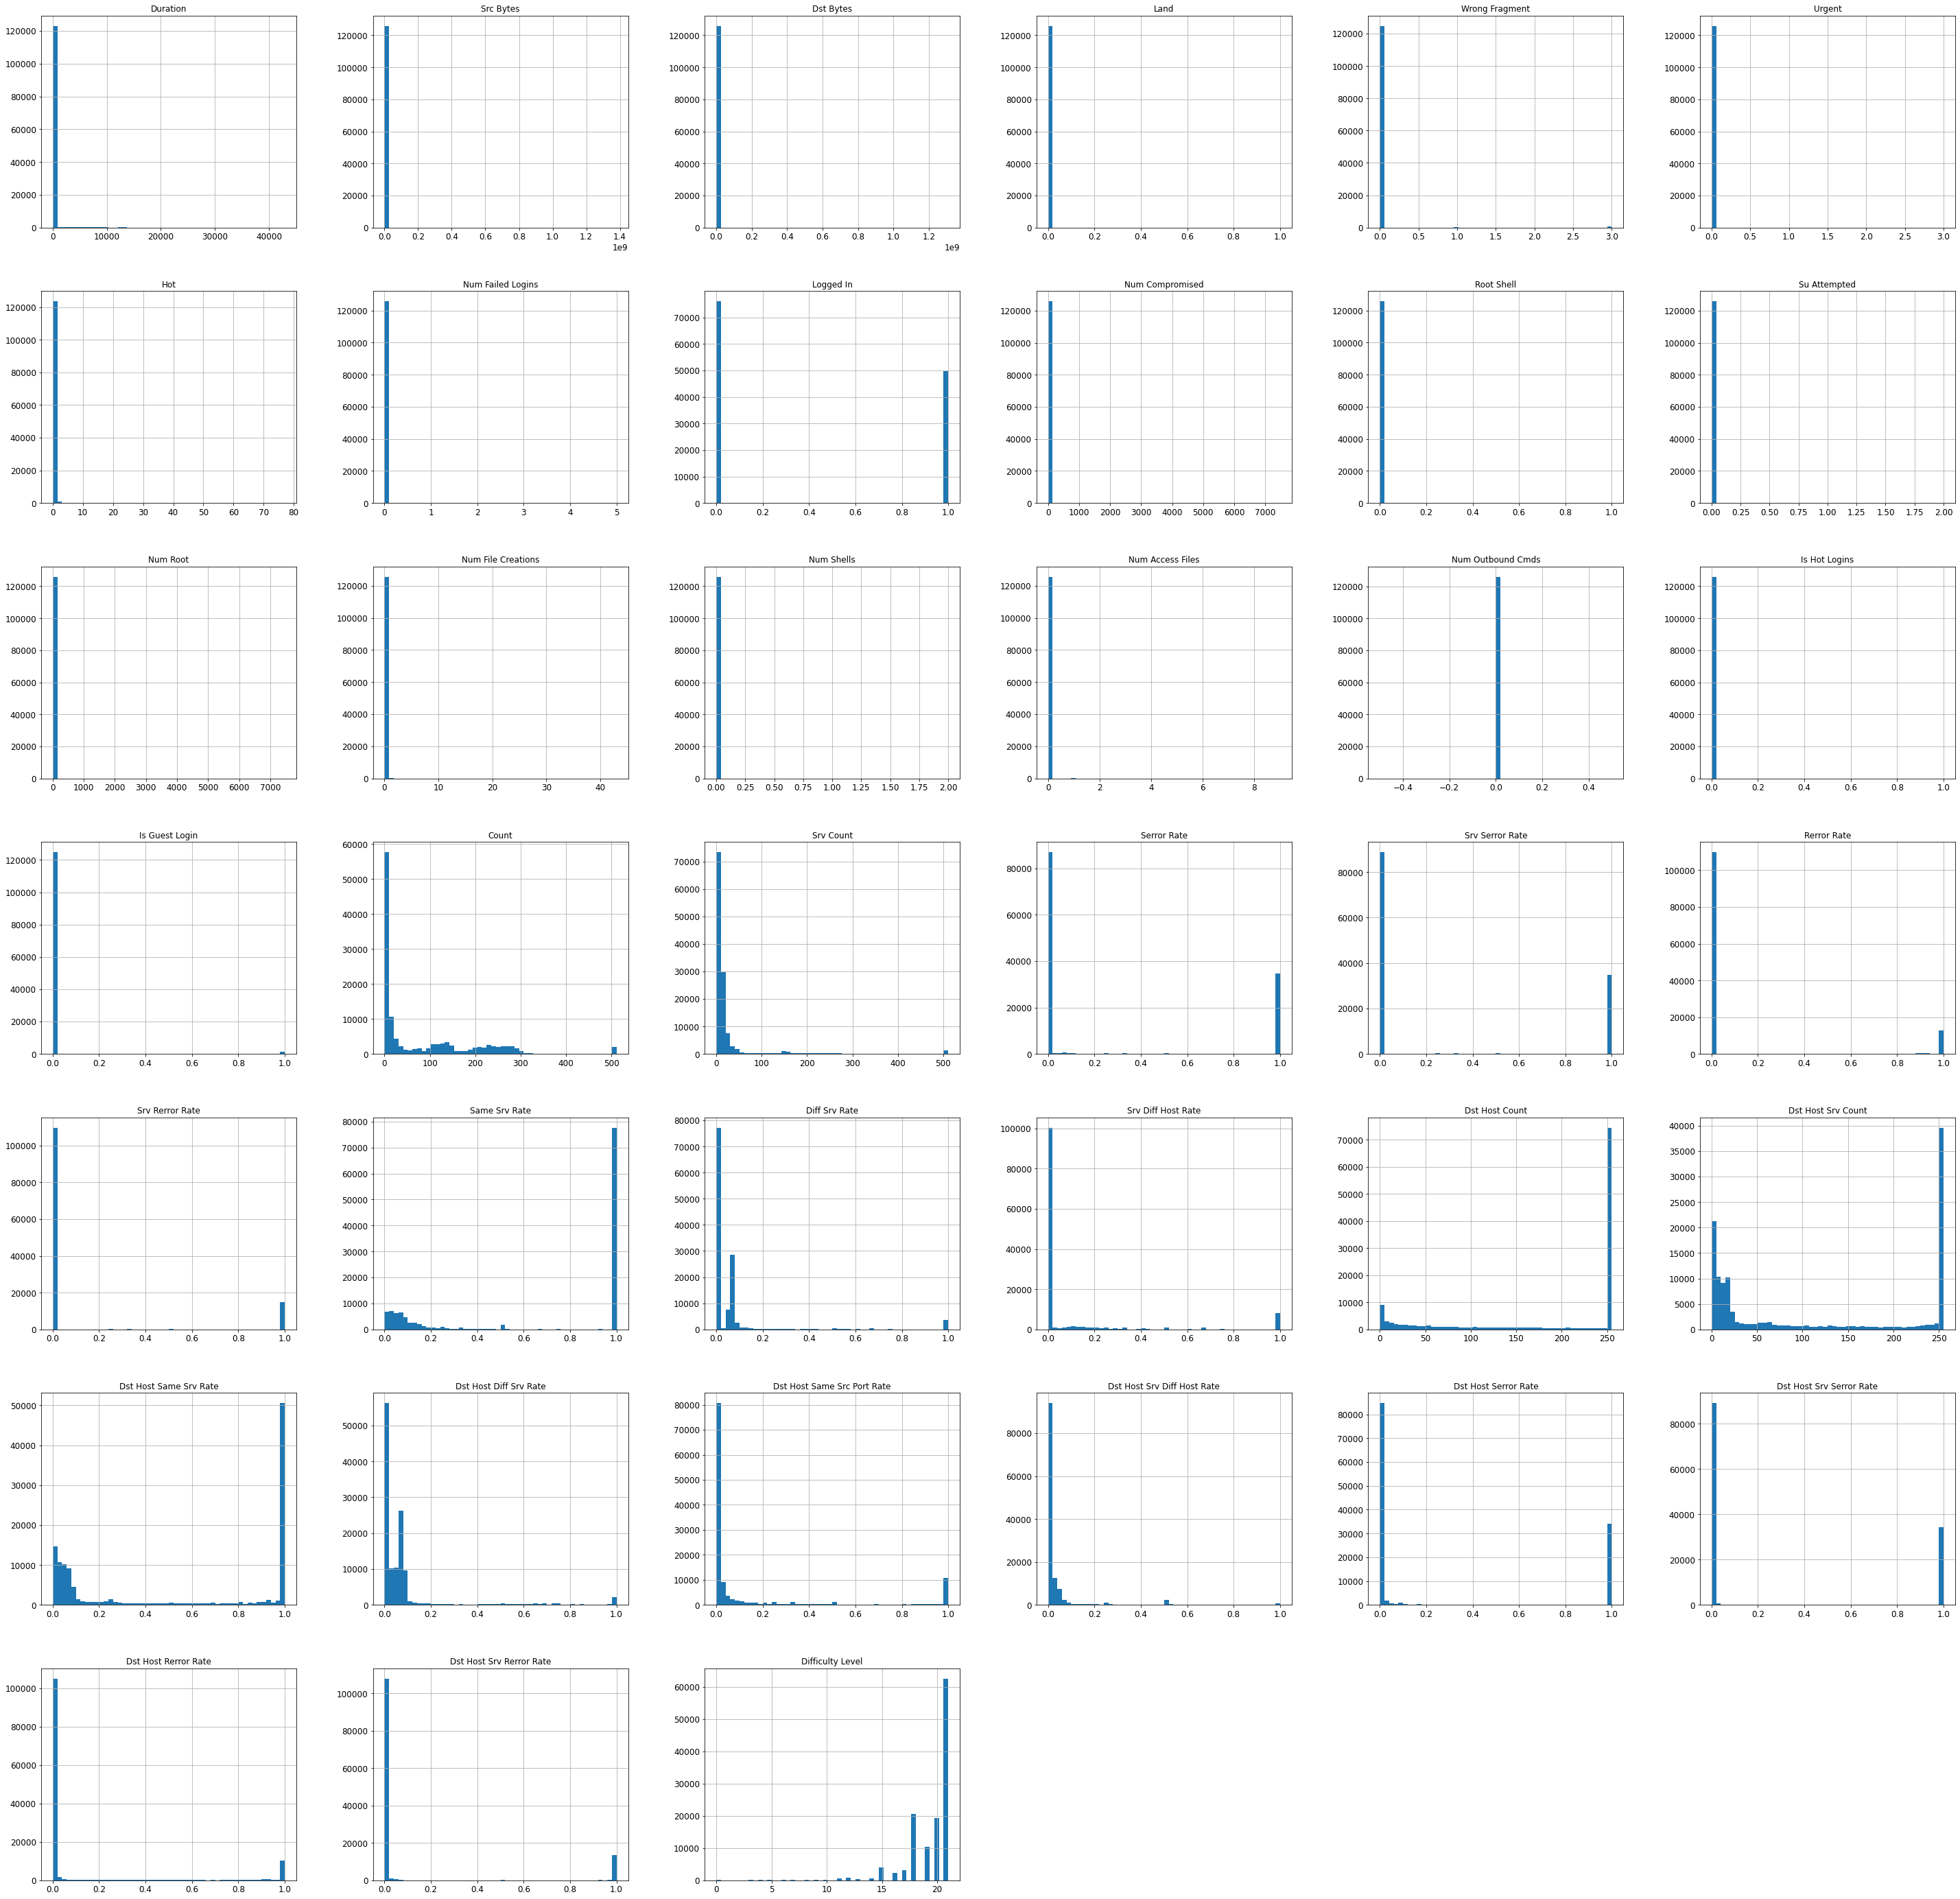

In [10]:
#see the histogram of numerical features
train.hist(bins=50, figsize=(50,50))

<h2> Look deeper into categorical values </h2>
<ul>
    <li> Lot of the protocols seem to be of TCP </li>
    <li> Lot of different kinds of services, most of which are http and private </li>
    <li> Most of the flags are SF: normal establishment and connection </li>
    <li> Quite a number of output classes, most of which are normal connection. Rest of the classes are subcategories of one of the four attack types: DoS, Probe, U2R, R2L </li>
</ul>

<AxesSubplot:>

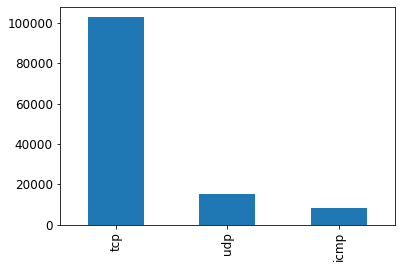

In [11]:
train['Protocol Type'].value_counts().plot(kind = 'bar')

In [12]:
train['Service'].value_counts()

http           40338
private        21853
domain_u        9043
smtp            7313
ftp_data        6860
eco_i           4586
other           4359
ecr_i           3077
telnet          2353
finger          1767
ftp             1754
auth             955
Z39_50           862
uucp             780
courier          734
bgp              710
whois            693
uucp_path        689
iso_tsap         687
time             654
imap4            647
nnsp             630
vmnet            617
urp_i            602
domain           569
ctf              563
csnet_ns         545
supdup           544
discard          538
http_443         530
daytime          521
gopher           518
efs              485
systat           477
link             475
exec             474
hostnames        460
name             451
mtp              439
echo             434
klogin           433
login            429
ldap             410
netbios_dgm      405
sunrpc           381
netbios_ssn      362
netstat          360
netbios_ns   

<AxesSubplot:>

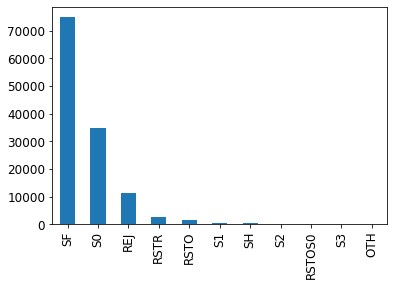

In [13]:
train['Flag'].value_counts().plot(kind = 'bar')

<AxesSubplot:>

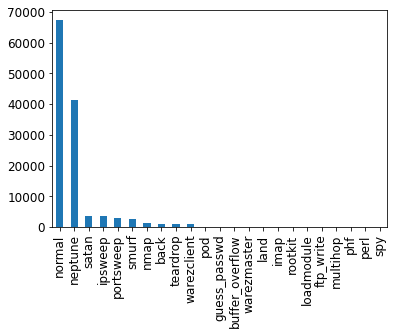

In [14]:
train['Class'].value_counts().plot(kind = 'bar')

<h2> Data Cleaning </h2>
It's time to cleanup some of the attributes. The following steps will be performed:
<ul>
    <li> Grouping together all the sub-categories of attacks in 4 main categoris </li>
    <li> Map the categorical attributes to numerical attributes </li>
    <li> Normalize each attributes except the output label: Class </li>
    <li> Look for correlation of label with all attributes </li>
    </ul>

In [15]:
#just seeing the output labels
#train, test = load_data()
train['Class'].value_counts()

normal             67343
neptune            41214
satan               3633
ipsweep             3599
portsweep           2931
smurf               2646
nmap                1493
back                 956
teardrop             892
warezclient          890
pod                  201
guess_passwd          53
buffer_overflow       30
warezmaster           20
land                  18
imap                  11
rootkit               10
loadmodule             9
ftp_write              8
multihop               7
phf                    4
perl                   3
spy                    2
Name: Class, dtype: int64

In [16]:
#looking for any other kind of attack labels
test['Class'].value_counts()

normal             9711
neptune            4657
guess_passwd       1231
mscan               996
warezmaster         944
apache2             737
satan               735
processtable        685
smurf               665
back                359
snmpguess           331
saint               319
mailbomb            293
snmpgetattack       178
portsweep           157
ipsweep             141
httptunnel          133
nmap                 73
pod                  41
buffer_overflow      20
multihop             18
named                17
ps                   15
sendmail             14
xterm                13
rootkit              13
teardrop             12
xlock                 9
land                  7
xsnoop                4
ftp_write             3
perl                  2
worm                  2
phf                   2
loadmodule            2
udpstorm              2
sqlattack             2
imap                  1
Name: Class, dtype: int64

In [17]:
#all attack sub categories in a dictonary
dict_attacks = { 'normal' : ['normal'], 'DoS' : ['back', 'land', 'neptune', 'pod', 'smurf', 'teardrop', 'mailbomb', 'processtable', 'udpstorm', 'apache2', 'worm']
, 'Probe' : ['ipsweep', 'nmap', 'portsweep', 'satan', 'mscan', 'saint']
, 'U2R' : ['buffer_overflow', 'loadmodule', 'perl', 'rootkit', 'sqlattack', 'xterm', 'ps', 'pst']
, 'R2L' : ['ftp_write', 'guess_passwd', 'imap', 'multihop', 'phf', 'spy', 'warezmaster', 'xlock', 'xsnoop', 'snmpguess', 'snmpgetattack', 'httptunnel', 'sendmail', 'named', 'warezclient']
               }
#map all subcategoris to one of the 5 main categories, using the dict
mapping = {v: k for k, vv in dict_attacks.items() for v in vv}

<AxesSubplot:>

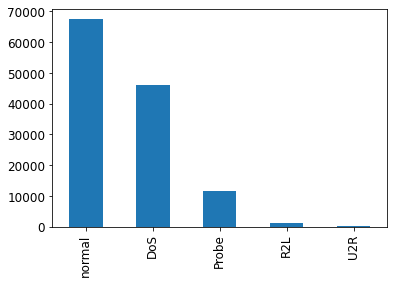

In [18]:
#applying the mapping
train['Class'] = train['Class'].map(mapping)
test['Class'] = test['Class'].map(mapping)
train['Class'].value_counts().plot(kind = 'bar')

In [19]:
#label all the categorical features into numerical ones
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
for column in train.columns:
    if train[column].dtypes == 'object':
        print(column + "===========")
        train[column] = encoder.fit_transform(train[column])
        print(encoder.classes_)
        test[column] = encoder.fit_transform(test[column])
        print(encoder.classes_)

Protocol Type===========
['icmp' 'tcp' 'udp']
['icmp' 'tcp' 'udp']
Service===========
['IRC' 'X11' 'Z39_50' 'aol' 'auth' 'bgp' 'courier' 'csnet_ns' 'ctf'
 'daytime' 'discard' 'domain' 'domain_u' 'echo' 'eco_i' 'ecr_i' 'efs'
 'exec' 'finger' 'ftp' 'ftp_data' 'gopher' 'harvest' 'hostnames' 'http'
 'http_2784' 'http_443' 'http_8001' 'imap4' 'iso_tsap' 'klogin' 'kshell'
 'ldap' 'link' 'login' 'mtp' 'name' 'netbios_dgm' 'netbios_ns'
 'netbios_ssn' 'netstat' 'nnsp' 'nntp' 'ntp_u' 'other' 'pm_dump' 'pop_2'
 'pop_3' 'printer' 'private' 'red_i' 'remote_job' 'rje' 'shell' 'smtp'
 'sql_net' 'ssh' 'sunrpc' 'supdup' 'systat' 'telnet' 'tftp_u' 'tim_i'
 'time' 'urh_i' 'urp_i' 'uucp' 'uucp_path' 'vmnet' 'whois']
['IRC' 'X11' 'Z39_50' 'auth' 'bgp' 'courier' 'csnet_ns' 'ctf' 'daytime'
 'discard' 'domain' 'domain_u' 'echo' 'eco_i' 'ecr_i' 'efs' 'exec'
 'finger' 'ftp' 'ftp_data' 'gopher' 'hostnames' 'http' 'http_443' 'imap4'
 'iso_tsap' 'klogin' 'kshell' 'ldap' 'link' 'login' 'mtp' 'name'
 'netbios_dgm' '

This normalization method will be used right before training the data (original and generated, both).

In [20]:
#normalizing the data
from sklearn.preprocessing import MinMaxScaler

def normalize(train, test):
    train_max = train.loc[:, train.columns != 'Class']
    test_max = test.loc[:, test.columns != 'Class']
    Y_train = train.loc[:, train.columns == 'Class']
    Y_test = test.loc[:, test.columns == 'Class']
    scaler = MinMaxScaler()
    train_p = scaler.fit_transform(train_max)#.loc[:, train.columns!='Class'])
    train_p = DataFrame(train_p)
    train_p.columns = train_max.columns.values
    test_p = scaler.fit_transform(test_max)#.loc[:, test.columns!='Class'])
    test_p = DataFrame(test_p)
    test_p.columns = test_max.columns.values
    
    return train_p, Y_train, test_p, Y_test

In [21]:
def normalize_gan(train):
    #train_max = train.loc[:, train.columns != 'Class']
    #Y_train = train.loc[:, train.columns == 'Class']
    scaler = MinMaxScaler()
    train_p = scaler.fit_transform(train)#.loc[:, train.columns!='Class'])
    train_p = DataFrame(train_p)
    #train_new = pd.concat([train_p, Y_train], axis=1)#, ignore_index = True)
    train_p.columns = train.columns.values
    #last two columns switched after the concatenation
    #train_new = train_new.rename(columns = {'Class': 'Difficulty Level', 'Difficulty Level' : 'Class'}, inplace = True)
    return train_p

In [22]:
#converting them back to dataframes, because they became array after going throug the labelencoder
from pandas import DataFrame

train = DataFrame(train)
train = rename_column(train)
#train = train.rename({train.columns[-1] : 'Difficulty Level'}, axis = 1)
test = DataFrame(test)
test = rename_column(test)
#test = test.rename({test.columns[-1] : 'Difficulty Level'}, axis = 1)

In [23]:
#Keeping original copies, just in case
train_original = train.copy()
test_original = test.copy()

<AxesSubplot:title={'center':'Pearson Correlation'}>

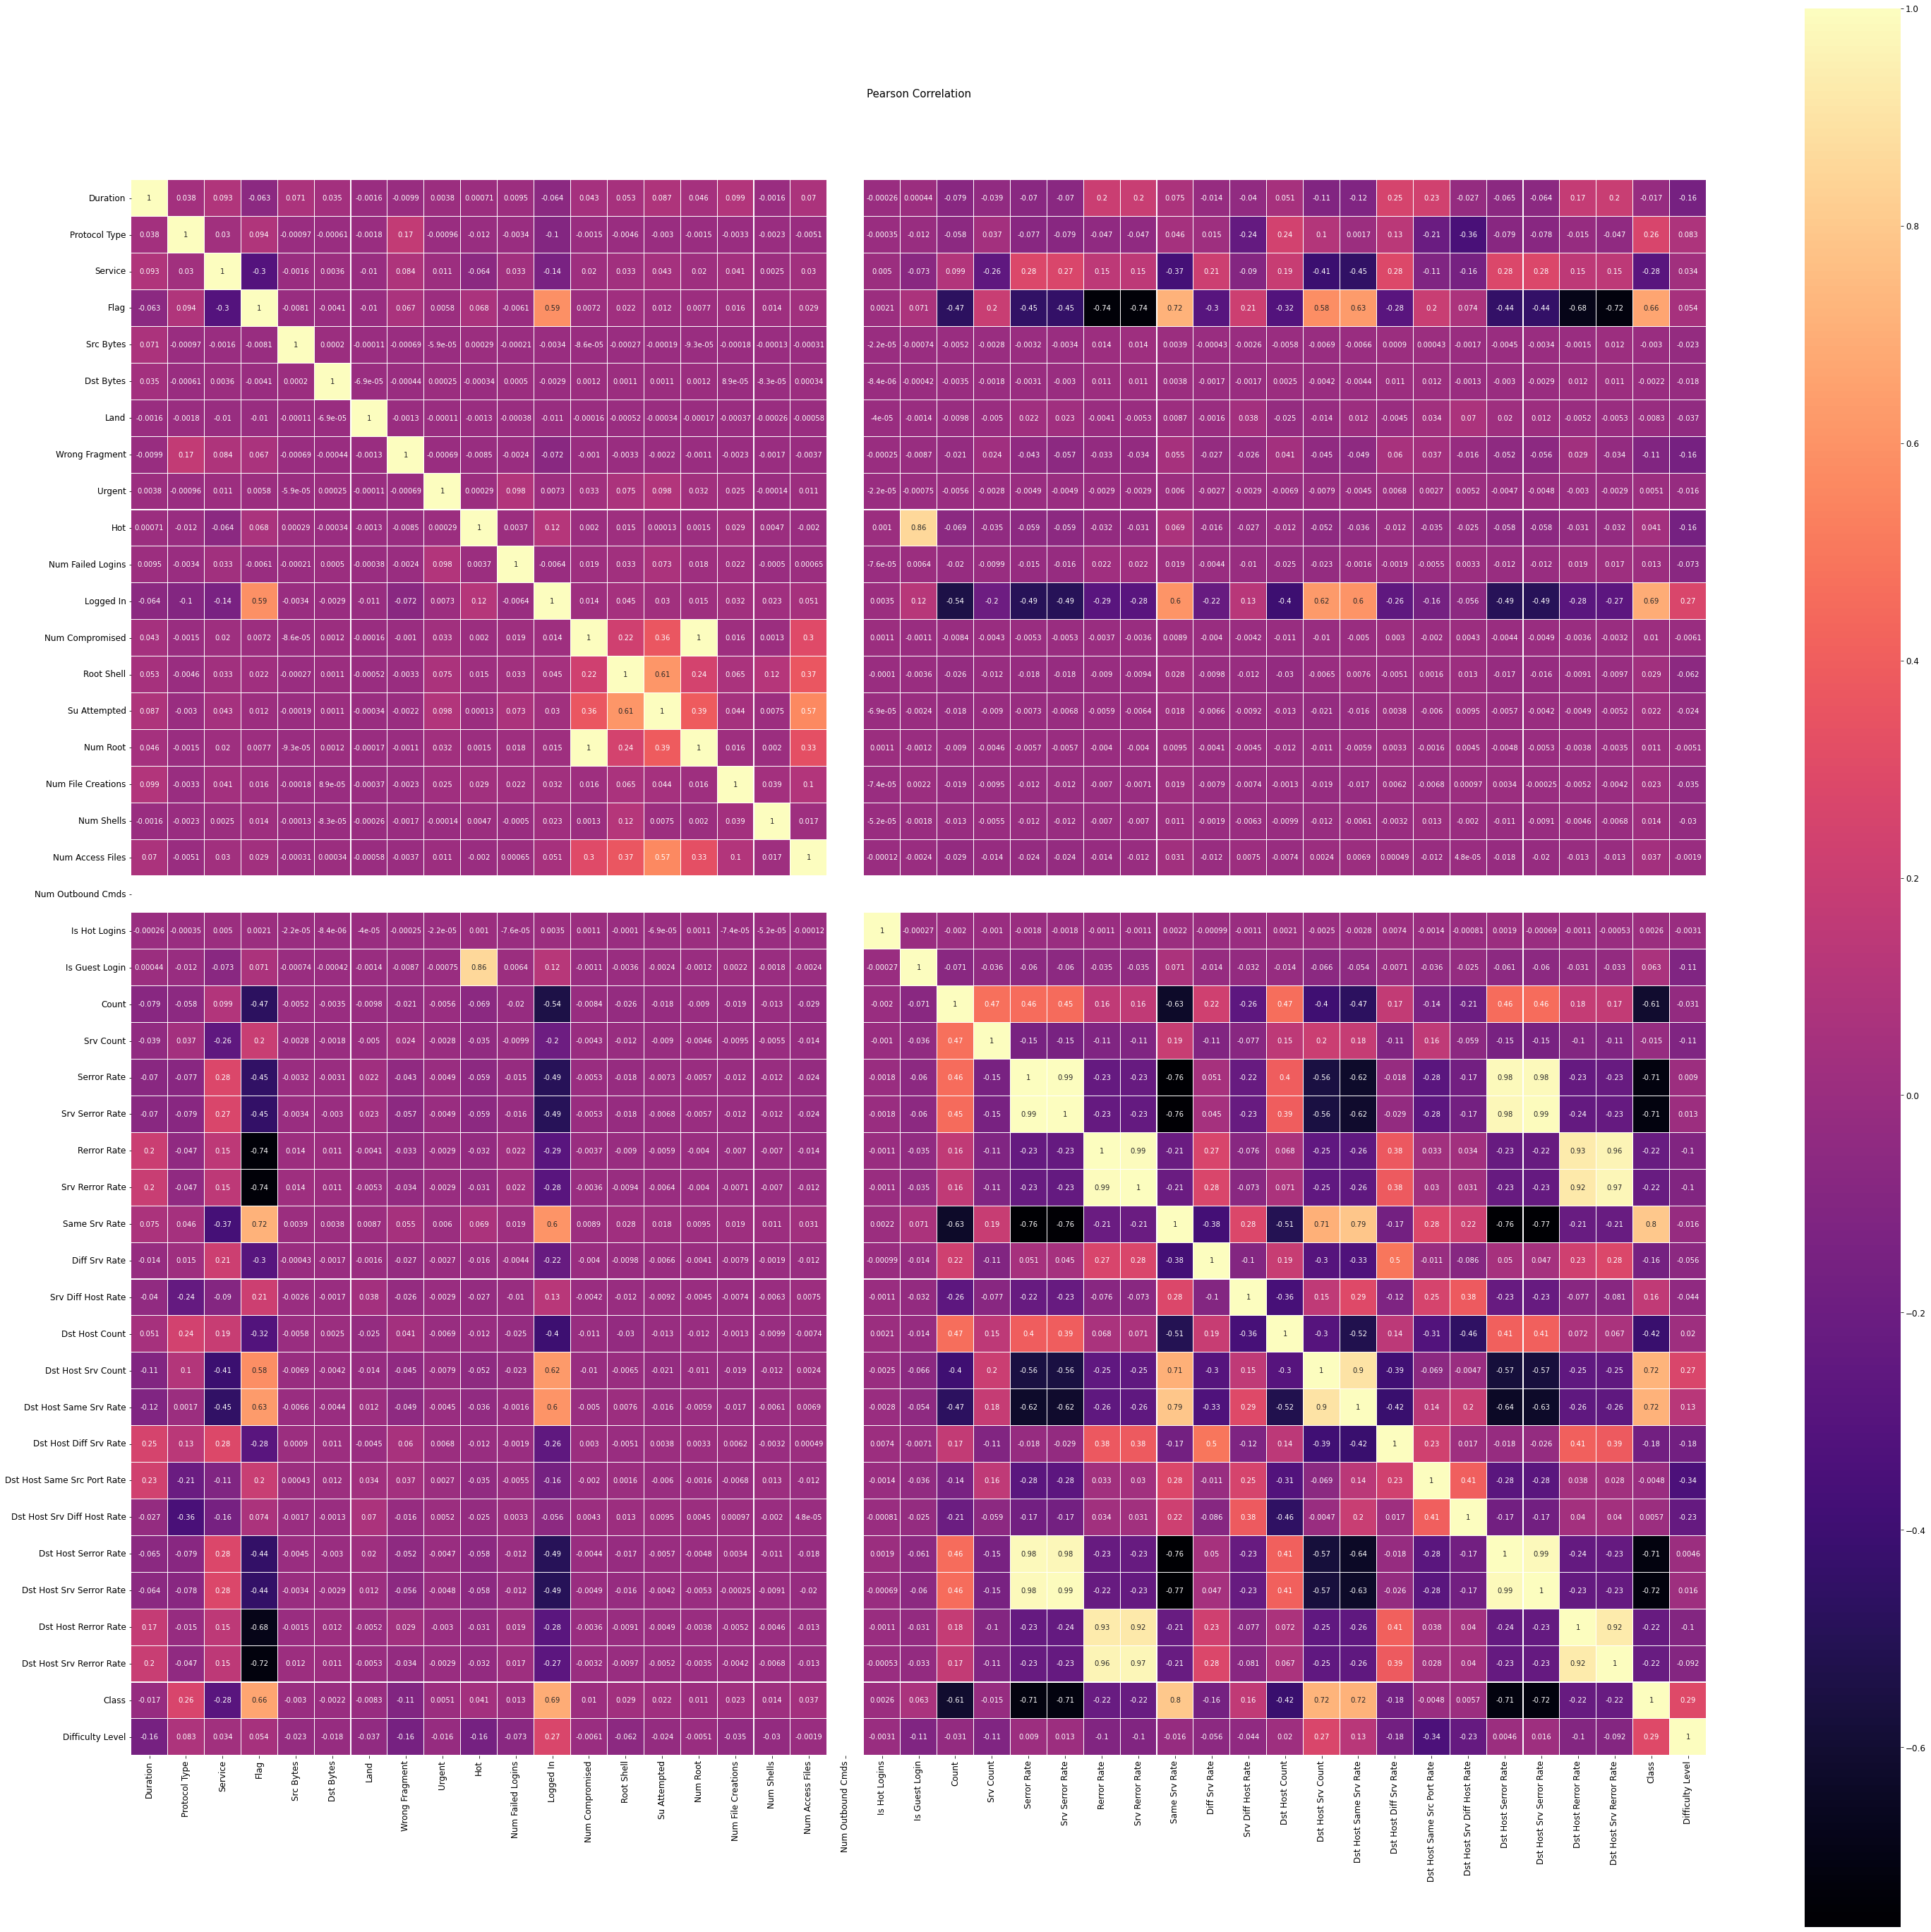

In [24]:
#Display the correlations among the features
import seaborn as sns
colormap = plt.cm.magma
plt.figure(figsize=(50,50))
plt.title('Pearson Correlation', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

In [25]:
#examining this feature a bit, this has NaN correlation with the label
#this feature seem to have all zeros, we can drop it
train['Num Outbound Cmds'].value_counts()
train = train.drop('Num Outbound Cmds', 1)
test = test.drop('Num Outbound Cmds', 1)

<AxesSubplot:title={'center':'Pearson Correlation'}>

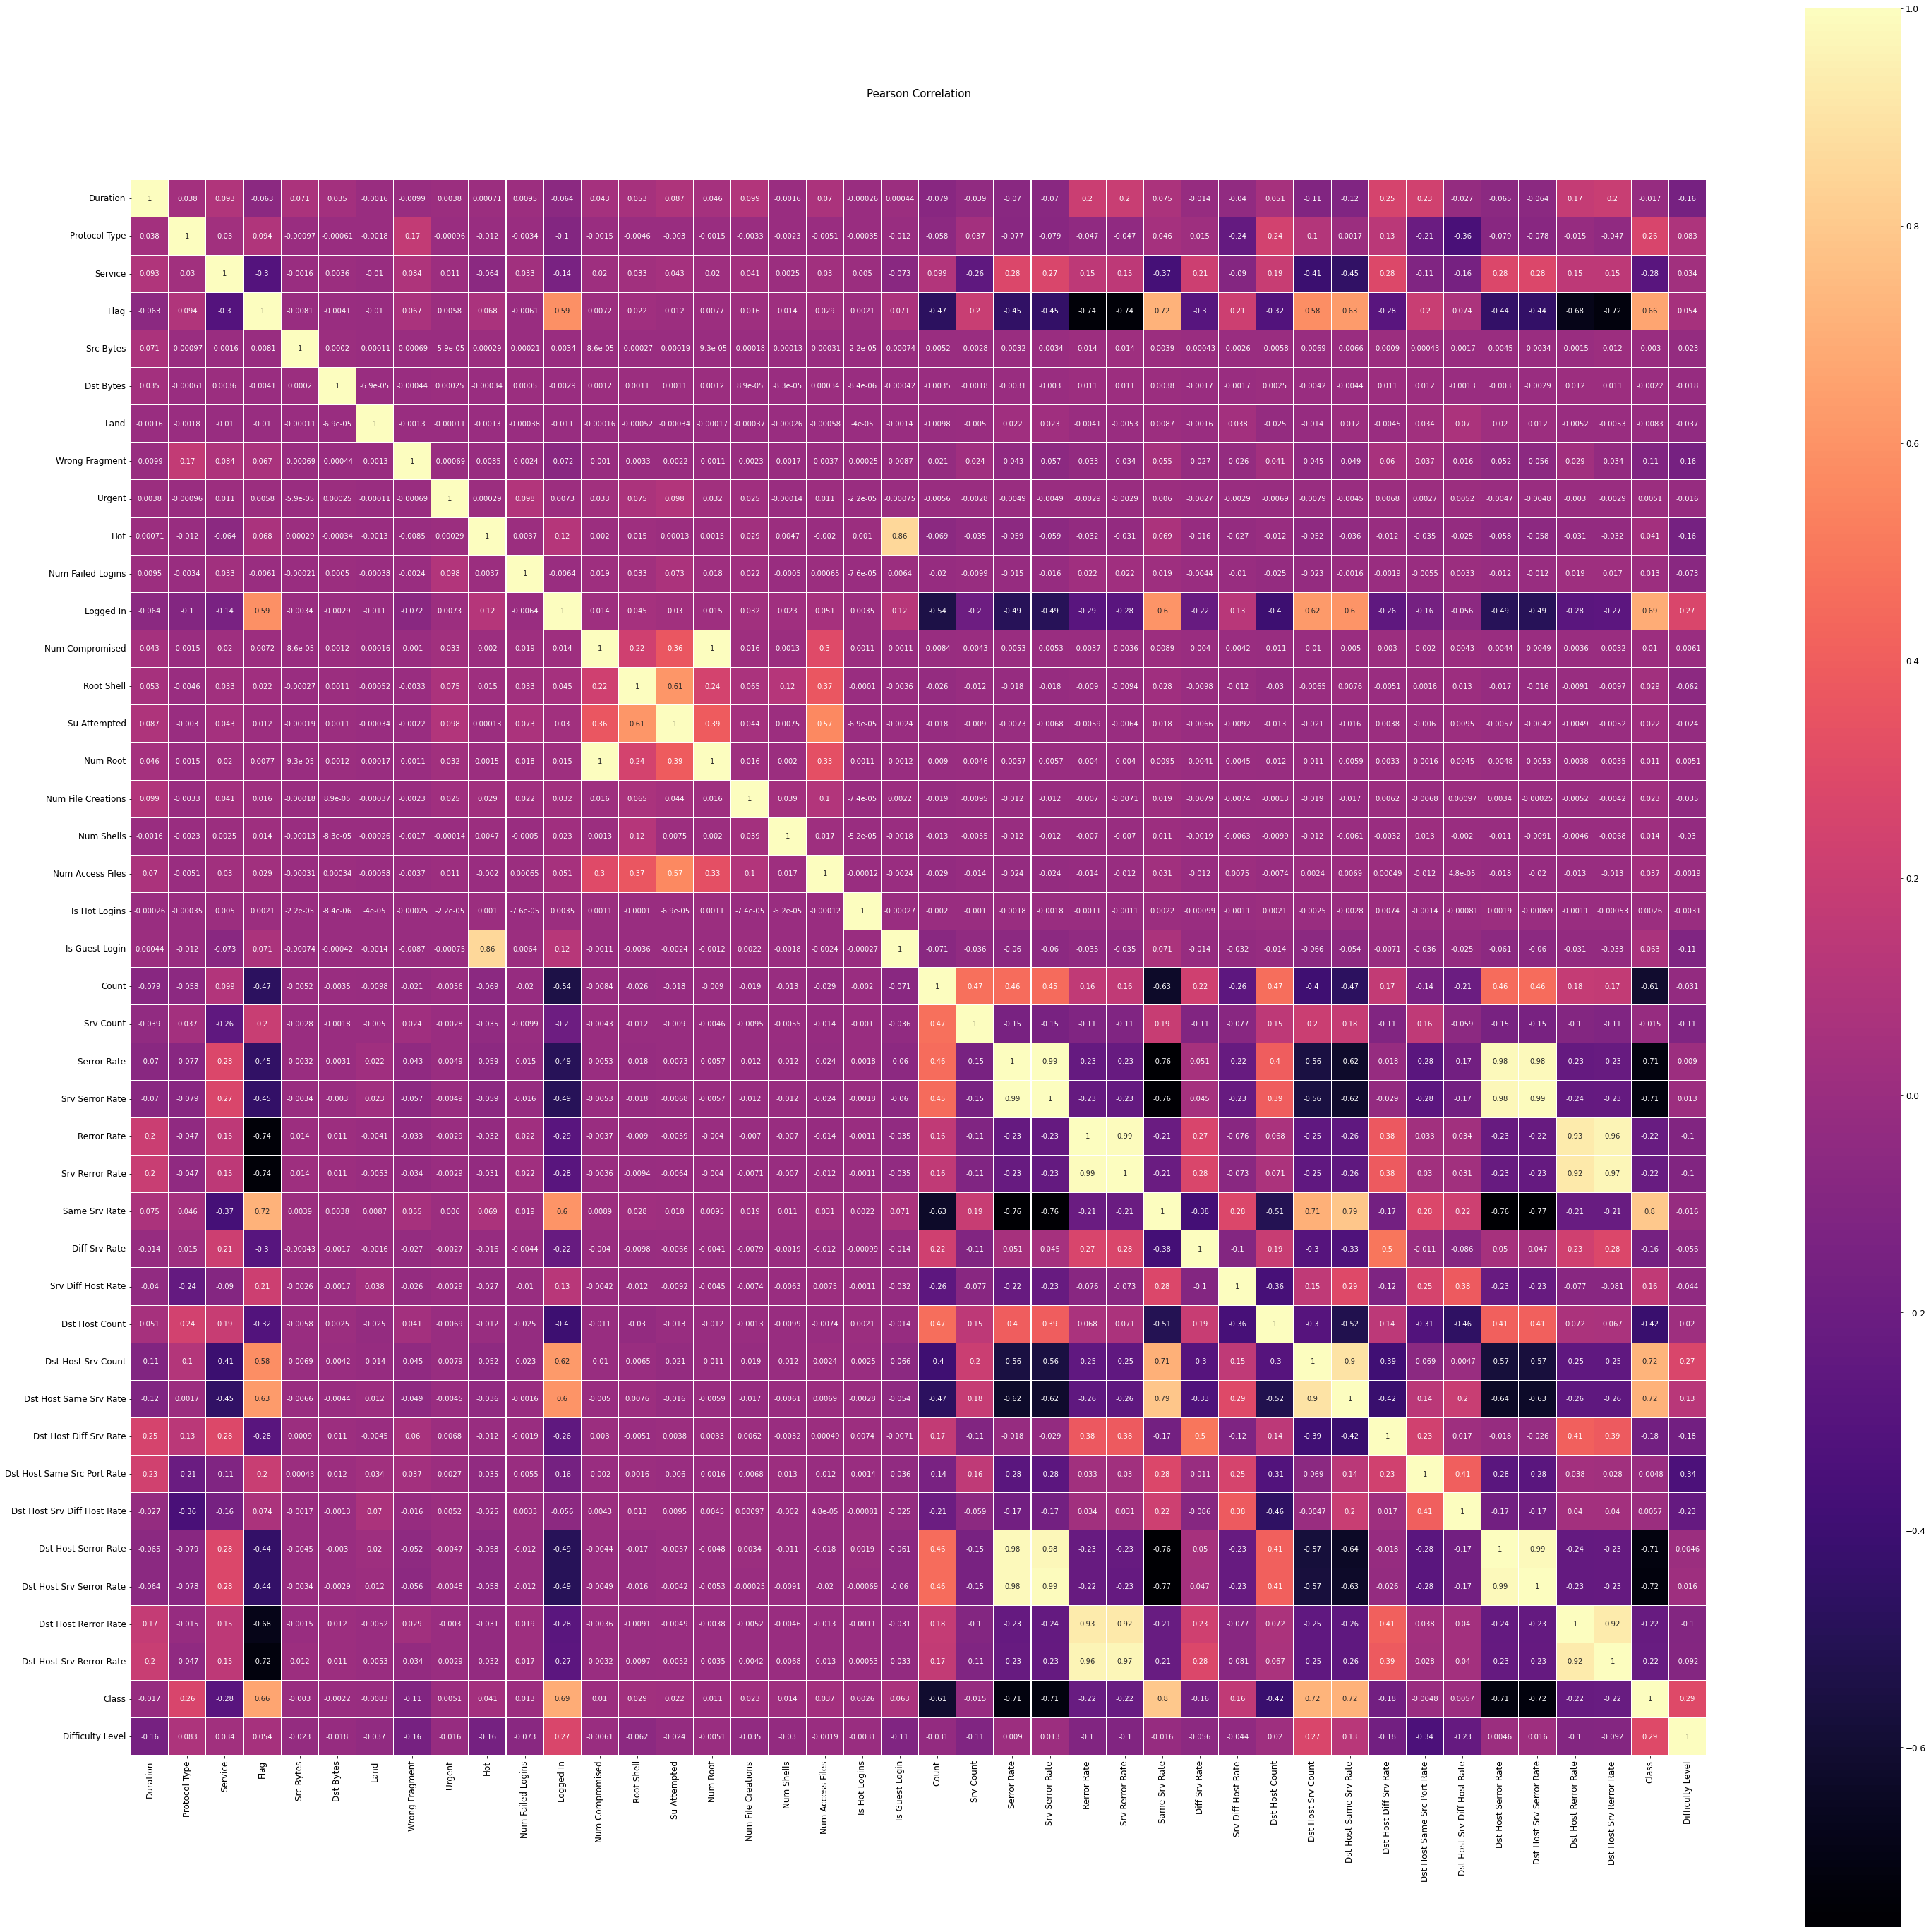

In [26]:
#Display the correlations among the features, after dropping the Num Outbound Cmds
colormap = plt.cm.magma
plt.figure(figsize=(50,50))
plt.title('Pearson Correlation', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

<h3> We can notice, there are many features having very little impact on out traget, class. So, we will remove the features having less than 0.2 absolute correlation with class.</h3>

In [27]:
#looking for correlation of the label 'Class' with other features
cor = train.corr()['Class'][:].abs()
cor = DataFrame(cor)
#list of columns to be dropped
to_drop = cor[cor['Class'] < 0.2].index
print(to_drop)

Index(['Duration', 'Src Bytes', 'Dst Bytes', 'Land', 'Wrong Fragment',
       'Urgent', 'Hot', 'Num Failed Logins', 'Num Compromised', 'Root Shell',
       'Su Attempted', 'Num Root', 'Num File Creations', 'Num Shells',
       'Num Access Files', 'Is Hot Logins', 'Is Guest Login', 'Srv Count',
       'Diff Srv Rate', 'Srv Diff Host Rate', 'Dst Host Diff Srv Rate',
       'Dst Host Same Src Port Rate', 'Dst Host Srv Diff Host Rate'],
      dtype='object')


In [28]:
#dropping the above columns from both training and test dataset
train = train.drop(to_drop, 1)
test = test.drop(to_drop, 1)

<AxesSubplot:title={'center':'Pearson Correlation'}>

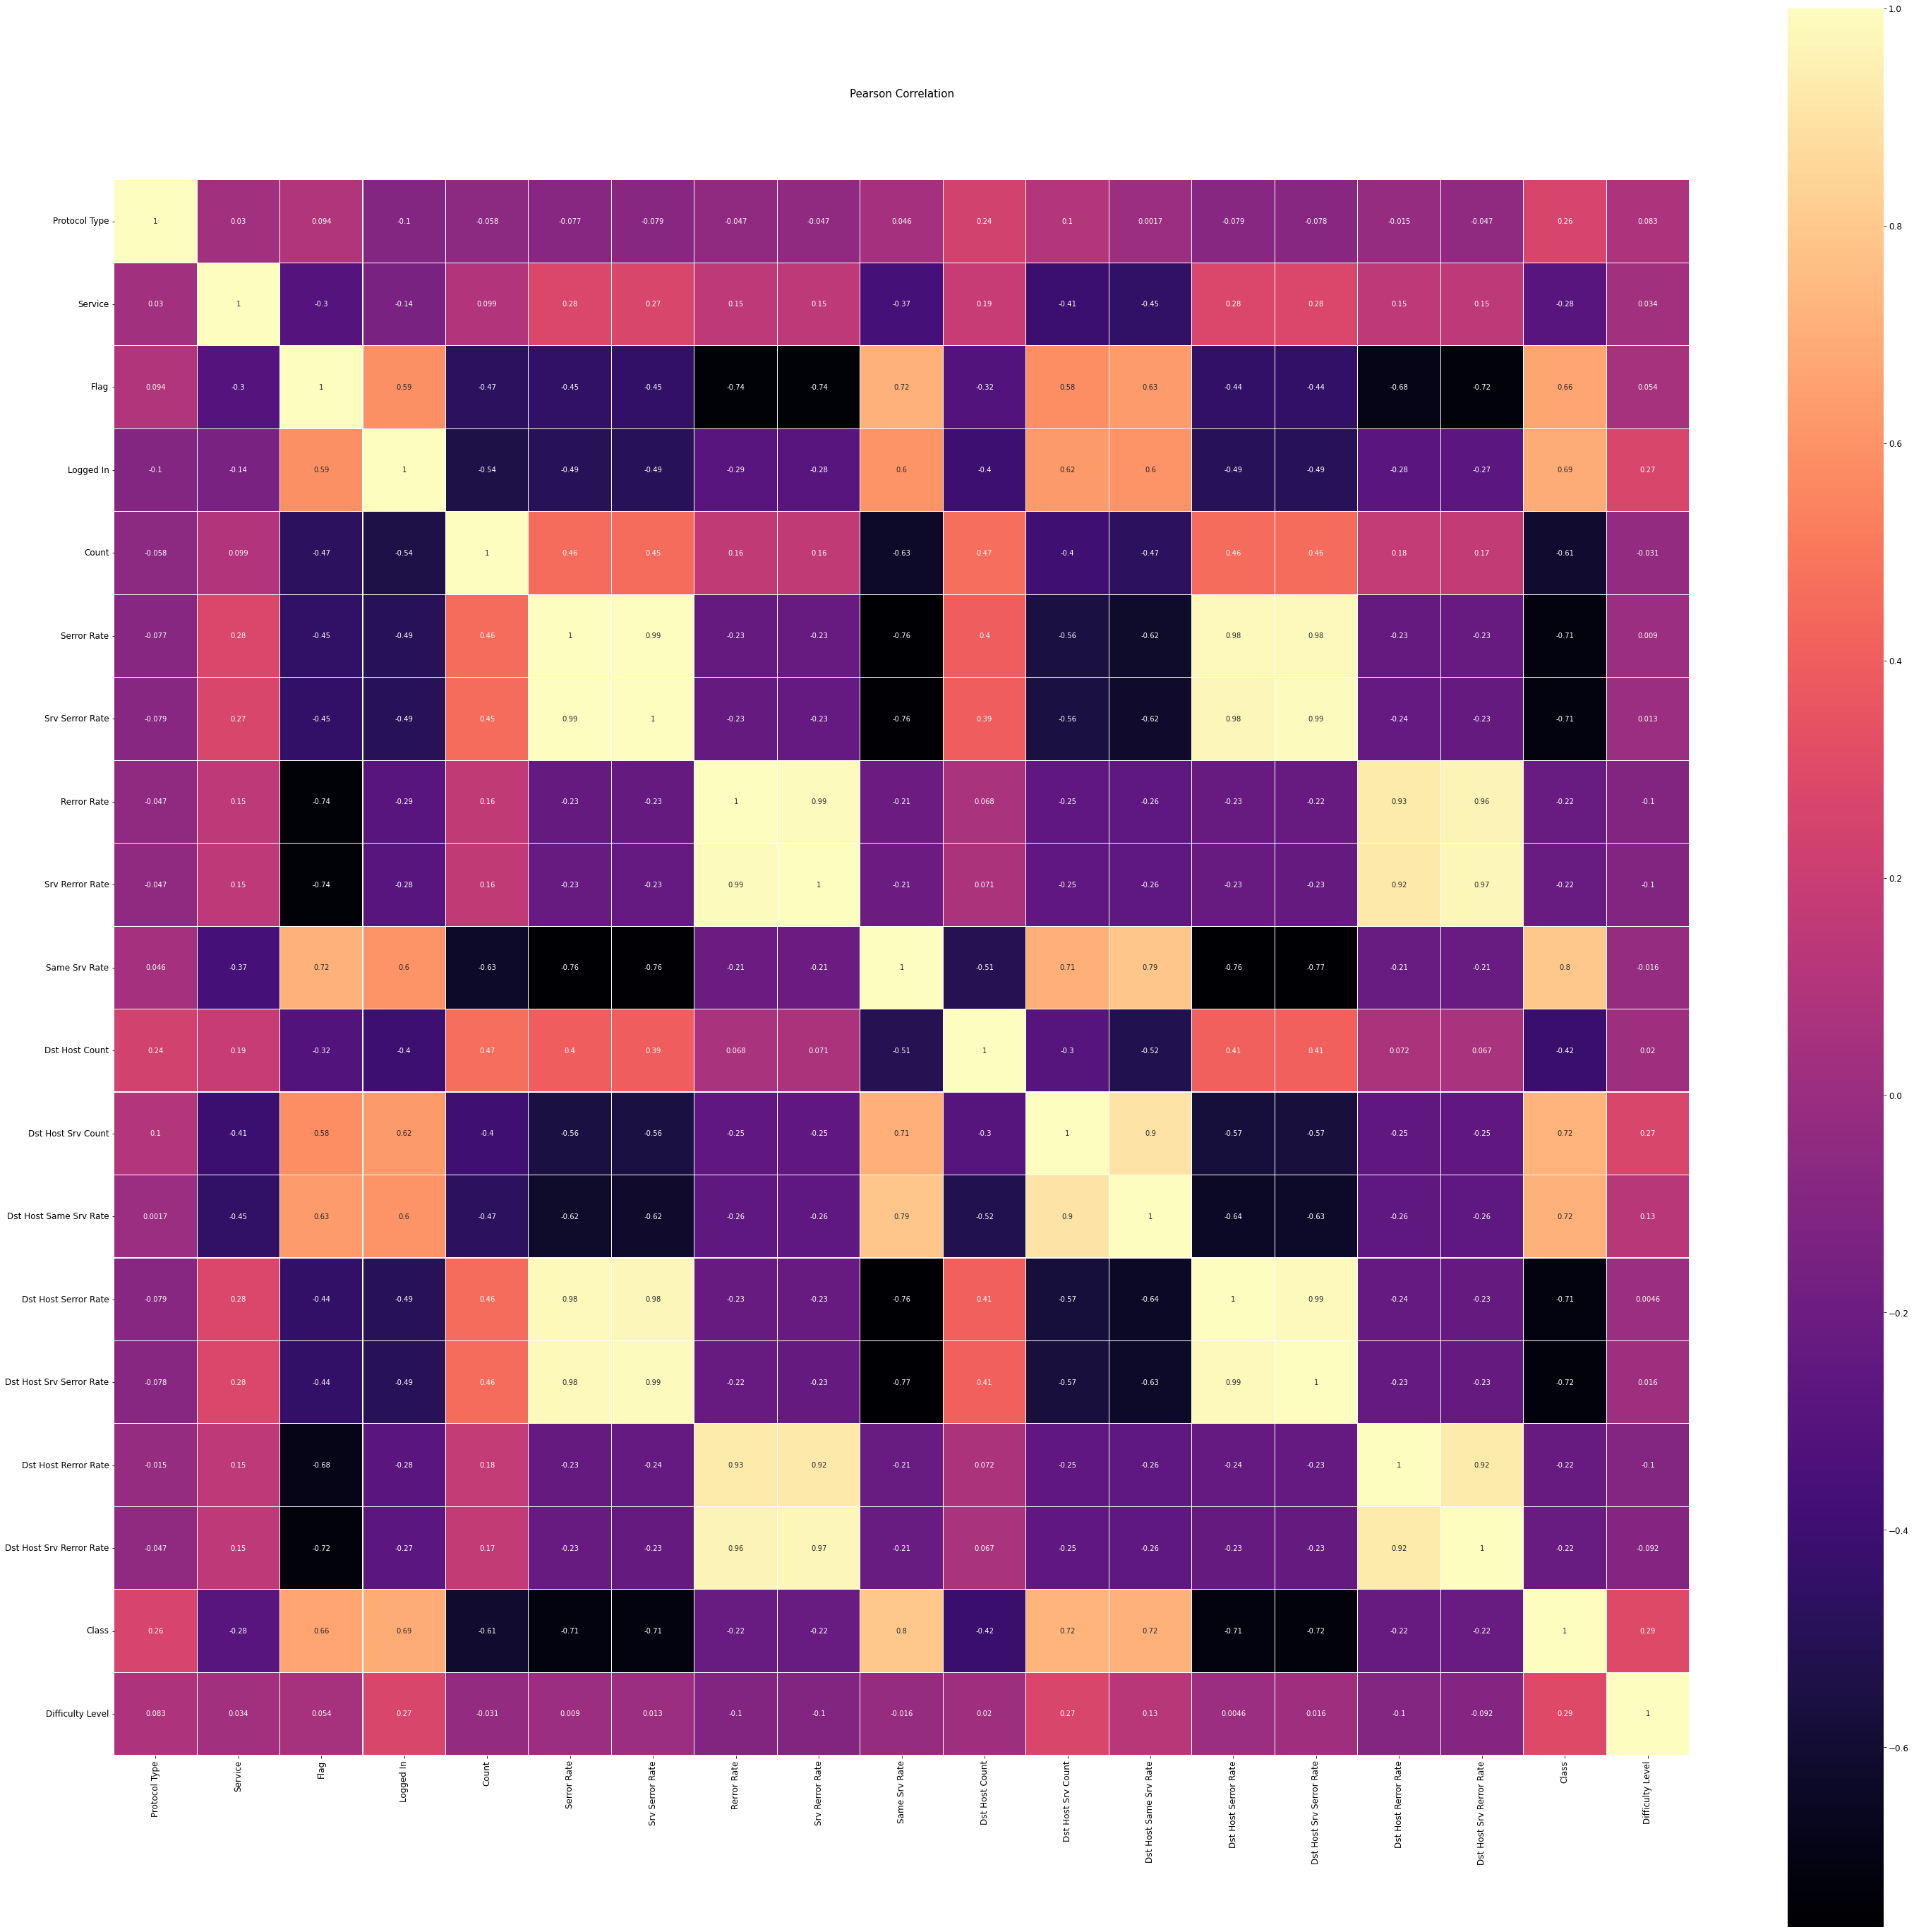

In [29]:
#Display the correlations among the features, after dropping unnecessary columns
colormap = plt.cm.magma
plt.figure(figsize=(50,50))
plt.title('Pearson Correlation', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

In [30]:
#keepking a copy, after removing the unnecessary columns
train_c = train.copy()
test_c = test.copy()

In [31]:
#conda install -c glemaitre imbalanced-learn

In [32]:
#pip install scikit-learn==0.22.1

In [33]:
#pip install -U imbalanced-learn

<h3> Under sampling some classes with majority amount of samples. This can potentially make the task of GAN easier by giving a less complex, less biased distribution to solve. </h3>

In [34]:
from imblearn.under_sampling import RandomUnderSampler

In [35]:
#all data with DoS and normal, the majority classes, taken to undersample
#train_2 = train.loc[(train['Class'] == 0) | (train['Class'] == 1)]
#train_2 = train.loc[(train['Class'] == 0) | (train['Class'] == 4)]
#remove data of DoS and normal from the main training set
#train_rare = train.loc[(train['Class'] != 0) & (train['Class'] != 1)]
#train_rare = train.loc[(train['Class'] != 0) & (train['Class'] != 4)]

In [36]:
#for the undersampleing library to work, we need to feed the features and labels separately
train_x = train.loc[:, train.columns != 'Class']
train_y = train.loc[:, train.columns == 'Class']

In [37]:
#undersampler to get equal amount of DoS and normal data
undersample = RandomUnderSampler(sampling_strategy={0: 15000, 4: 20000}, random_state = 0)
# fit and apply the transform
train_x, train_y = undersample.fit_resample(train_x, train_y)

In [38]:
#train_x = train_rare.loc[:, train_rare.columns != 'Class']
#train_y = train_rare.loc[:, train_rare.columns == 'Class']

In [39]:
#train_new_x = pd.concat([train_2_x, train_x], ignore_index = True)
#train_new_y = pd.concat([train_2_y, train_y], ignore_index = True)

<AxesSubplot:title={'center':'Pearson Correlation'}>

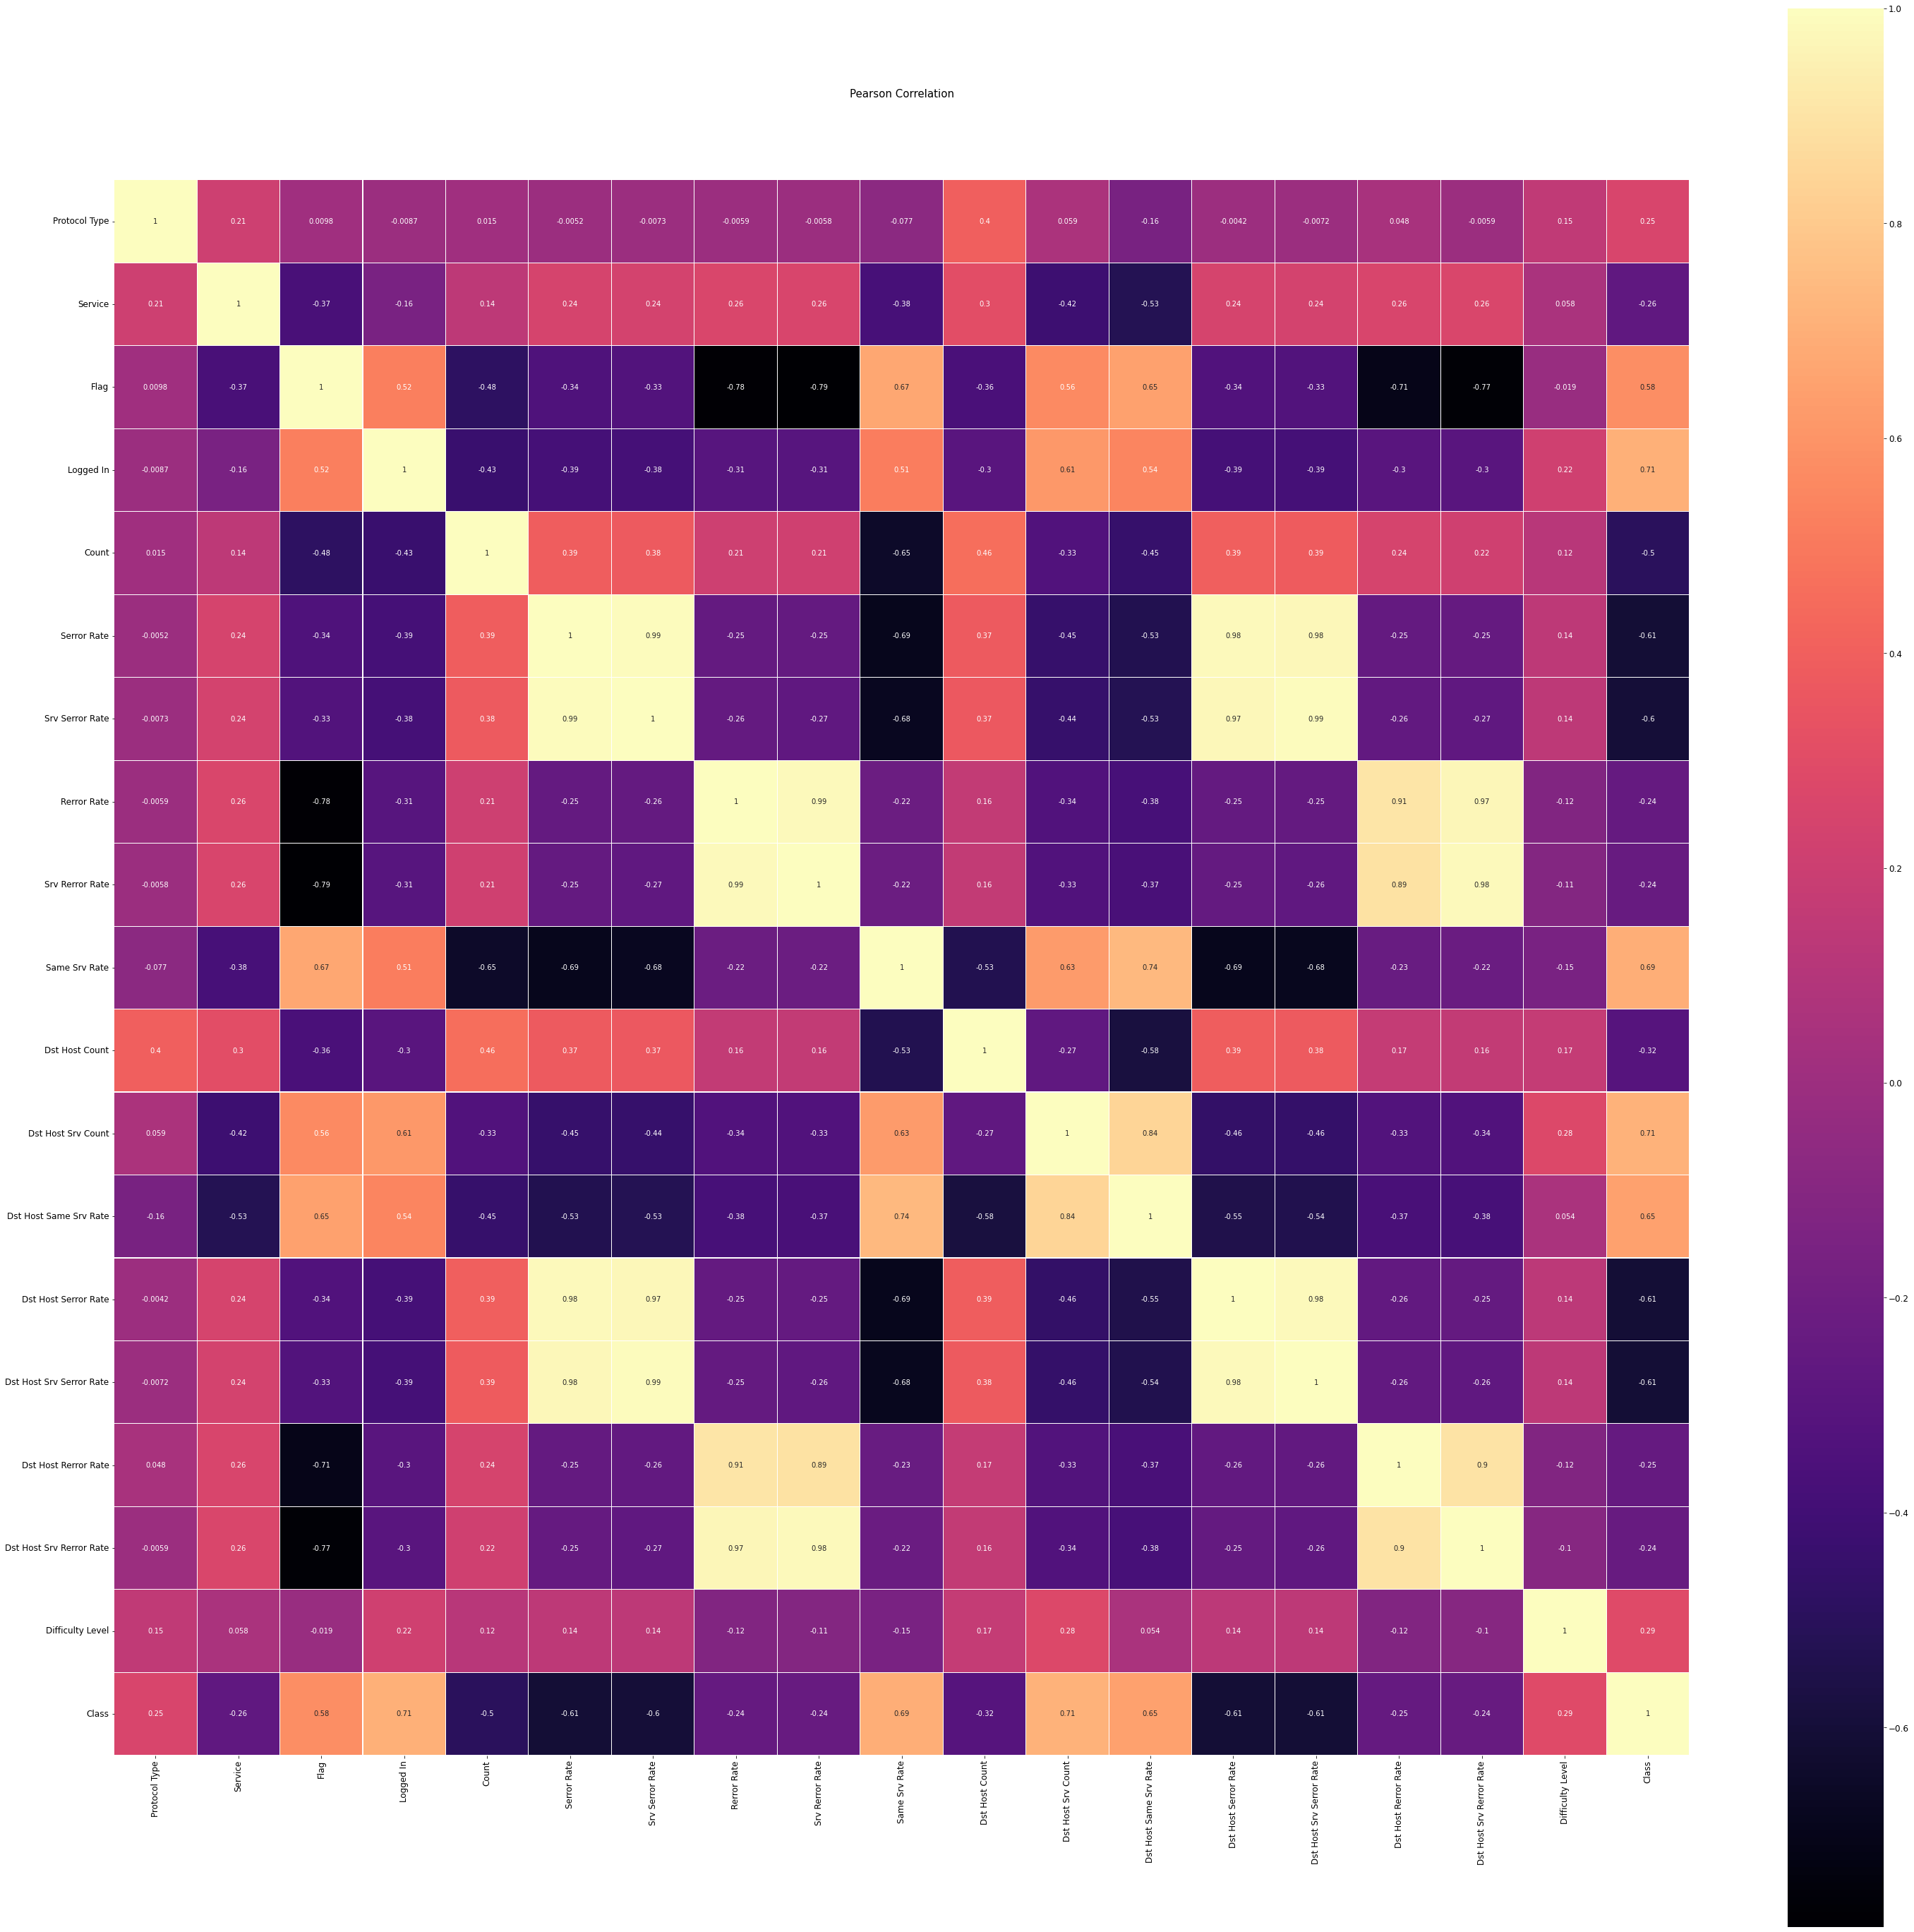

In [40]:
#new dataframe with the under sampled features and labels, going to use this to train the GAN
train_new = pd.concat([train_x, train_y], axis=1)#, ignore_index = True)
train_new.columns = train.columns.values
#last two columns switched after the concatenation
train_new.rename(columns = {'Class': 'Difficulty Level', 'Difficulty Level' : 'Class'}, inplace = True)
#Display the correlations among the features, after dropping unnecessary columns
colormap = plt.cm.magma
plt.figure(figsize=(50,50))
plt.title('Pearson Correlation', y=1.05, size=15)
sns.heatmap(train_new.astype(float).corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

In [41]:
train_new.head(5)

,Protocol Type,Service,Flag,Logged In,Count,Serror Rate,Srv Serror Rate,Rerror Rate,Srv Rerror Rate,Same Srv Rate,Dst Host Count,Dst Host Srv Count,Dst Host Same Srv Rate,Dst Host Serror Rate,Dst Host Srv Serror Rate,Dst Host Rerror Rate,Dst Host Srv Rerror Rate,Difficulty Level,Class
0,1,69,5,0,147,1.0,1.0,0.0,0.0,0.05,255,4,0.02,1.00,1.00,0.00,0.00,18,0
1,1,29,5,0,193,1.0,1.0,0.0,0.0,0.06,255,12,0.05,1.00,1.00,0.00,0.00,18,0
2,1,24,9,1,4,0.0,0.0,0.0,0.0,1.00,99,99,1.00,0.00,0.00,0.15,0.15,11,0
3,1,54,5,0,6,1.0,1.0,0.0,0.0,1.00,68,136,0.38,0.97,0.19,0.00,0.00,14,0
4,1,49,5,0,287,1.0,1.0,0.0,0.0,0.06,255,18,0.07,1.00,1.00,0.00,0.00,21,0


In [42]:
#just taking a look at the numbers to to be sure about the imbalnce function
train_new['Class'].value_counts(dropna = False)

4    20000
0    15000
1    11656
2      995
3       52
Name: Class, dtype: int64

<h1> GAN model: Definition </h1>

In [43]:
import os
import numpy as np

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras import Model

from tensorflow.keras.optimizers import Adam

class GAN():
    
    def __init__(self, gan_args):
        [self.batch_size, lr, self.noise_dim,
         self.data_dim, layers_dim] = gan_args

        self.generator = Generator(self.batch_size).\
            build_model(input_shape=(self.noise_dim,), dim=layers_dim, data_dim=self.data_dim)

        self.discriminator = Discriminator(self.batch_size).\
            build_model(input_shape=(self.data_dim,), dim=layers_dim)

        optimizer = Adam(lr, 0.5)

        # Build and compile the discriminator
        self.discriminator.compile(loss='binary_crossentropy',
                                   optimizer=optimizer,
                                   metrics=['accuracy'])

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.noise_dim,))
        record = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        validity = self.discriminator(record)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    def get_data_batch(self, train, batch_size, seed=0):
        # # random sampling - some samples will have excessively low or high sampling, but easy to implement
        # np.random.seed(seed)
        # x = train.loc[ np.random.choice(train.index, batch_size) ].values
        # iterate through shuffled indices, so every sample gets covered evenly

        start_i = (batch_size * seed) % len(train)
        stop_i = start_i + batch_size
        shuffle_seed = (batch_size * seed) // len(train)
        np.random.seed(shuffle_seed)
        train_ix = np.random.choice(list(train.index), replace=False, size=len(train))  # wasteful to shuffle every time
        train_ix = list(train_ix) + list(train_ix)  # duplicate to cover ranges past the end of the set
        x = train.loc[train_ix[start_i: stop_i]].values
        return np.reshape(x, (batch_size, -1))
        
    def train(self, data, train_arguments):
        [cache_prefix, epochs, sample_interval] = train_arguments
        
        data_cols = data.columns

        # Adversarial ground truths
        valid = np.ones((self.batch_size, 1))
        fake = np.zeros((self.batch_size, 1))

        for epoch in range(epochs):    
            # ---------------------
            #  Train Discriminator
            # ---------------------
            batch_data = self.get_data_batch(data, self.batch_size)
            noise = tf.random.normal((self.batch_size, self.noise_dim))

            # Generate a batch of new images
            gen_data = self.generator.predict(noise)
    
            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(batch_data, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_data, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    
            # ---------------------
            #  Train Generator
            # ---------------------
            noise = tf.random.normal((self.batch_size, self.noise_dim))
            # Train the generator (to have the discriminator label samples as valid)
            g_loss = self.combined.train_on_batch(noise, valid)
    
            # Plot the progress
            print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100 * d_loss[1], g_loss))
    
            # If at save interval => save generated events
            if epoch % sample_interval == 0:
                #Test here data generation step
                # save model checkpoints
                model_checkpoint_base_name = 'model/' + cache_prefix + '_{}_model_weights_step_{}.h5'
                self.generator.save_weights(model_checkpoint_base_name.format('generator', epoch))
                self.discriminator.save_weights(model_checkpoint_base_name.format('discriminator', epoch))

                #Here is generating the data
                z = tf.random.normal((432, self.noise_dim))
                gen_data = self.generator(z)
                print('generated_data')

    def save(self, path, name):
        assert os.path.isdir(path) == True, \
            "Please provide a valid path. Path must be a directory."
        model_path = os.path.join(path, name)
        self.generator.save_weights(model_path)  # Load the generator
        return
    
    def load(self, path):
        assert os.path.isdir(path) == True, \
            "Please provide a valid path. Path must be a directory."
        self.generator = Generator(self.batch_size)
        self.generator = self.generator.load_weights(path)
        return self.generator
    
class Generator():
    def __init__(self, batch_size):
        self.batch_size=batch_size
        
    def build_model(self, input_shape, dim, data_dim):
        input= Input(shape=input_shape, batch_size=self.batch_size)
        x = Dense(dim, activation='relu')(input)
        x = Dense(dim * 2, activation='relu')(x)
        x = Dense(dim * 4, activation='relu')(x)
        x = Dense(data_dim)(x)
        return Model(inputs=input, outputs=x)

class Discriminator():
    def __init__(self,batch_size):
        self.batch_size=batch_size
    
    def build_model(self, input_shape, dim):
        input = Input(shape=input_shape, batch_size=self.batch_size)
        x = Dense(dim * 4, activation='relu')(input)
        x = Dropout(0.1)(x)
        x = Dense(dim * 2, activation='relu')(x)
        x = Dropout(0.1)(x)
        x = Dense(dim, activation='relu')(x)
        x = Dense(1, activation='sigmoid')(x)
        return Model(inputs=input, outputs=x)

In [44]:
#method to define the GAN and training parameters, train the model
def train_with_data(train):
    noise_dim = 1000
    dim = 128
    batch_size = 64

    log_step = 1000
    epochs = 5000+1
    learning_rate = 1e-4
    models_dir = 'models'

    print(train.shape[1])

    gan_args = [batch_size, learning_rate, noise_dim, train.shape[1], dim]
    train_args = ['', epochs, log_step]
    model = GAN

    #Training the GAN model chosen: Vanilla GAN, CGAN, DCGAN, etc.
    synthesizer = model(gan_args)
    synthesizer.train(train, train_args)
    models = {'GAN': ['GAN', False, synthesizer.generator]}
    synthesizer.save('model/', 'generator')
    synthesizer.generator.summary()
    synthesizer.discriminator.summary()
    return models

In [45]:
#train GAN model with the training data
print(train_new['Class'].value_counts(dropna=False))
#train_n = normalize_gan(train_new)
#train_n.rename(columns = {'Class': 'Difficulty Level', 'Difficulty Level' : 'Class'}, inplace = True)
#train_n['Class'].value_counts(dropna=False)
#print(train_n.head(10))
models = train_with_data(train_new)

4    20000
0    15000
1    11656
2      995
3       52
Name: Class, dtype: int64
19
0 [D loss: 4.124797, acc.: 39.06%] [G loss: 0.701524]
generated_data
1 [D loss: 2.476513, acc.: 38.28%] [G loss: 0.684529]
2 [D loss: 1.272338, acc.: 37.50%] [G loss: 0.676484]
3 [D loss: 0.611771, acc.: 46.88%] [G loss: 0.663570]
4 [D loss: 0.671695, acc.: 44.53%] [G loss: 0.648268]
5 [D loss: 0.462256, acc.: 48.44%] [G loss: 0.638430]
6 [D loss: 0.415755, acc.: 49.22%] [G loss: 0.628799]
7 [D loss: 0.502158, acc.: 46.09%] [G loss: 0.615269]
8 [D loss: 0.415931, acc.: 50.00%] [G loss: 0.607741]
9 [D loss: 0.471872, acc.: 48.44%] [G loss: 0.609781]
10 [D loss: 0.433003, acc.: 49.22%] [G loss: 0.610505]
11 [D loss: 0.421800, acc.: 50.00%] [G loss: 0.601446]
12 [D loss: 0.510337, acc.: 49.22%] [G loss: 0.594148]
13 [D loss: 0.482911, acc.: 49.22%] [G loss: 0.598043]
14 [D loss: 0.422548, acc.: 50.78%] [G loss: 0.604527]
15 [D loss: 0.411201, acc.: 50.78%] [G loss: 0.616361]
16 [D loss: 0.405923, acc.: 51.

147 [D loss: 0.407814, acc.: 74.22%] [G loss: 0.822244]
148 [D loss: 0.392699, acc.: 78.91%] [G loss: 0.942191]
149 [D loss: 0.367530, acc.: 76.56%] [G loss: 0.919878]
150 [D loss: 0.399730, acc.: 78.12%] [G loss: 0.879774]
151 [D loss: 0.381690, acc.: 75.00%] [G loss: 0.931746]
152 [D loss: 0.489074, acc.: 67.19%] [G loss: 0.814396]
153 [D loss: 0.372884, acc.: 78.12%] [G loss: 0.882622]
154 [D loss: 0.488650, acc.: 67.97%] [G loss: 0.756470]
155 [D loss: 0.425000, acc.: 68.75%] [G loss: 0.815768]
156 [D loss: 0.476430, acc.: 70.31%] [G loss: 0.830206]
157 [D loss: 0.444716, acc.: 69.53%] [G loss: 0.835007]
158 [D loss: 0.491300, acc.: 65.62%] [G loss: 0.820465]
159 [D loss: 0.404677, acc.: 75.78%] [G loss: 0.822311]
160 [D loss: 0.442712, acc.: 72.66%] [G loss: 0.906823]
161 [D loss: 0.421814, acc.: 71.88%] [G loss: 0.831725]
162 [D loss: 0.439497, acc.: 75.00%] [G loss: 0.880327]
163 [D loss: 0.383883, acc.: 76.56%] [G loss: 1.050479]
164 [D loss: 0.450942, acc.: 82.03%] [G loss: 0.

295 [D loss: 0.281718, acc.: 90.62%] [G loss: 1.044499]
296 [D loss: 0.293978, acc.: 89.84%] [G loss: 1.179578]
297 [D loss: 0.242762, acc.: 96.09%] [G loss: 1.279784]
298 [D loss: 0.375748, acc.: 83.59%] [G loss: 1.172326]
299 [D loss: 0.497995, acc.: 71.09%] [G loss: 0.908227]
300 [D loss: 0.367612, acc.: 85.16%] [G loss: 0.950760]
301 [D loss: 0.332335, acc.: 82.03%] [G loss: 0.966931]
302 [D loss: 0.513784, acc.: 72.66%] [G loss: 0.961178]
303 [D loss: 0.407727, acc.: 78.91%] [G loss: 0.926569]
304 [D loss: 0.415496, acc.: 75.00%] [G loss: 0.897907]
305 [D loss: 0.498844, acc.: 67.97%] [G loss: 0.869594]
306 [D loss: 0.443970, acc.: 68.75%] [G loss: 1.000128]
307 [D loss: 0.427048, acc.: 82.03%] [G loss: 0.899522]
308 [D loss: 0.367742, acc.: 84.38%] [G loss: 1.091830]
309 [D loss: 0.531126, acc.: 75.00%] [G loss: 0.953558]
310 [D loss: 0.350828, acc.: 83.59%] [G loss: 0.960350]
311 [D loss: 0.319746, acc.: 89.84%] [G loss: 1.127289]
312 [D loss: 0.546220, acc.: 76.56%] [G loss: 0.

443 [D loss: 0.324136, acc.: 92.19%] [G loss: 1.265831]
444 [D loss: 0.339314, acc.: 90.62%] [G loss: 1.135517]
445 [D loss: 0.477279, acc.: 77.34%] [G loss: 0.942555]
446 [D loss: 0.340001, acc.: 86.72%] [G loss: 1.046234]
447 [D loss: 0.257045, acc.: 89.84%] [G loss: 1.239032]
448 [D loss: 0.347289, acc.: 89.06%] [G loss: 1.345264]
449 [D loss: 0.339286, acc.: 86.72%] [G loss: 1.191233]
450 [D loss: 0.371309, acc.: 84.38%] [G loss: 1.237212]
451 [D loss: 0.363523, acc.: 85.94%] [G loss: 1.121171]
452 [D loss: 0.349019, acc.: 86.72%] [G loss: 1.289425]
453 [D loss: 0.354862, acc.: 84.38%] [G loss: 1.202814]
454 [D loss: 0.352337, acc.: 89.84%] [G loss: 1.257593]
455 [D loss: 0.422488, acc.: 83.59%] [G loss: 1.095548]
456 [D loss: 0.434319, acc.: 72.66%] [G loss: 1.142741]
457 [D loss: 0.322059, acc.: 85.16%] [G loss: 1.234900]
458 [D loss: 0.306153, acc.: 93.75%] [G loss: 1.362612]
459 [D loss: 0.329479, acc.: 85.94%] [G loss: 1.220847]
460 [D loss: 0.291592, acc.: 92.97%] [G loss: 1.

591 [D loss: 0.374674, acc.: 84.38%] [G loss: 1.132284]
592 [D loss: 0.454533, acc.: 80.47%] [G loss: 1.075351]
593 [D loss: 0.422691, acc.: 78.91%] [G loss: 1.057658]
594 [D loss: 0.432832, acc.: 78.12%] [G loss: 1.017884]
595 [D loss: 0.437440, acc.: 82.81%] [G loss: 1.103300]
596 [D loss: 0.490923, acc.: 74.22%] [G loss: 1.027513]
597 [D loss: 0.375434, acc.: 85.16%] [G loss: 1.146436]
598 [D loss: 0.394185, acc.: 84.38%] [G loss: 1.118865]
599 [D loss: 0.291787, acc.: 90.62%] [G loss: 1.232540]
600 [D loss: 0.303660, acc.: 91.41%] [G loss: 1.324139]
601 [D loss: 0.293525, acc.: 93.75%] [G loss: 1.280994]
602 [D loss: 0.296706, acc.: 92.19%] [G loss: 1.326301]
603 [D loss: 0.208037, acc.: 96.88%] [G loss: 1.379184]
604 [D loss: 0.294104, acc.: 95.31%] [G loss: 1.285417]
605 [D loss: 0.277622, acc.: 96.09%] [G loss: 1.274379]
606 [D loss: 0.307659, acc.: 89.84%] [G loss: 1.183059]
607 [D loss: 0.224387, acc.: 97.66%] [G loss: 1.441454]
608 [D loss: 0.320767, acc.: 92.97%] [G loss: 1.

738 [D loss: 0.252320, acc.: 94.53%] [G loss: 1.395329]
739 [D loss: 0.257823, acc.: 92.97%] [G loss: 1.552136]
740 [D loss: 0.334119, acc.: 90.62%] [G loss: 1.246007]
741 [D loss: 0.366780, acc.: 87.50%] [G loss: 1.327330]
742 [D loss: 0.264439, acc.: 94.53%] [G loss: 1.315928]
743 [D loss: 0.325660, acc.: 92.19%] [G loss: 1.336289]
744 [D loss: 0.277528, acc.: 89.84%] [G loss: 1.500464]
745 [D loss: 0.297535, acc.: 92.19%] [G loss: 1.405618]
746 [D loss: 0.336085, acc.: 87.50%] [G loss: 1.405879]
747 [D loss: 0.215380, acc.: 96.88%] [G loss: 1.642488]
748 [D loss: 0.330022, acc.: 94.53%] [G loss: 1.544229]
749 [D loss: 0.318470, acc.: 89.84%] [G loss: 1.277016]
750 [D loss: 0.203973, acc.: 94.53%] [G loss: 1.664033]
751 [D loss: 0.221575, acc.: 97.66%] [G loss: 1.727353]
752 [D loss: 0.287707, acc.: 93.75%] [G loss: 1.678248]
753 [D loss: 0.221795, acc.: 96.88%] [G loss: 1.568262]
754 [D loss: 0.299159, acc.: 92.97%] [G loss: 1.495115]
755 [D loss: 0.223681, acc.: 93.75%] [G loss: 1.

886 [D loss: 0.250546, acc.: 90.62%] [G loss: 1.700722]
887 [D loss: 0.256355, acc.: 93.75%] [G loss: 1.907500]
888 [D loss: 0.423852, acc.: 87.50%] [G loss: 1.476943]
889 [D loss: 0.335453, acc.: 88.28%] [G loss: 1.435021]
890 [D loss: 0.508992, acc.: 79.69%] [G loss: 1.339103]
891 [D loss: 0.323084, acc.: 89.06%] [G loss: 1.553204]
892 [D loss: 0.376681, acc.: 89.06%] [G loss: 1.596107]
893 [D loss: 0.329667, acc.: 93.75%] [G loss: 1.518620]
894 [D loss: 0.326566, acc.: 89.84%] [G loss: 1.558418]
895 [D loss: 0.341905, acc.: 89.84%] [G loss: 1.444372]
896 [D loss: 0.333953, acc.: 88.28%] [G loss: 1.585896]
897 [D loss: 0.315840, acc.: 92.19%] [G loss: 1.534028]
898 [D loss: 0.228963, acc.: 92.97%] [G loss: 1.645438]
899 [D loss: 0.304684, acc.: 92.19%] [G loss: 1.630192]
900 [D loss: 0.308119, acc.: 87.50%] [G loss: 1.606869]
901 [D loss: 0.303508, acc.: 89.84%] [G loss: 1.623659]
902 [D loss: 0.378163, acc.: 87.50%] [G loss: 1.451562]
903 [D loss: 0.278319, acc.: 91.41%] [G loss: 1.

1033 [D loss: 0.154822, acc.: 96.88%] [G loss: 2.281684]
1034 [D loss: 0.268869, acc.: 93.75%] [G loss: 2.161461]
1035 [D loss: 0.151778, acc.: 96.09%] [G loss: 2.349056]
1036 [D loss: 0.230641, acc.: 96.09%] [G loss: 2.139930]
1037 [D loss: 0.344411, acc.: 88.28%] [G loss: 1.975501]
1038 [D loss: 0.297401, acc.: 92.19%] [G loss: 2.046131]
1039 [D loss: 0.247567, acc.: 92.19%] [G loss: 2.038930]
1040 [D loss: 0.335471, acc.: 90.62%] [G loss: 1.882789]
1041 [D loss: 0.407635, acc.: 87.50%] [G loss: 1.891851]
1042 [D loss: 0.317363, acc.: 89.84%] [G loss: 1.681415]
1043 [D loss: 0.273347, acc.: 91.41%] [G loss: 1.833115]
1044 [D loss: 0.251993, acc.: 94.53%] [G loss: 1.861218]
1045 [D loss: 0.253520, acc.: 92.97%] [G loss: 1.910643]
1046 [D loss: 0.331852, acc.: 94.53%] [G loss: 1.779933]
1047 [D loss: 0.269919, acc.: 88.28%] [G loss: 1.922701]
1048 [D loss: 0.261367, acc.: 92.97%] [G loss: 1.926729]
1049 [D loss: 0.212401, acc.: 94.53%] [G loss: 1.807203]
1050 [D loss: 0.210135, acc.: 9

1177 [D loss: 0.267394, acc.: 96.09%] [G loss: 1.483881]
1178 [D loss: 0.252079, acc.: 96.88%] [G loss: 1.617088]
1179 [D loss: 0.302851, acc.: 94.53%] [G loss: 1.492074]
1180 [D loss: 0.241426, acc.: 92.97%] [G loss: 1.596394]
1181 [D loss: 0.194008, acc.: 97.66%] [G loss: 1.729767]
1182 [D loss: 0.169654, acc.: 97.66%] [G loss: 1.734403]
1183 [D loss: 0.192751, acc.: 95.31%] [G loss: 1.719477]
1184 [D loss: 0.195472, acc.: 96.88%] [G loss: 1.763816]
1185 [D loss: 0.178007, acc.: 96.88%] [G loss: 1.729490]
1186 [D loss: 0.193603, acc.: 96.09%] [G loss: 1.615077]
1187 [D loss: 0.203597, acc.: 98.44%] [G loss: 1.651972]
1188 [D loss: 0.169211, acc.: 97.66%] [G loss: 1.818768]
1189 [D loss: 0.149711, acc.: 96.88%] [G loss: 1.898812]
1190 [D loss: 0.221925, acc.: 93.75%] [G loss: 1.715070]
1191 [D loss: 0.156003, acc.: 99.22%] [G loss: 1.814143]
1192 [D loss: 0.119894, acc.: 98.44%] [G loss: 1.858693]
1193 [D loss: 0.157005, acc.: 97.66%] [G loss: 1.837004]
1194 [D loss: 0.214980, acc.: 9

1322 [D loss: 0.314360, acc.: 90.62%] [G loss: 1.864085]
1323 [D loss: 0.213553, acc.: 93.75%] [G loss: 1.894784]
1324 [D loss: 0.294143, acc.: 89.06%] [G loss: 1.886228]
1325 [D loss: 0.236395, acc.: 93.75%] [G loss: 1.841617]
1326 [D loss: 0.293074, acc.: 90.62%] [G loss: 1.913307]
1327 [D loss: 0.367662, acc.: 92.19%] [G loss: 1.819876]
1328 [D loss: 0.259863, acc.: 92.97%] [G loss: 1.622379]
1329 [D loss: 0.256969, acc.: 92.19%] [G loss: 1.827008]
1330 [D loss: 0.206922, acc.: 95.31%] [G loss: 2.042441]
1331 [D loss: 0.244616, acc.: 92.97%] [G loss: 2.057148]
1332 [D loss: 0.223824, acc.: 94.53%] [G loss: 1.996646]
1333 [D loss: 0.263427, acc.: 92.19%] [G loss: 2.009015]
1334 [D loss: 0.183695, acc.: 94.53%] [G loss: 2.180959]
1335 [D loss: 0.295479, acc.: 90.62%] [G loss: 2.007927]
1336 [D loss: 0.233704, acc.: 93.75%] [G loss: 1.862835]
1337 [D loss: 0.212460, acc.: 93.75%] [G loss: 1.993071]
1338 [D loss: 0.264480, acc.: 92.19%] [G loss: 1.753078]
1339 [D loss: 0.193726, acc.: 9

1466 [D loss: 0.145956, acc.: 95.31%] [G loss: 2.592665]
1467 [D loss: 0.202932, acc.: 95.31%] [G loss: 2.455259]
1468 [D loss: 0.103774, acc.: 96.88%] [G loss: 2.537410]
1469 [D loss: 0.180317, acc.: 95.31%] [G loss: 2.481155]
1470 [D loss: 0.157306, acc.: 96.09%] [G loss: 2.365805]
1471 [D loss: 0.148487, acc.: 97.66%] [G loss: 2.561865]
1472 [D loss: 0.148331, acc.: 96.88%] [G loss: 2.681841]
1473 [D loss: 0.118242, acc.: 97.66%] [G loss: 2.647099]
1474 [D loss: 0.139774, acc.: 96.88%] [G loss: 2.402296]
1475 [D loss: 0.200031, acc.: 93.75%] [G loss: 2.542580]
1476 [D loss: 0.178615, acc.: 95.31%] [G loss: 2.553638]
1477 [D loss: 0.164493, acc.: 96.09%] [G loss: 2.699978]
1478 [D loss: 0.242266, acc.: 93.75%] [G loss: 2.425980]
1479 [D loss: 0.232029, acc.: 92.97%] [G loss: 2.443208]
1480 [D loss: 0.294558, acc.: 91.41%] [G loss: 2.194872]
1481 [D loss: 0.215718, acc.: 93.75%] [G loss: 2.222862]
1482 [D loss: 0.219830, acc.: 94.53%] [G loss: 2.361417]
1483 [D loss: 0.276626, acc.: 9

1610 [D loss: 0.204981, acc.: 93.75%] [G loss: 1.949167]
1611 [D loss: 0.215726, acc.: 92.97%] [G loss: 2.187443]
1612 [D loss: 0.207750, acc.: 92.97%] [G loss: 2.062258]
1613 [D loss: 0.194484, acc.: 94.53%] [G loss: 2.020608]
1614 [D loss: 0.291199, acc.: 92.97%] [G loss: 2.063065]
1615 [D loss: 0.292531, acc.: 90.62%] [G loss: 1.975177]
1616 [D loss: 0.263992, acc.: 89.84%] [G loss: 1.889860]
1617 [D loss: 0.237080, acc.: 93.75%] [G loss: 1.948643]
1618 [D loss: 0.281752, acc.: 89.84%] [G loss: 1.892507]
1619 [D loss: 0.292838, acc.: 91.41%] [G loss: 1.958984]
1620 [D loss: 0.302206, acc.: 91.41%] [G loss: 1.843912]
1621 [D loss: 0.226100, acc.: 94.53%] [G loss: 1.939590]
1622 [D loss: 0.251187, acc.: 91.41%] [G loss: 2.019498]
1623 [D loss: 0.253373, acc.: 91.41%] [G loss: 1.899852]
1624 [D loss: 0.245443, acc.: 93.75%] [G loss: 1.784350]
1625 [D loss: 0.269549, acc.: 92.97%] [G loss: 1.820717]
1626 [D loss: 0.279918, acc.: 91.41%] [G loss: 1.983716]
1627 [D loss: 0.208973, acc.: 9

1755 [D loss: 0.285333, acc.: 92.97%] [G loss: 2.039149]
1756 [D loss: 0.301121, acc.: 90.62%] [G loss: 2.009187]
1757 [D loss: 0.250572, acc.: 92.97%] [G loss: 1.951252]
1758 [D loss: 0.366339, acc.: 90.62%] [G loss: 1.832793]
1759 [D loss: 0.236379, acc.: 92.97%] [G loss: 2.056144]
1760 [D loss: 0.291204, acc.: 90.62%] [G loss: 1.966465]
1761 [D loss: 0.267334, acc.: 92.19%] [G loss: 2.058091]
1762 [D loss: 0.202503, acc.: 93.75%] [G loss: 2.172324]
1763 [D loss: 0.242135, acc.: 92.19%] [G loss: 2.004419]
1764 [D loss: 0.234679, acc.: 91.41%] [G loss: 2.229181]
1765 [D loss: 0.214792, acc.: 92.19%] [G loss: 2.217615]
1766 [D loss: 0.207542, acc.: 91.41%] [G loss: 2.203072]
1767 [D loss: 0.222747, acc.: 92.97%] [G loss: 2.195843]
1768 [D loss: 0.244195, acc.: 91.41%] [G loss: 2.227940]
1769 [D loss: 0.172694, acc.: 93.75%] [G loss: 2.315183]
1770 [D loss: 0.185262, acc.: 94.53%] [G loss: 2.272388]
1771 [D loss: 0.242973, acc.: 91.41%] [G loss: 2.174136]
1772 [D loss: 0.169522, acc.: 9

1899 [D loss: 0.284688, acc.: 92.97%] [G loss: 2.027500]
1900 [D loss: 0.287380, acc.: 93.75%] [G loss: 2.054545]
1901 [D loss: 0.306507, acc.: 92.19%] [G loss: 2.002613]
1902 [D loss: 0.279801, acc.: 91.41%] [G loss: 1.978372]
1903 [D loss: 0.295375, acc.: 92.19%] [G loss: 1.925383]
1904 [D loss: 0.338791, acc.: 92.19%] [G loss: 1.985494]
1905 [D loss: 0.274894, acc.: 92.19%] [G loss: 2.032269]
1906 [D loss: 0.230976, acc.: 93.75%] [G loss: 2.044299]
1907 [D loss: 0.245387, acc.: 92.19%] [G loss: 2.018871]
1908 [D loss: 0.245774, acc.: 91.41%] [G loss: 1.850636]
1909 [D loss: 0.234100, acc.: 93.75%] [G loss: 1.971867]
1910 [D loss: 0.261213, acc.: 92.19%] [G loss: 2.151017]
1911 [D loss: 0.259994, acc.: 92.19%] [G loss: 1.897113]
1912 [D loss: 0.255647, acc.: 92.19%] [G loss: 1.935752]
1913 [D loss: 0.320657, acc.: 92.19%] [G loss: 2.037364]
1914 [D loss: 0.262745, acc.: 92.19%] [G loss: 2.120393]
1915 [D loss: 0.324707, acc.: 91.41%] [G loss: 1.995852]
1916 [D loss: 0.315843, acc.: 8

2044 [D loss: 0.109518, acc.: 97.66%] [G loss: 2.606662]
2045 [D loss: 0.111576, acc.: 96.88%] [G loss: 2.660793]
2046 [D loss: 0.129489, acc.: 96.88%] [G loss: 2.801187]
2047 [D loss: 0.118727, acc.: 96.88%] [G loss: 2.558160]
2048 [D loss: 0.164312, acc.: 95.31%] [G loss: 2.469353]
2049 [D loss: 0.138003, acc.: 97.66%] [G loss: 2.364266]
2050 [D loss: 0.164921, acc.: 96.88%] [G loss: 2.363626]
2051 [D loss: 0.202377, acc.: 94.53%] [G loss: 2.122269]
2052 [D loss: 0.192587, acc.: 96.09%] [G loss: 2.379764]
2053 [D loss: 0.255317, acc.: 92.19%] [G loss: 2.065441]
2054 [D loss: 0.270972, acc.: 92.97%] [G loss: 2.170029]
2055 [D loss: 0.301536, acc.: 89.84%] [G loss: 1.993616]
2056 [D loss: 0.336880, acc.: 91.41%] [G loss: 1.917123]
2057 [D loss: 0.317536, acc.: 90.62%] [G loss: 1.868251]
2058 [D loss: 0.324018, acc.: 89.84%] [G loss: 1.825790]
2059 [D loss: 0.328732, acc.: 92.19%] [G loss: 1.966423]
2060 [D loss: 0.366031, acc.: 90.62%] [G loss: 1.924532]
2061 [D loss: 0.282498, acc.: 9

2188 [D loss: 0.214527, acc.: 94.53%] [G loss: 2.070210]
2189 [D loss: 0.256057, acc.: 92.19%] [G loss: 2.068548]
2190 [D loss: 0.242894, acc.: 92.19%] [G loss: 2.055290]
2191 [D loss: 0.241102, acc.: 92.97%] [G loss: 1.996349]
2192 [D loss: 0.222567, acc.: 93.75%] [G loss: 2.171601]
2193 [D loss: 0.200377, acc.: 93.75%] [G loss: 2.211384]
2194 [D loss: 0.218487, acc.: 92.19%] [G loss: 2.072758]
2195 [D loss: 0.234132, acc.: 92.97%] [G loss: 2.224599]
2196 [D loss: 0.190508, acc.: 93.75%] [G loss: 2.284215]
2197 [D loss: 0.219363, acc.: 93.75%] [G loss: 2.131689]
2198 [D loss: 0.189013, acc.: 94.53%] [G loss: 2.118371]
2199 [D loss: 0.206794, acc.: 93.75%] [G loss: 2.104445]
2200 [D loss: 0.201528, acc.: 94.53%] [G loss: 2.103812]
2201 [D loss: 0.199614, acc.: 93.75%] [G loss: 2.306716]
2202 [D loss: 0.181258, acc.: 92.19%] [G loss: 2.266714]
2203 [D loss: 0.200190, acc.: 93.75%] [G loss: 2.029952]
2204 [D loss: 0.212575, acc.: 93.75%] [G loss: 2.196835]
2205 [D loss: 0.225753, acc.: 9

2333 [D loss: 0.209285, acc.: 92.97%] [G loss: 2.139264]
2334 [D loss: 0.167830, acc.: 94.53%] [G loss: 2.252296]
2335 [D loss: 0.205747, acc.: 92.19%] [G loss: 2.249323]
2336 [D loss: 0.159130, acc.: 95.31%] [G loss: 2.329380]
2337 [D loss: 0.163174, acc.: 95.31%] [G loss: 2.304005]
2338 [D loss: 0.164973, acc.: 93.75%] [G loss: 2.390334]
2339 [D loss: 0.150381, acc.: 95.31%] [G loss: 2.440284]
2340 [D loss: 0.152129, acc.: 94.53%] [G loss: 2.257848]
2341 [D loss: 0.183648, acc.: 93.75%] [G loss: 2.267866]
2342 [D loss: 0.182628, acc.: 94.53%] [G loss: 2.229234]
2343 [D loss: 0.173410, acc.: 96.09%] [G loss: 2.263378]
2344 [D loss: 0.176294, acc.: 96.09%] [G loss: 2.187947]
2345 [D loss: 0.179900, acc.: 94.53%] [G loss: 2.365313]
2346 [D loss: 0.197207, acc.: 94.53%] [G loss: 2.434770]
2347 [D loss: 0.202767, acc.: 94.53%] [G loss: 2.238760]
2348 [D loss: 0.209649, acc.: 94.53%] [G loss: 2.230550]
2349 [D loss: 0.221246, acc.: 95.31%] [G loss: 2.212546]
2350 [D loss: 0.235530, acc.: 9

2477 [D loss: 0.342672, acc.: 87.50%] [G loss: 2.479143]
2478 [D loss: 0.288964, acc.: 91.41%] [G loss: 2.330642]
2479 [D loss: 0.315796, acc.: 91.41%] [G loss: 2.445402]
2480 [D loss: 0.298494, acc.: 91.41%] [G loss: 2.246988]
2481 [D loss: 0.300888, acc.: 90.62%] [G loss: 2.332475]
2482 [D loss: 0.284680, acc.: 91.41%] [G loss: 2.432574]
2483 [D loss: 0.221943, acc.: 92.97%] [G loss: 2.435265]
2484 [D loss: 0.209344, acc.: 91.41%] [G loss: 2.412604]
2485 [D loss: 0.209333, acc.: 93.75%] [G loss: 2.268151]
2486 [D loss: 0.184948, acc.: 93.75%] [G loss: 2.341635]
2487 [D loss: 0.193095, acc.: 92.19%] [G loss: 2.293331]
2488 [D loss: 0.184308, acc.: 94.53%] [G loss: 2.541247]
2489 [D loss: 0.176285, acc.: 93.75%] [G loss: 2.445035]
2490 [D loss: 0.177304, acc.: 92.97%] [G loss: 2.352961]
2491 [D loss: 0.158022, acc.: 94.53%] [G loss: 2.618487]
2492 [D loss: 0.146897, acc.: 96.88%] [G loss: 2.449355]
2493 [D loss: 0.139131, acc.: 96.88%] [G loss: 2.381156]
2494 [D loss: 0.158215, acc.: 9

2622 [D loss: 0.236044, acc.: 92.19%] [G loss: 2.168727]
2623 [D loss: 0.245270, acc.: 92.97%] [G loss: 2.275367]
2624 [D loss: 0.273973, acc.: 91.41%] [G loss: 2.204565]
2625 [D loss: 0.240659, acc.: 92.97%] [G loss: 2.185998]
2626 [D loss: 0.260274, acc.: 92.19%] [G loss: 2.161781]
2627 [D loss: 0.204479, acc.: 92.19%] [G loss: 2.174583]
2628 [D loss: 0.184684, acc.: 93.75%] [G loss: 2.020267]
2629 [D loss: 0.195820, acc.: 94.53%] [G loss: 2.093414]
2630 [D loss: 0.202648, acc.: 92.97%] [G loss: 2.204904]
2631 [D loss: 0.175146, acc.: 93.75%] [G loss: 1.976165]
2632 [D loss: 0.175793, acc.: 96.09%] [G loss: 2.044650]
2633 [D loss: 0.190668, acc.: 95.31%] [G loss: 2.061674]
2634 [D loss: 0.203252, acc.: 94.53%] [G loss: 2.210895]
2635 [D loss: 0.192390, acc.: 93.75%] [G loss: 2.108827]
2636 [D loss: 0.226218, acc.: 93.75%] [G loss: 2.187803]
2637 [D loss: 0.234851, acc.: 92.19%] [G loss: 2.090825]
2638 [D loss: 0.228115, acc.: 93.75%] [G loss: 2.100485]
2639 [D loss: 0.270625, acc.: 9

2766 [D loss: 0.261799, acc.: 92.19%] [G loss: 2.189470]
2767 [D loss: 0.208339, acc.: 92.19%] [G loss: 2.084054]
2768 [D loss: 0.173815, acc.: 94.53%] [G loss: 2.205947]
2769 [D loss: 0.193779, acc.: 93.75%] [G loss: 2.135618]
2770 [D loss: 0.234908, acc.: 92.97%] [G loss: 2.318586]
2771 [D loss: 0.206563, acc.: 93.75%] [G loss: 2.276738]
2772 [D loss: 0.192082, acc.: 92.19%] [G loss: 2.271610]
2773 [D loss: 0.190727, acc.: 92.97%] [G loss: 2.356984]
2774 [D loss: 0.195779, acc.: 93.75%] [G loss: 2.241586]
2775 [D loss: 0.191214, acc.: 94.53%] [G loss: 2.102353]
2776 [D loss: 0.222270, acc.: 92.97%] [G loss: 2.178355]
2777 [D loss: 0.205136, acc.: 92.19%] [G loss: 2.060150]
2778 [D loss: 0.196363, acc.: 94.53%] [G loss: 2.217738]
2779 [D loss: 0.158621, acc.: 94.53%] [G loss: 2.119432]
2780 [D loss: 0.174030, acc.: 92.97%] [G loss: 2.219787]
2781 [D loss: 0.192807, acc.: 92.97%] [G loss: 2.182387]
2782 [D loss: 0.192570, acc.: 93.75%] [G loss: 2.219078]
2783 [D loss: 0.206440, acc.: 9

2911 [D loss: 0.257647, acc.: 91.41%] [G loss: 2.218410]
2912 [D loss: 0.295476, acc.: 91.41%] [G loss: 2.344014]
2913 [D loss: 0.270065, acc.: 90.62%] [G loss: 2.377710]
2914 [D loss: 0.315255, acc.: 92.19%] [G loss: 2.443141]
2915 [D loss: 0.242018, acc.: 93.75%] [G loss: 2.231422]
2916 [D loss: 0.263300, acc.: 91.41%] [G loss: 2.320986]
2917 [D loss: 0.332445, acc.: 89.84%] [G loss: 2.455570]
2918 [D loss: 0.282548, acc.: 92.97%] [G loss: 2.533237]
2919 [D loss: 0.276529, acc.: 92.97%] [G loss: 2.404930]
2920 [D loss: 0.286338, acc.: 90.62%] [G loss: 2.446471]
2921 [D loss: 0.219532, acc.: 91.41%] [G loss: 2.467946]
2922 [D loss: 0.241467, acc.: 91.41%] [G loss: 2.286363]
2923 [D loss: 0.203197, acc.: 94.53%] [G loss: 2.390941]
2924 [D loss: 0.181920, acc.: 93.75%] [G loss: 2.447544]
2925 [D loss: 0.163148, acc.: 94.53%] [G loss: 2.431041]
2926 [D loss: 0.160413, acc.: 95.31%] [G loss: 2.504457]
2927 [D loss: 0.144701, acc.: 95.31%] [G loss: 2.394463]
2928 [D loss: 0.151543, acc.: 9

3055 [D loss: 0.235328, acc.: 92.97%] [G loss: 2.161957]
3056 [D loss: 0.231696, acc.: 92.97%] [G loss: 1.977571]
3057 [D loss: 0.232257, acc.: 92.97%] [G loss: 1.986627]
3058 [D loss: 0.228527, acc.: 92.19%] [G loss: 2.086214]
3059 [D loss: 0.244182, acc.: 91.41%] [G loss: 1.914711]
3060 [D loss: 0.220653, acc.: 92.97%] [G loss: 2.029038]
3061 [D loss: 0.223491, acc.: 91.41%] [G loss: 2.086741]
3062 [D loss: 0.239944, acc.: 92.97%] [G loss: 2.019508]
3063 [D loss: 0.219180, acc.: 92.19%] [G loss: 2.148811]
3064 [D loss: 0.237294, acc.: 92.97%] [G loss: 2.089840]
3065 [D loss: 0.230424, acc.: 92.19%] [G loss: 1.980027]
3066 [D loss: 0.219951, acc.: 92.19%] [G loss: 2.108309]
3067 [D loss: 0.225138, acc.: 92.19%] [G loss: 2.176409]
3068 [D loss: 0.211651, acc.: 92.19%] [G loss: 2.082146]
3069 [D loss: 0.184097, acc.: 93.75%] [G loss: 2.067642]
3070 [D loss: 0.178126, acc.: 94.53%] [G loss: 2.138193]
3071 [D loss: 0.222556, acc.: 92.19%] [G loss: 1.976840]
3072 [D loss: 0.223700, acc.: 9

3201 [D loss: 0.204387, acc.: 92.97%] [G loss: 2.313250]
3202 [D loss: 0.186455, acc.: 93.75%] [G loss: 2.271967]
3203 [D loss: 0.167207, acc.: 92.97%] [G loss: 2.329899]
3204 [D loss: 0.199827, acc.: 92.19%] [G loss: 2.296532]
3205 [D loss: 0.187440, acc.: 92.97%] [G loss: 2.324101]
3206 [D loss: 0.173988, acc.: 92.97%] [G loss: 2.318099]
3207 [D loss: 0.143874, acc.: 94.53%] [G loss: 2.305596]
3208 [D loss: 0.148090, acc.: 96.09%] [G loss: 2.420412]
3209 [D loss: 0.162760, acc.: 95.31%] [G loss: 2.418250]
3210 [D loss: 0.124374, acc.: 96.88%] [G loss: 2.516362]
3211 [D loss: 0.147685, acc.: 97.66%] [G loss: 2.512510]
3212 [D loss: 0.129820, acc.: 96.88%] [G loss: 2.426166]
3213 [D loss: 0.139060, acc.: 96.88%] [G loss: 2.455434]
3214 [D loss: 0.146205, acc.: 96.09%] [G loss: 2.348115]
3215 [D loss: 0.133355, acc.: 96.09%] [G loss: 2.384468]
3216 [D loss: 0.135473, acc.: 96.09%] [G loss: 2.402722]
3217 [D loss: 0.129817, acc.: 96.09%] [G loss: 2.454214]
3218 [D loss: 0.147079, acc.: 9

3346 [D loss: 0.209766, acc.: 92.97%] [G loss: 2.285419]
3347 [D loss: 0.200716, acc.: 93.75%] [G loss: 2.287828]
3348 [D loss: 0.153037, acc.: 94.53%] [G loss: 2.265571]
3349 [D loss: 0.197747, acc.: 94.53%] [G loss: 2.255757]
3350 [D loss: 0.166980, acc.: 95.31%] [G loss: 2.352266]
3351 [D loss: 0.163761, acc.: 96.09%] [G loss: 2.242667]
3352 [D loss: 0.162444, acc.: 96.09%] [G loss: 2.264387]
3353 [D loss: 0.157009, acc.: 94.53%] [G loss: 2.380276]
3354 [D loss: 0.150103, acc.: 94.53%] [G loss: 2.328801]
3355 [D loss: 0.152967, acc.: 95.31%] [G loss: 2.294693]
3356 [D loss: 0.153922, acc.: 94.53%] [G loss: 2.308918]
3357 [D loss: 0.144368, acc.: 96.09%] [G loss: 2.355687]
3358 [D loss: 0.127310, acc.: 96.09%] [G loss: 2.298479]
3359 [D loss: 0.139725, acc.: 96.09%] [G loss: 2.448323]
3360 [D loss: 0.131754, acc.: 96.88%] [G loss: 2.481147]
3361 [D loss: 0.131739, acc.: 96.09%] [G loss: 2.364500]
3362 [D loss: 0.117121, acc.: 96.88%] [G loss: 2.400084]
3363 [D loss: 0.173120, acc.: 9

3490 [D loss: 0.286653, acc.: 89.84%] [G loss: 2.102103]
3491 [D loss: 0.290720, acc.: 91.41%] [G loss: 2.091616]
3492 [D loss: 0.291307, acc.: 89.84%] [G loss: 2.073589]
3493 [D loss: 0.279685, acc.: 89.06%] [G loss: 2.101894]
3494 [D loss: 0.303364, acc.: 91.41%] [G loss: 2.139377]
3495 [D loss: 0.283128, acc.: 91.41%] [G loss: 2.109725]
3496 [D loss: 0.242920, acc.: 91.41%] [G loss: 2.057433]
3497 [D loss: 0.267296, acc.: 91.41%] [G loss: 2.045225]
3498 [D loss: 0.256808, acc.: 92.19%] [G loss: 2.020702]
3499 [D loss: 0.262156, acc.: 91.41%] [G loss: 1.937976]
3500 [D loss: 0.278300, acc.: 89.84%] [G loss: 2.031229]
3501 [D loss: 0.251387, acc.: 92.19%] [G loss: 2.065540]
3502 [D loss: 0.206628, acc.: 92.97%] [G loss: 2.125172]
3503 [D loss: 0.226023, acc.: 92.19%] [G loss: 2.079123]
3504 [D loss: 0.210042, acc.: 92.97%] [G loss: 2.213291]
3505 [D loss: 0.233116, acc.: 92.19%] [G loss: 2.011143]
3506 [D loss: 0.221028, acc.: 90.62%] [G loss: 2.118091]
3507 [D loss: 0.184089, acc.: 9

3635 [D loss: 0.219387, acc.: 91.41%] [G loss: 2.326303]
3636 [D loss: 0.198111, acc.: 92.97%] [G loss: 2.351405]
3637 [D loss: 0.177879, acc.: 93.75%] [G loss: 2.326675]
3638 [D loss: 0.148725, acc.: 94.53%] [G loss: 2.315428]
3639 [D loss: 0.169865, acc.: 94.53%] [G loss: 2.272357]
3640 [D loss: 0.170765, acc.: 94.53%] [G loss: 2.328945]
3641 [D loss: 0.193317, acc.: 93.75%] [G loss: 2.239387]
3642 [D loss: 0.156791, acc.: 94.53%] [G loss: 2.362723]
3643 [D loss: 0.170836, acc.: 94.53%] [G loss: 2.327505]
3644 [D loss: 0.144940, acc.: 95.31%] [G loss: 2.668602]
3645 [D loss: 0.181840, acc.: 94.53%] [G loss: 2.439417]
3646 [D loss: 0.163407, acc.: 94.53%] [G loss: 2.646933]
3647 [D loss: 0.169613, acc.: 94.53%] [G loss: 2.433033]
3648 [D loss: 0.235228, acc.: 91.41%] [G loss: 2.205783]
3649 [D loss: 0.255443, acc.: 93.75%] [G loss: 2.437289]
3650 [D loss: 0.218644, acc.: 94.53%] [G loss: 2.336323]
3651 [D loss: 0.329835, acc.: 92.19%] [G loss: 2.219387]
3652 [D loss: 0.293915, acc.: 9

3780 [D loss: 0.255882, acc.: 89.84%] [G loss: 1.949311]
3781 [D loss: 0.217907, acc.: 92.19%] [G loss: 2.132677]
3782 [D loss: 0.304830, acc.: 89.84%] [G loss: 2.025564]
3783 [D loss: 0.238458, acc.: 91.41%] [G loss: 2.081400]
3784 [D loss: 0.252507, acc.: 89.06%] [G loss: 1.878162]
3785 [D loss: 0.271745, acc.: 88.28%] [G loss: 1.932032]
3786 [D loss: 0.272766, acc.: 86.72%] [G loss: 2.151413]
3787 [D loss: 0.231221, acc.: 90.62%] [G loss: 2.198001]
3788 [D loss: 0.231928, acc.: 92.97%] [G loss: 1.918458]
3789 [D loss: 0.252366, acc.: 89.84%] [G loss: 2.064214]
3790 [D loss: 0.267961, acc.: 92.19%] [G loss: 2.376552]
3791 [D loss: 0.264102, acc.: 91.41%] [G loss: 2.288419]
3792 [D loss: 0.251693, acc.: 89.06%] [G loss: 1.997639]
3793 [D loss: 0.265136, acc.: 88.28%] [G loss: 2.078436]
3794 [D loss: 0.251685, acc.: 91.41%] [G loss: 1.980027]
3795 [D loss: 0.217313, acc.: 93.75%] [G loss: 1.970451]
3796 [D loss: 0.328574, acc.: 83.59%] [G loss: 1.875467]
3797 [D loss: 0.266814, acc.: 9

3925 [D loss: 0.225531, acc.: 91.41%] [G loss: 2.112367]
3926 [D loss: 0.256069, acc.: 90.62%] [G loss: 2.276950]
3927 [D loss: 0.246887, acc.: 90.62%] [G loss: 2.413399]
3928 [D loss: 0.220101, acc.: 90.62%] [G loss: 2.337690]
3929 [D loss: 0.249600, acc.: 89.06%] [G loss: 2.275329]
3930 [D loss: 0.261963, acc.: 90.62%] [G loss: 2.218787]
3931 [D loss: 0.235858, acc.: 89.84%] [G loss: 2.254219]
3932 [D loss: 0.210795, acc.: 90.62%] [G loss: 2.234777]
3933 [D loss: 0.204889, acc.: 93.75%] [G loss: 2.304855]
3934 [D loss: 0.229428, acc.: 91.41%] [G loss: 2.297854]
3935 [D loss: 0.291579, acc.: 88.28%] [G loss: 2.112646]
3936 [D loss: 0.183839, acc.: 93.75%] [G loss: 2.380532]
3937 [D loss: 0.274016, acc.: 89.06%] [G loss: 2.302296]
3938 [D loss: 0.249395, acc.: 89.06%] [G loss: 2.354574]
3939 [D loss: 0.340051, acc.: 85.16%] [G loss: 2.374517]
3940 [D loss: 0.286847, acc.: 86.72%] [G loss: 2.458246]
3941 [D loss: 0.309351, acc.: 87.50%] [G loss: 2.134750]
3942 [D loss: 0.319128, acc.: 8

4069 [D loss: 0.429947, acc.: 81.25%] [G loss: 2.232101]
4070 [D loss: 0.341649, acc.: 88.28%] [G loss: 2.194639]
4071 [D loss: 0.392581, acc.: 84.38%] [G loss: 2.149155]
4072 [D loss: 0.405377, acc.: 86.72%] [G loss: 2.155019]
4073 [D loss: 0.360006, acc.: 83.59%] [G loss: 2.170049]
4074 [D loss: 0.326353, acc.: 87.50%] [G loss: 2.165075]
4075 [D loss: 0.319510, acc.: 85.94%] [G loss: 2.142482]
4076 [D loss: 0.345900, acc.: 85.16%] [G loss: 2.201737]
4077 [D loss: 0.297040, acc.: 86.72%] [G loss: 2.403267]
4078 [D loss: 0.292485, acc.: 88.28%] [G loss: 2.236401]
4079 [D loss: 0.297039, acc.: 85.16%] [G loss: 2.171054]
4080 [D loss: 0.224218, acc.: 89.06%] [G loss: 2.228926]
4081 [D loss: 0.342250, acc.: 84.38%] [G loss: 2.372247]
4082 [D loss: 0.269337, acc.: 89.84%] [G loss: 2.220991]
4083 [D loss: 0.260284, acc.: 87.50%] [G loss: 2.200800]
4084 [D loss: 0.239965, acc.: 88.28%] [G loss: 2.316079]
4085 [D loss: 0.227862, acc.: 92.97%] [G loss: 2.246134]
4086 [D loss: 0.269724, acc.: 8

4213 [D loss: 0.404174, acc.: 82.03%] [G loss: 2.220181]
4214 [D loss: 0.367246, acc.: 85.16%] [G loss: 2.201333]
4215 [D loss: 0.322061, acc.: 85.94%] [G loss: 2.155128]
4216 [D loss: 0.316649, acc.: 86.72%] [G loss: 2.192448]
4217 [D loss: 0.302656, acc.: 87.50%] [G loss: 2.179408]
4218 [D loss: 0.262364, acc.: 89.84%] [G loss: 2.151355]
4219 [D loss: 0.197517, acc.: 92.97%] [G loss: 1.960450]
4220 [D loss: 0.224684, acc.: 91.41%] [G loss: 2.137347]
4221 [D loss: 0.238581, acc.: 89.06%] [G loss: 2.109133]
4222 [D loss: 0.249009, acc.: 89.84%] [G loss: 2.115737]
4223 [D loss: 0.226167, acc.: 91.41%] [G loss: 2.040421]
4224 [D loss: 0.222266, acc.: 91.41%] [G loss: 2.057406]
4225 [D loss: 0.216635, acc.: 92.19%] [G loss: 2.389762]
4226 [D loss: 0.211207, acc.: 94.53%] [G loss: 2.106921]
4227 [D loss: 0.244559, acc.: 89.84%] [G loss: 2.123282]
4228 [D loss: 0.227232, acc.: 92.19%] [G loss: 1.993599]
4229 [D loss: 0.312826, acc.: 87.50%] [G loss: 2.096675]
4230 [D loss: 0.263448, acc.: 9

4357 [D loss: 0.452224, acc.: 80.47%] [G loss: 2.013796]
4358 [D loss: 0.434708, acc.: 82.81%] [G loss: 2.083700]
4359 [D loss: 0.367287, acc.: 84.38%] [G loss: 1.929849]
4360 [D loss: 0.354252, acc.: 85.94%] [G loss: 2.028304]
4361 [D loss: 0.300691, acc.: 87.50%] [G loss: 2.119122]
4362 [D loss: 0.282089, acc.: 86.72%] [G loss: 2.017017]
4363 [D loss: 0.265677, acc.: 87.50%] [G loss: 1.992224]
4364 [D loss: 0.226701, acc.: 90.62%] [G loss: 1.975792]
4365 [D loss: 0.264325, acc.: 86.72%] [G loss: 2.090971]
4366 [D loss: 0.241202, acc.: 91.41%] [G loss: 2.073723]
4367 [D loss: 0.178639, acc.: 92.97%] [G loss: 2.034741]
4368 [D loss: 0.203376, acc.: 93.75%] [G loss: 2.123531]
4369 [D loss: 0.199280, acc.: 92.19%] [G loss: 2.153503]
4370 [D loss: 0.216524, acc.: 89.84%] [G loss: 2.286883]
4371 [D loss: 0.191097, acc.: 92.97%] [G loss: 2.171225]
4372 [D loss: 0.212036, acc.: 91.41%] [G loss: 2.071601]
4373 [D loss: 0.183401, acc.: 92.19%] [G loss: 2.458443]
4374 [D loss: 0.228168, acc.: 9

4502 [D loss: 0.330854, acc.: 85.94%] [G loss: 2.241723]
4503 [D loss: 0.332839, acc.: 89.06%] [G loss: 2.010392]
4504 [D loss: 0.321326, acc.: 87.50%] [G loss: 2.096410]
4505 [D loss: 0.333287, acc.: 87.50%] [G loss: 2.024980]
4506 [D loss: 0.386747, acc.: 85.16%] [G loss: 1.985393]
4507 [D loss: 0.377519, acc.: 84.38%] [G loss: 1.902202]
4508 [D loss: 0.397317, acc.: 84.38%] [G loss: 1.915277]
4509 [D loss: 0.357472, acc.: 83.59%] [G loss: 2.125197]
4510 [D loss: 0.476157, acc.: 82.81%] [G loss: 1.813492]
4511 [D loss: 0.404793, acc.: 85.94%] [G loss: 1.998630]
4512 [D loss: 0.456501, acc.: 83.59%] [G loss: 1.848915]
4513 [D loss: 0.448528, acc.: 82.03%] [G loss: 2.015302]
4514 [D loss: 0.439064, acc.: 82.81%] [G loss: 1.971625]
4515 [D loss: 0.446411, acc.: 81.25%] [G loss: 1.895486]
4516 [D loss: 0.449773, acc.: 84.38%] [G loss: 1.836554]
4517 [D loss: 0.451599, acc.: 82.81%] [G loss: 2.026234]
4518 [D loss: 0.432979, acc.: 83.59%] [G loss: 1.925097]
4519 [D loss: 0.380753, acc.: 8

4646 [D loss: 0.304256, acc.: 87.50%] [G loss: 2.093715]
4647 [D loss: 0.335533, acc.: 82.81%] [G loss: 2.027219]
4648 [D loss: 0.240965, acc.: 89.84%] [G loss: 2.281437]
4649 [D loss: 0.293671, acc.: 85.94%] [G loss: 2.112732]
4650 [D loss: 0.298141, acc.: 86.72%] [G loss: 2.053551]
4651 [D loss: 0.299697, acc.: 87.50%] [G loss: 2.127006]
4652 [D loss: 0.285247, acc.: 86.72%] [G loss: 2.193175]
4653 [D loss: 0.251387, acc.: 89.84%] [G loss: 2.235914]
4654 [D loss: 0.285743, acc.: 88.28%] [G loss: 2.213985]
4655 [D loss: 0.270040, acc.: 89.06%] [G loss: 2.191648]
4656 [D loss: 0.257259, acc.: 88.28%] [G loss: 2.230857]
4657 [D loss: 0.228015, acc.: 89.84%] [G loss: 2.040567]
4658 [D loss: 0.234881, acc.: 88.28%] [G loss: 2.049554]
4659 [D loss: 0.262168, acc.: 90.62%] [G loss: 2.031156]
4660 [D loss: 0.251439, acc.: 89.06%] [G loss: 2.056958]
4661 [D loss: 0.291025, acc.: 87.50%] [G loss: 2.237144]
4662 [D loss: 0.306854, acc.: 85.94%] [G loss: 2.231633]
4663 [D loss: 0.249262, acc.: 8

4791 [D loss: 0.245482, acc.: 90.62%] [G loss: 2.103886]
4792 [D loss: 0.223281, acc.: 91.41%] [G loss: 2.162185]
4793 [D loss: 0.252187, acc.: 91.41%] [G loss: 2.178393]
4794 [D loss: 0.217249, acc.: 90.62%] [G loss: 2.164996]
4795 [D loss: 0.228535, acc.: 90.62%] [G loss: 2.226821]
4796 [D loss: 0.259368, acc.: 89.84%] [G loss: 2.256236]
4797 [D loss: 0.251100, acc.: 87.50%] [G loss: 2.266994]
4798 [D loss: 0.247605, acc.: 89.84%] [G loss: 2.295805]
4799 [D loss: 0.245928, acc.: 89.06%] [G loss: 2.332637]
4800 [D loss: 0.300279, acc.: 89.06%] [G loss: 2.181616]
4801 [D loss: 0.286772, acc.: 88.28%] [G loss: 2.140925]
4802 [D loss: 0.335921, acc.: 85.16%] [G loss: 1.985962]
4803 [D loss: 0.331404, acc.: 85.94%] [G loss: 2.148789]
4804 [D loss: 0.276363, acc.: 89.84%] [G loss: 2.165308]
4805 [D loss: 0.324410, acc.: 89.06%] [G loss: 2.179117]
4806 [D loss: 0.322227, acc.: 86.72%] [G loss: 2.244502]
4807 [D loss: 0.331676, acc.: 86.72%] [G loss: 1.917721]
4808 [D loss: 0.352314, acc.: 8

4935 [D loss: 0.289659, acc.: 88.28%] [G loss: 2.862502]
4936 [D loss: 0.267016, acc.: 85.94%] [G loss: 2.752546]
4937 [D loss: 0.338971, acc.: 83.59%] [G loss: 3.107287]
4938 [D loss: 0.321939, acc.: 86.72%] [G loss: 3.184406]
4939 [D loss: 0.404536, acc.: 81.25%] [G loss: 2.917131]
4940 [D loss: 0.408447, acc.: 82.81%] [G loss: 2.927350]
4941 [D loss: 0.291219, acc.: 88.28%] [G loss: 2.491625]
4942 [D loss: 0.363221, acc.: 81.25%] [G loss: 2.328398]
4943 [D loss: 0.306221, acc.: 85.94%] [G loss: 2.585964]
4944 [D loss: 0.316843, acc.: 85.94%] [G loss: 2.686266]
4945 [D loss: 0.294126, acc.: 90.62%] [G loss: 2.689840]
4946 [D loss: 0.264602, acc.: 88.28%] [G loss: 2.629764]
4947 [D loss: 0.388911, acc.: 83.59%] [G loss: 2.679105]
4948 [D loss: 0.289942, acc.: 89.06%] [G loss: 2.559658]
4949 [D loss: 0.224550, acc.: 92.19%] [G loss: 2.501782]
4950 [D loss: 0.248079, acc.: 90.62%] [G loss: 2.595566]
4951 [D loss: 0.268327, acc.: 88.28%] [G loss: 2.330646]
4952 [D loss: 0.262591, acc.: 9

In [46]:
#generate samples with noise
def generate_data(models, filename, train_new):
    [model_name, with_class, generator_model] = models['GAN']
    base_dir = 'model/'
    seed = 17
    test_size = 100000 # number of fraud cases
    noise_dim = 1000
    z = np.random.normal(size=(test_size, noise_dim))
    step = 3000
    generator_model.load_weights( base_dir +'_generator_model_weights_step_'+str(step)+'.h5')
    g_z = generator_model.predict(z)
    gen_samples = pd.DataFrame(g_z).astype(int)
    gen_samples.columns =  train_new.columns.values
    gen_samples.to_csv(filename)

In [47]:
generate_data(models, 'Generated_sample.csv', train_new)

<h2> Fabricated data 1 </h2>

In [48]:
#This is the fabricated data
train_fabricated = pd.read_csv('Generated_sample.csv')

In [49]:
train_fabricated.describe()

,Unnamed: 0,Protocol Type,Service,Flag,Logged In,Count,Serror Rate,Srv Serror Rate,Rerror Rate,Srv Rerror Rate,Same Srv Rate,Dst Host Count,Dst Host Srv Count,Dst Host Same Srv Rate,Dst Host Serror Rate,Dst Host Srv Serror Rate,Dst Host Rerror Rate,Dst Host Srv Rerror Rate,Difficulty Level,Class
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,49999.500000,-0.004340,26.475000,2.077440,-0.041420,176.221290,-0.134010,-1.028500,1.152740,-0.292910,-0.994120,175.450240,10.366640,-0.424520,-0.011610,0.231880,0.015390,0.020300,15.435800,-0.023150
std,28867.657797,0.065736,4.974381,0.692682,0.199511,29.641301,0.340723,0.397227,0.425596,0.455188,0.415821,25.491589,1.898249,0.497559,0.107309,0.423289,0.123099,0.141096,2.463043,0.150381
min,0.000000,-1.000000,10.000000,0.000000,-2.000000,71.000000,-2.000000,-3.000000,0.000000,-2.000000,-3.000000,81.000000,4.000000,-2.000000,-1.000000,0.000000,0.000000,-1.000000,7.000000,-1.000000
25%,24999.750000,0.000000,23.000000,2.000000,0.000000,155.000000,0.000000,-1.000000,1.000000,-1.000000,-1.000000,158.000000,9.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,14.000000,0.000000
50%,49999.500000,0.000000,26.000000,2.000000,0.000000,174.000000,0.000000,-1.000000,1.000000,0.000000,-1.000000,174.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,15.000000,0.000000
75%,74999.250000,0.000000,30.000000,2.000000,0.000000,195.000000,0.000000,-1.000000,1.000000,0.000000,-1.000000,192.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,17.000000,0.000000
max,99999.000000,0.000000,54.000000,6.000000,0.000000,340.000000,0.000000,0.000000,3.000000,0.000000,0.000000,307.000000,21.000000,0.000000,1.000000,2.000000,1.000000,1.000000,29.000000,0.000000


In [50]:
train_new.describe()

,Protocol Type,Service,Flag,Logged In,Count,Serror Rate,Srv Serror Rate,Rerror Rate,Srv Rerror Rate,Same Srv Rate,Dst Host Count,Dst Host Srv Count,Dst Host Same Srv Rate,Dst Host Serror Rate,Dst Host Srv Serror Rate,Dst Host Rerror Rate,Dst Host Srv Rerror Rate,Difficulty Level,Class
count,47703.000000,47703.000000,47703.000000,47703.000000,47703.000000,47703.000000,47703.000000,47703.000000,47703.000000,47703.000000,47703.000000,47703.000000,47703.000000,47703.000000,47703.000000,47703.000000,47703.000000,47703.000000,47703.000000
mean,1.006079,31.899734,6.765906,0.324319,84.350796,0.252011,0.249260,0.174553,0.176761,0.659183,176.698258,99.478796,0.490948,0.251746,0.246198,0.165633,0.175484,18.830975,1.966375
std,0.485033,16.559641,2.869022,0.468125,123.114042,0.427184,0.429644,0.371912,0.379210,0.440601,103.926725,106.768455,0.454711,0.424262,0.428071,0.344535,0.375924,2.907805,1.783030
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,19.000000,5.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.090000,62.000000,6.000000,0.030000,0.000000,0.000000,0.000000,0.000000,18.000000,0.000000
50%,1.000000,24.000000,9.000000,0.000000,11.000000,0.000000,0.000000,0.000000,0.000000,1.000000,255.000000,35.000000,0.320000,0.000000,0.000000,0.000000,0.000000,20.000000,1.000000
75%,1.000000,49.000000,9.000000,1.000000,140.000000,0.330000,0.365000,0.000000,0.000000,1.000000,255.000000,250.000000,1.000000,0.310000,0.110000,0.000000,0.000000,21.000000,4.000000
max,2.000000,69.000000,10.000000,1.000000,511.000000,1.000000,1.000000,1.000000,1.000000,1.000000,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,21.000000,4.000000


In [51]:
#plotting the 'Class' ratio in the fabricated data
train_fabricated['Class'].value_counts()

 0    97685
-1     2315
Name: Class, dtype: int64

In [52]:
#trying with only the rare classes
train_rare = train_new.loc[(train_new['Class'] != 0) & (train_new['Class'] != 4)]

In [53]:
print(train_rare.head(5))
#train_r = normalize_gan(train_rare)
models_r = train_with_data(train_rare)

       Protocol Type  Service  Flag  Logged In  Count  Serror Rate  \
15000              0       14     9          0      1          0.0   
15001              0       14     9          0      1          0.0   
15002              1       49     1          0      2          0.0   
15003              0       14     9          0      1          0.0   
15004              1       49     1          0    175          0.1   

       Srv Serror Rate  Rerror Rate  Srv Rerror Rate  Same Srv Rate  \
15000              0.0         0.00              0.0           1.00   
15001              0.0         0.00              0.0           1.00   
15002              0.0         1.00              1.0           0.50   
15003              0.0         0.00              0.0           1.00   
15004              0.0         0.89              1.0           0.01   

       Dst Host Count  Dst Host Srv Count  Dst Host Same Srv Rate  \
15000               1                  16                     1.0   
15001         

112 [D loss: 0.457495, acc.: 65.62%] [G loss: 0.714831]
113 [D loss: 0.447142, acc.: 64.06%] [G loss: 0.760713]
114 [D loss: 0.474368, acc.: 65.62%] [G loss: 0.740109]
115 [D loss: 0.427376, acc.: 75.78%] [G loss: 0.780013]
116 [D loss: 0.472950, acc.: 65.62%] [G loss: 0.735734]
117 [D loss: 0.396703, acc.: 73.44%] [G loss: 0.786632]
118 [D loss: 0.500062, acc.: 60.94%] [G loss: 0.788669]
119 [D loss: 0.505254, acc.: 59.38%] [G loss: 0.726334]
120 [D loss: 0.430700, acc.: 66.41%] [G loss: 0.776681]
121 [D loss: 0.438363, acc.: 74.22%] [G loss: 0.865956]
122 [D loss: 0.450996, acc.: 73.44%] [G loss: 0.774909]
123 [D loss: 0.422853, acc.: 69.53%] [G loss: 0.794815]
124 [D loss: 0.477418, acc.: 70.31%] [G loss: 0.783257]
125 [D loss: 0.417369, acc.: 76.56%] [G loss: 0.806772]
126 [D loss: 0.408439, acc.: 75.78%] [G loss: 0.847166]
127 [D loss: 0.473397, acc.: 66.41%] [G loss: 0.760595]
128 [D loss: 0.429606, acc.: 67.97%] [G loss: 0.810711]
129 [D loss: 0.407020, acc.: 81.25%] [G loss: 0.

259 [D loss: 0.459757, acc.: 62.50%] [G loss: 0.694188]
260 [D loss: 0.428838, acc.: 66.41%] [G loss: 0.707547]
261 [D loss: 0.364884, acc.: 75.78%] [G loss: 0.910587]
262 [D loss: 0.609143, acc.: 57.03%] [G loss: 0.612096]
263 [D loss: 0.429961, acc.: 61.72%] [G loss: 0.706163]
264 [D loss: 0.344561, acc.: 76.56%] [G loss: 0.855063]
265 [D loss: 0.357848, acc.: 81.25%] [G loss: 0.879558]
266 [D loss: 0.489810, acc.: 69.53%] [G loss: 0.705807]
267 [D loss: 0.360891, acc.: 77.34%] [G loss: 0.815750]
268 [D loss: 0.363772, acc.: 77.34%] [G loss: 0.882818]
269 [D loss: 0.361035, acc.: 84.38%] [G loss: 0.927027]
270 [D loss: 0.482051, acc.: 73.44%] [G loss: 0.794285]
271 [D loss: 0.341620, acc.: 75.00%] [G loss: 0.884590]
272 [D loss: 0.583225, acc.: 58.59%] [G loss: 0.636907]
273 [D loss: 0.411061, acc.: 60.94%] [G loss: 0.767850]
274 [D loss: 0.433285, acc.: 77.34%] [G loss: 0.870707]
275 [D loss: 0.535765, acc.: 58.59%] [G loss: 0.761015]
276 [D loss: 0.430188, acc.: 67.19%] [G loss: 0.

406 [D loss: 0.340841, acc.: 87.50%] [G loss: 1.118900]
407 [D loss: 0.456629, acc.: 75.78%] [G loss: 0.955347]
408 [D loss: 0.451161, acc.: 79.69%] [G loss: 0.993645]
409 [D loss: 0.472835, acc.: 72.66%] [G loss: 0.928683]
410 [D loss: 0.299962, acc.: 89.84%] [G loss: 1.160678]
411 [D loss: 0.386255, acc.: 82.03%] [G loss: 1.095011]
412 [D loss: 0.366407, acc.: 86.72%] [G loss: 1.085253]
413 [D loss: 0.371335, acc.: 85.16%] [G loss: 0.983483]
414 [D loss: 0.356683, acc.: 81.25%] [G loss: 1.056480]
415 [D loss: 0.359771, acc.: 86.72%] [G loss: 1.081363]
416 [D loss: 0.369394, acc.: 83.59%] [G loss: 1.040110]
417 [D loss: 0.365001, acc.: 82.03%] [G loss: 1.143639]
418 [D loss: 0.413315, acc.: 78.91%] [G loss: 1.113611]
419 [D loss: 0.392472, acc.: 78.91%] [G loss: 1.084190]
420 [D loss: 0.443507, acc.: 81.25%] [G loss: 1.119090]
421 [D loss: 0.400704, acc.: 78.91%] [G loss: 1.025457]
422 [D loss: 0.350720, acc.: 83.59%] [G loss: 1.071952]
423 [D loss: 0.422194, acc.: 77.34%] [G loss: 1.

554 [D loss: 0.495065, acc.: 75.78%] [G loss: 1.019978]
555 [D loss: 0.447279, acc.: 78.12%] [G loss: 1.151452]
556 [D loss: 0.408061, acc.: 81.25%] [G loss: 1.161032]
557 [D loss: 0.349541, acc.: 87.50%] [G loss: 1.157951]
558 [D loss: 0.393463, acc.: 82.03%] [G loss: 1.218930]
559 [D loss: 0.439931, acc.: 78.91%] [G loss: 0.981184]
560 [D loss: 0.434665, acc.: 75.78%] [G loss: 1.005620]
561 [D loss: 0.430826, acc.: 81.25%] [G loss: 1.109454]
562 [D loss: 0.376917, acc.: 82.03%] [G loss: 1.121428]
563 [D loss: 0.369603, acc.: 86.72%] [G loss: 1.166453]
564 [D loss: 0.459739, acc.: 82.03%] [G loss: 1.133104]
565 [D loss: 0.488164, acc.: 73.44%] [G loss: 1.095180]
566 [D loss: 0.443715, acc.: 75.00%] [G loss: 1.099187]
567 [D loss: 0.381747, acc.: 84.38%] [G loss: 1.212125]
568 [D loss: 0.371676, acc.: 85.16%] [G loss: 1.209580]
569 [D loss: 0.381689, acc.: 86.72%] [G loss: 1.145848]
570 [D loss: 0.457798, acc.: 78.12%] [G loss: 1.026106]
571 [D loss: 0.455513, acc.: 79.69%] [G loss: 1.

701 [D loss: 0.434178, acc.: 82.03%] [G loss: 1.242550]
702 [D loss: 0.399344, acc.: 83.59%] [G loss: 1.202819]
703 [D loss: 0.442195, acc.: 82.81%] [G loss: 1.120476]
704 [D loss: 0.393163, acc.: 82.03%] [G loss: 1.216926]
705 [D loss: 0.416787, acc.: 82.03%] [G loss: 1.290906]
706 [D loss: 0.458115, acc.: 81.25%] [G loss: 1.207140]
707 [D loss: 0.337353, acc.: 84.38%] [G loss: 1.215250]
708 [D loss: 0.435791, acc.: 82.03%] [G loss: 1.197371]
709 [D loss: 0.401968, acc.: 82.03%] [G loss: 1.202820]
710 [D loss: 0.395168, acc.: 82.03%] [G loss: 1.189133]
711 [D loss: 0.407986, acc.: 85.16%] [G loss: 1.208407]
712 [D loss: 0.378068, acc.: 82.81%] [G loss: 1.149163]
713 [D loss: 0.373600, acc.: 84.38%] [G loss: 1.174983]
714 [D loss: 0.439930, acc.: 83.59%] [G loss: 1.233424]
715 [D loss: 0.403016, acc.: 85.94%] [G loss: 1.219677]
716 [D loss: 0.380294, acc.: 88.28%] [G loss: 1.106523]
717 [D loss: 0.414376, acc.: 81.25%] [G loss: 1.116321]
718 [D loss: 0.393378, acc.: 85.16%] [G loss: 1.

848 [D loss: 0.425696, acc.: 82.81%] [G loss: 1.219342]
849 [D loss: 0.386469, acc.: 85.16%] [G loss: 1.170706]
850 [D loss: 0.389054, acc.: 86.72%] [G loss: 1.273567]
851 [D loss: 0.346942, acc.: 89.06%] [G loss: 1.292500]
852 [D loss: 0.424452, acc.: 77.34%] [G loss: 1.230990]
853 [D loss: 0.378366, acc.: 85.16%] [G loss: 1.187196]
854 [D loss: 0.332651, acc.: 88.28%] [G loss: 1.235234]
855 [D loss: 0.347855, acc.: 88.28%] [G loss: 1.220723]
856 [D loss: 0.315128, acc.: 89.06%] [G loss: 1.324936]
857 [D loss: 0.393955, acc.: 85.94%] [G loss: 1.355425]
858 [D loss: 0.360988, acc.: 88.28%] [G loss: 1.264998]
859 [D loss: 0.371100, acc.: 86.72%] [G loss: 1.265688]
860 [D loss: 0.459973, acc.: 82.81%] [G loss: 1.222430]
861 [D loss: 0.383828, acc.: 82.81%] [G loss: 1.136791]
862 [D loss: 0.419159, acc.: 82.81%] [G loss: 1.198570]
863 [D loss: 0.348325, acc.: 89.84%] [G loss: 1.271066]
864 [D loss: 0.367193, acc.: 88.28%] [G loss: 1.196775]
865 [D loss: 0.399210, acc.: 82.03%] [G loss: 1.

995 [D loss: 0.295891, acc.: 89.06%] [G loss: 1.436008]
996 [D loss: 0.316582, acc.: 89.84%] [G loss: 1.325626]
997 [D loss: 0.338873, acc.: 85.16%] [G loss: 1.317303]
998 [D loss: 0.327315, acc.: 90.62%] [G loss: 1.274398]
999 [D loss: 0.324921, acc.: 89.84%] [G loss: 1.149689]
1000 [D loss: 0.339230, acc.: 89.84%] [G loss: 1.219712]
generated_data
1001 [D loss: 0.382369, acc.: 84.38%] [G loss: 1.369145]
1002 [D loss: 0.372534, acc.: 85.94%] [G loss: 1.211520]
1003 [D loss: 0.413217, acc.: 84.38%] [G loss: 1.194846]
1004 [D loss: 0.363777, acc.: 89.06%] [G loss: 1.137844]
1005 [D loss: 0.368598, acc.: 87.50%] [G loss: 1.320548]
1006 [D loss: 0.422516, acc.: 81.25%] [G loss: 1.321287]
1007 [D loss: 0.342233, acc.: 87.50%] [G loss: 1.239318]
1008 [D loss: 0.403274, acc.: 85.16%] [G loss: 1.303311]
1009 [D loss: 0.408304, acc.: 83.59%] [G loss: 1.244192]
1010 [D loss: 0.385152, acc.: 85.16%] [G loss: 1.254732]
1011 [D loss: 0.404233, acc.: 81.25%] [G loss: 1.260446]
1012 [D loss: 0.38397

1139 [D loss: 0.438246, acc.: 82.81%] [G loss: 1.348345]
1140 [D loss: 0.374867, acc.: 84.38%] [G loss: 1.441914]
1141 [D loss: 0.417897, acc.: 83.59%] [G loss: 1.396666]
1142 [D loss: 0.432444, acc.: 83.59%] [G loss: 1.343028]
1143 [D loss: 0.415504, acc.: 84.38%] [G loss: 1.301905]
1144 [D loss: 0.330783, acc.: 86.72%] [G loss: 1.338655]
1145 [D loss: 0.416060, acc.: 85.94%] [G loss: 1.269348]
1146 [D loss: 0.351942, acc.: 85.94%] [G loss: 1.292840]
1147 [D loss: 0.329630, acc.: 89.06%] [G loss: 1.337760]
1148 [D loss: 0.377858, acc.: 85.94%] [G loss: 1.373945]
1149 [D loss: 0.382528, acc.: 85.16%] [G loss: 1.363639]
1150 [D loss: 0.333386, acc.: 86.72%] [G loss: 1.373892]
1151 [D loss: 0.364366, acc.: 83.59%] [G loss: 1.372915]
1152 [D loss: 0.347166, acc.: 86.72%] [G loss: 1.453619]
1153 [D loss: 0.378763, acc.: 85.94%] [G loss: 1.344438]
1154 [D loss: 0.386091, acc.: 88.28%] [G loss: 1.424698]
1155 [D loss: 0.402234, acc.: 81.25%] [G loss: 1.268075]
1156 [D loss: 0.346207, acc.: 8

1283 [D loss: 0.339577, acc.: 88.28%] [G loss: 1.431690]
1284 [D loss: 0.327309, acc.: 89.06%] [G loss: 1.412601]
1285 [D loss: 0.389075, acc.: 85.16%] [G loss: 1.474289]
1286 [D loss: 0.348772, acc.: 87.50%] [G loss: 1.397348]
1287 [D loss: 0.361838, acc.: 85.94%] [G loss: 1.368115]
1288 [D loss: 0.390612, acc.: 83.59%] [G loss: 1.374398]
1289 [D loss: 0.357224, acc.: 85.94%] [G loss: 1.391108]
1290 [D loss: 0.329610, acc.: 88.28%] [G loss: 1.352217]
1291 [D loss: 0.386261, acc.: 85.94%] [G loss: 1.350881]
1292 [D loss: 0.366976, acc.: 85.94%] [G loss: 1.446494]
1293 [D loss: 0.389230, acc.: 85.94%] [G loss: 1.383970]
1294 [D loss: 0.373290, acc.: 88.28%] [G loss: 1.381353]
1295 [D loss: 0.387866, acc.: 85.16%] [G loss: 1.302479]
1296 [D loss: 0.344657, acc.: 87.50%] [G loss: 1.459500]
1297 [D loss: 0.358477, acc.: 86.72%] [G loss: 1.413063]
1298 [D loss: 0.335834, acc.: 88.28%] [G loss: 1.429307]
1299 [D loss: 0.355392, acc.: 86.72%] [G loss: 1.437280]
1300 [D loss: 0.353131, acc.: 8

1427 [D loss: 0.357803, acc.: 85.94%] [G loss: 1.524957]
1428 [D loss: 0.360032, acc.: 87.50%] [G loss: 1.378765]
1429 [D loss: 0.326938, acc.: 88.28%] [G loss: 1.401191]
1430 [D loss: 0.380790, acc.: 85.16%] [G loss: 1.395185]
1431 [D loss: 0.363683, acc.: 88.28%] [G loss: 1.369544]
1432 [D loss: 0.366512, acc.: 86.72%] [G loss: 1.426689]
1433 [D loss: 0.349254, acc.: 85.94%] [G loss: 1.454490]
1434 [D loss: 0.370949, acc.: 85.16%] [G loss: 1.432599]
1435 [D loss: 0.337465, acc.: 86.72%] [G loss: 1.383934]
1436 [D loss: 0.333958, acc.: 87.50%] [G loss: 1.372192]
1437 [D loss: 0.352994, acc.: 86.72%] [G loss: 1.450468]
1438 [D loss: 0.371226, acc.: 83.59%] [G loss: 1.368413]
1439 [D loss: 0.353766, acc.: 88.28%] [G loss: 1.431662]
1440 [D loss: 0.360623, acc.: 86.72%] [G loss: 1.453897]
1441 [D loss: 0.345534, acc.: 88.28%] [G loss: 1.440251]
1442 [D loss: 0.378886, acc.: 87.50%] [G loss: 1.340322]
1443 [D loss: 0.347784, acc.: 87.50%] [G loss: 1.427026]
1444 [D loss: 0.340570, acc.: 8

1572 [D loss: 0.326667, acc.: 88.28%] [G loss: 1.525362]
1573 [D loss: 0.340498, acc.: 88.28%] [G loss: 1.411913]
1574 [D loss: 0.351425, acc.: 86.72%] [G loss: 1.512546]
1575 [D loss: 0.333647, acc.: 87.50%] [G loss: 1.481804]
1576 [D loss: 0.333558, acc.: 87.50%] [G loss: 1.454431]
1577 [D loss: 0.359482, acc.: 88.28%] [G loss: 1.457016]
1578 [D loss: 0.345863, acc.: 86.72%] [G loss: 1.455170]
1579 [D loss: 0.320421, acc.: 87.50%] [G loss: 1.474530]
1580 [D loss: 0.348041, acc.: 87.50%] [G loss: 1.452858]
1581 [D loss: 0.320217, acc.: 87.50%] [G loss: 1.431441]
1582 [D loss: 0.348642, acc.: 85.16%] [G loss: 1.382413]
1583 [D loss: 0.339840, acc.: 87.50%] [G loss: 1.486883]
1584 [D loss: 0.348523, acc.: 87.50%] [G loss: 1.346928]
1585 [D loss: 0.355579, acc.: 87.50%] [G loss: 1.349934]
1586 [D loss: 0.309649, acc.: 89.06%] [G loss: 1.432671]
1587 [D loss: 0.335675, acc.: 86.72%] [G loss: 1.434263]
1588 [D loss: 0.378859, acc.: 85.16%] [G loss: 1.456136]
1589 [D loss: 0.360531, acc.: 8

1717 [D loss: 0.285926, acc.: 89.84%] [G loss: 1.430491]
1718 [D loss: 0.318372, acc.: 87.50%] [G loss: 1.429751]
1719 [D loss: 0.339086, acc.: 87.50%] [G loss: 1.413830]
1720 [D loss: 0.341209, acc.: 85.94%] [G loss: 1.430477]
1721 [D loss: 0.332886, acc.: 87.50%] [G loss: 1.338289]
1722 [D loss: 0.342745, acc.: 84.38%] [G loss: 1.323705]
1723 [D loss: 0.361076, acc.: 87.50%] [G loss: 1.396569]
1724 [D loss: 0.372756, acc.: 87.50%] [G loss: 1.403467]
1725 [D loss: 0.307436, acc.: 89.06%] [G loss: 1.420382]
1726 [D loss: 0.381596, acc.: 85.94%] [G loss: 1.416324]
1727 [D loss: 0.423809, acc.: 85.16%] [G loss: 1.330679]
1728 [D loss: 0.382193, acc.: 82.81%] [G loss: 1.391361]
1729 [D loss: 0.335035, acc.: 88.28%] [G loss: 1.475389]
1730 [D loss: 0.371145, acc.: 87.50%] [G loss: 1.348371]
1731 [D loss: 0.350986, acc.: 87.50%] [G loss: 1.397996]
1732 [D loss: 0.350834, acc.: 87.50%] [G loss: 1.434841]
1733 [D loss: 0.373928, acc.: 86.72%] [G loss: 1.479634]
1734 [D loss: 0.326793, acc.: 8

1861 [D loss: 0.323646, acc.: 87.50%] [G loss: 1.439681]
1862 [D loss: 0.330970, acc.: 88.28%] [G loss: 1.424340]
1863 [D loss: 0.327440, acc.: 89.06%] [G loss: 1.356252]
1864 [D loss: 0.339535, acc.: 87.50%] [G loss: 1.517452]
1865 [D loss: 0.364682, acc.: 87.50%] [G loss: 1.363108]
1866 [D loss: 0.351233, acc.: 87.50%] [G loss: 1.449352]
1867 [D loss: 0.361128, acc.: 87.50%] [G loss: 1.507540]
1868 [D loss: 0.339450, acc.: 87.50%] [G loss: 1.427961]
1869 [D loss: 0.329354, acc.: 87.50%] [G loss: 1.398146]
1870 [D loss: 0.356798, acc.: 86.72%] [G loss: 1.504767]
1871 [D loss: 0.332942, acc.: 87.50%] [G loss: 1.555922]
1872 [D loss: 0.337601, acc.: 87.50%] [G loss: 1.446407]
1873 [D loss: 0.348384, acc.: 86.72%] [G loss: 1.446946]
1874 [D loss: 0.339746, acc.: 88.28%] [G loss: 1.390402]
1875 [D loss: 0.341920, acc.: 87.50%] [G loss: 1.455217]
1876 [D loss: 0.341398, acc.: 87.50%] [G loss: 1.480278]
1877 [D loss: 0.343119, acc.: 87.50%] [G loss: 1.461465]
1878 [D loss: 0.319573, acc.: 8

2006 [D loss: 0.315466, acc.: 87.50%] [G loss: 1.457475]
2007 [D loss: 0.338592, acc.: 85.16%] [G loss: 1.409306]
2008 [D loss: 0.348119, acc.: 86.72%] [G loss: 1.390135]
2009 [D loss: 0.339178, acc.: 88.28%] [G loss: 1.457463]
2010 [D loss: 0.341292, acc.: 87.50%] [G loss: 1.472573]
2011 [D loss: 0.346965, acc.: 86.72%] [G loss: 1.486848]
2012 [D loss: 0.346767, acc.: 86.72%] [G loss: 1.460161]
2013 [D loss: 0.343141, acc.: 86.72%] [G loss: 1.496454]
2014 [D loss: 0.357542, acc.: 86.72%] [G loss: 1.438945]
2015 [D loss: 0.340111, acc.: 87.50%] [G loss: 1.472149]
2016 [D loss: 0.352652, acc.: 86.72%] [G loss: 1.503356]
2017 [D loss: 0.372690, acc.: 86.72%] [G loss: 1.584714]
2018 [D loss: 0.323986, acc.: 86.72%] [G loss: 1.513412]
2019 [D loss: 0.329640, acc.: 86.72%] [G loss: 1.553647]
2020 [D loss: 0.346661, acc.: 86.72%] [G loss: 1.589180]
2021 [D loss: 0.358018, acc.: 87.50%] [G loss: 1.439360]
2022 [D loss: 0.339297, acc.: 87.50%] [G loss: 1.430527]
2023 [D loss: 0.319972, acc.: 8

2150 [D loss: 0.307901, acc.: 87.50%] [G loss: 1.470306]
2151 [D loss: 0.319981, acc.: 87.50%] [G loss: 1.424578]
2152 [D loss: 0.316476, acc.: 87.50%] [G loss: 1.593811]
2153 [D loss: 0.313202, acc.: 87.50%] [G loss: 1.585750]
2154 [D loss: 0.321024, acc.: 87.50%] [G loss: 1.543077]
2155 [D loss: 0.313055, acc.: 87.50%] [G loss: 1.496946]
2156 [D loss: 0.325663, acc.: 87.50%] [G loss: 1.465719]
2157 [D loss: 0.319550, acc.: 89.06%] [G loss: 1.478049]
2158 [D loss: 0.320554, acc.: 87.50%] [G loss: 1.494836]
2159 [D loss: 0.352163, acc.: 88.28%] [G loss: 1.441097]
2160 [D loss: 0.320851, acc.: 88.28%] [G loss: 1.434281]
2161 [D loss: 0.332313, acc.: 88.28%] [G loss: 1.425411]
2162 [D loss: 0.350774, acc.: 87.50%] [G loss: 1.430100]
2163 [D loss: 0.343417, acc.: 85.94%] [G loss: 1.414901]
2164 [D loss: 0.349709, acc.: 87.50%] [G loss: 1.375483]
2165 [D loss: 0.348431, acc.: 87.50%] [G loss: 1.428816]
2166 [D loss: 0.344267, acc.: 88.28%] [G loss: 1.468742]
2167 [D loss: 0.337353, acc.: 8

2294 [D loss: 0.441332, acc.: 79.69%] [G loss: 1.625513]
2295 [D loss: 0.449217, acc.: 82.03%] [G loss: 1.833830]
2296 [D loss: 0.460259, acc.: 83.59%] [G loss: 1.804567]
2297 [D loss: 0.397541, acc.: 84.38%] [G loss: 1.864104]
2298 [D loss: 0.395559, acc.: 85.94%] [G loss: 1.792184]
2299 [D loss: 0.375377, acc.: 85.16%] [G loss: 1.959376]
2300 [D loss: 0.330647, acc.: 85.16%] [G loss: 1.844486]
2301 [D loss: 0.334447, acc.: 86.72%] [G loss: 1.779726]
2302 [D loss: 0.296827, acc.: 87.50%] [G loss: 1.883511]
2303 [D loss: 0.275919, acc.: 86.72%] [G loss: 1.959093]
2304 [D loss: 0.227851, acc.: 89.06%] [G loss: 1.990572]
2305 [D loss: 0.222211, acc.: 90.62%] [G loss: 2.068494]
2306 [D loss: 0.210685, acc.: 92.19%] [G loss: 1.959622]
2307 [D loss: 0.192158, acc.: 94.53%] [G loss: 1.908143]
2308 [D loss: 0.218554, acc.: 91.41%] [G loss: 1.967844]
2309 [D loss: 0.185943, acc.: 96.09%] [G loss: 1.941354]
2310 [D loss: 0.205947, acc.: 93.75%] [G loss: 1.898572]
2311 [D loss: 0.219398, acc.: 9

2438 [D loss: 0.325597, acc.: 87.50%] [G loss: 1.628999]
2439 [D loss: 0.318841, acc.: 88.28%] [G loss: 1.565730]
2440 [D loss: 0.323147, acc.: 86.72%] [G loss: 1.599378]
2441 [D loss: 0.345122, acc.: 87.50%] [G loss: 1.567912]
2442 [D loss: 0.358183, acc.: 88.28%] [G loss: 1.551346]
2443 [D loss: 0.326408, acc.: 87.50%] [G loss: 1.568916]
2444 [D loss: 0.325492, acc.: 87.50%] [G loss: 1.506174]
2445 [D loss: 0.320946, acc.: 87.50%] [G loss: 1.487456]
2446 [D loss: 0.329517, acc.: 87.50%] [G loss: 1.615724]
2447 [D loss: 0.329572, acc.: 86.72%] [G loss: 1.530108]
2448 [D loss: 0.324038, acc.: 87.50%] [G loss: 1.562690]
2449 [D loss: 0.326534, acc.: 87.50%] [G loss: 1.557611]
2450 [D loss: 0.330295, acc.: 87.50%] [G loss: 1.511352]
2451 [D loss: 0.307500, acc.: 87.50%] [G loss: 1.489285]
2452 [D loss: 0.356417, acc.: 87.50%] [G loss: 1.524449]
2453 [D loss: 0.322505, acc.: 87.50%] [G loss: 1.510980]
2454 [D loss: 0.311068, acc.: 88.28%] [G loss: 1.559732]
2455 [D loss: 0.315888, acc.: 8

2582 [D loss: 0.311732, acc.: 87.50%] [G loss: 1.617115]
2583 [D loss: 0.315365, acc.: 87.50%] [G loss: 1.642446]
2584 [D loss: 0.320091, acc.: 85.94%] [G loss: 1.666357]
2585 [D loss: 0.288747, acc.: 86.72%] [G loss: 1.653947]
2586 [D loss: 0.312949, acc.: 87.50%] [G loss: 1.633649]
2587 [D loss: 0.295848, acc.: 87.50%] [G loss: 1.753991]
2588 [D loss: 0.299675, acc.: 87.50%] [G loss: 1.611202]
2589 [D loss: 0.311059, acc.: 87.50%] [G loss: 1.594442]
2590 [D loss: 0.304887, acc.: 87.50%] [G loss: 1.668262]
2591 [D loss: 0.318118, acc.: 85.94%] [G loss: 1.633021]
2592 [D loss: 0.319241, acc.: 88.28%] [G loss: 1.558514]
2593 [D loss: 0.333533, acc.: 87.50%] [G loss: 1.463500]
2594 [D loss: 0.333556, acc.: 86.72%] [G loss: 1.496176]
2595 [D loss: 0.363793, acc.: 86.72%] [G loss: 1.488588]
2596 [D loss: 0.343790, acc.: 87.50%] [G loss: 1.528778]
2597 [D loss: 0.327894, acc.: 86.72%] [G loss: 1.523123]
2598 [D loss: 0.329572, acc.: 86.72%] [G loss: 1.533944]
2599 [D loss: 0.319998, acc.: 8

2726 [D loss: 0.320485, acc.: 87.50%] [G loss: 1.649562]
2727 [D loss: 0.301251, acc.: 87.50%] [G loss: 1.619922]
2728 [D loss: 0.324431, acc.: 88.28%] [G loss: 1.695805]
2729 [D loss: 0.294552, acc.: 87.50%] [G loss: 1.749318]
2730 [D loss: 0.309225, acc.: 87.50%] [G loss: 1.750689]
2731 [D loss: 0.264595, acc.: 89.06%] [G loss: 1.671199]
2732 [D loss: 0.282719, acc.: 89.06%] [G loss: 1.657278]
2733 [D loss: 0.290603, acc.: 87.50%] [G loss: 1.607508]
2734 [D loss: 0.287847, acc.: 88.28%] [G loss: 1.654593]
2735 [D loss: 0.274644, acc.: 89.84%] [G loss: 1.628440]
2736 [D loss: 0.287594, acc.: 88.28%] [G loss: 1.699850]
2737 [D loss: 0.278530, acc.: 87.50%] [G loss: 1.631850]
2738 [D loss: 0.287940, acc.: 88.28%] [G loss: 1.681562]
2739 [D loss: 0.284318, acc.: 88.28%] [G loss: 1.589794]
2740 [D loss: 0.263314, acc.: 89.06%] [G loss: 1.666231]
2741 [D loss: 0.328236, acc.: 86.72%] [G loss: 1.680039]
2742 [D loss: 0.300816, acc.: 89.06%] [G loss: 1.530681]
2743 [D loss: 0.307358, acc.: 8

2870 [D loss: 0.319889, acc.: 87.50%] [G loss: 1.594625]
2871 [D loss: 0.311029, acc.: 87.50%] [G loss: 1.616287]
2872 [D loss: 0.304961, acc.: 87.50%] [G loss: 1.650329]
2873 [D loss: 0.326151, acc.: 87.50%] [G loss: 1.513155]
2874 [D loss: 0.354966, acc.: 87.50%] [G loss: 1.590945]
2875 [D loss: 0.342662, acc.: 87.50%] [G loss: 1.551650]
2876 [D loss: 0.321585, acc.: 87.50%] [G loss: 1.574310]
2877 [D loss: 0.327248, acc.: 85.94%] [G loss: 1.552969]
2878 [D loss: 0.331764, acc.: 87.50%] [G loss: 1.535926]
2879 [D loss: 0.318959, acc.: 87.50%] [G loss: 1.548402]
2880 [D loss: 0.347784, acc.: 87.50%] [G loss: 1.518916]
2881 [D loss: 0.324038, acc.: 87.50%] [G loss: 1.530794]
2882 [D loss: 0.320035, acc.: 86.72%] [G loss: 1.567072]
2883 [D loss: 0.324835, acc.: 87.50%] [G loss: 1.548986]
2884 [D loss: 0.332000, acc.: 87.50%] [G loss: 1.614065]
2885 [D loss: 0.320821, acc.: 87.50%] [G loss: 1.573529]
2886 [D loss: 0.311852, acc.: 87.50%] [G loss: 1.600677]
2887 [D loss: 0.319287, acc.: 8

3014 [D loss: 0.334478, acc.: 88.28%] [G loss: 1.532897]
3015 [D loss: 0.313201, acc.: 88.28%] [G loss: 1.524525]
3016 [D loss: 0.315527, acc.: 87.50%] [G loss: 1.544255]
3017 [D loss: 0.323056, acc.: 86.72%] [G loss: 1.557504]
3018 [D loss: 0.333186, acc.: 87.50%] [G loss: 1.564516]
3019 [D loss: 0.322127, acc.: 87.50%] [G loss: 1.642214]
3020 [D loss: 0.325053, acc.: 87.50%] [G loss: 1.532906]
3021 [D loss: 0.317983, acc.: 88.28%] [G loss: 1.557072]
3022 [D loss: 0.288353, acc.: 87.50%] [G loss: 1.551385]
3023 [D loss: 0.329099, acc.: 87.50%] [G loss: 1.578167]
3024 [D loss: 0.311236, acc.: 87.50%] [G loss: 1.545325]
3025 [D loss: 0.311659, acc.: 88.28%] [G loss: 1.546896]
3026 [D loss: 0.321212, acc.: 87.50%] [G loss: 1.552243]
3027 [D loss: 0.309838, acc.: 89.06%] [G loss: 1.577645]
3028 [D loss: 0.312656, acc.: 86.72%] [G loss: 1.560756]
3029 [D loss: 0.322656, acc.: 87.50%] [G loss: 1.560702]
3030 [D loss: 0.306896, acc.: 87.50%] [G loss: 1.481911]
3031 [D loss: 0.321547, acc.: 8

3159 [D loss: 0.343454, acc.: 87.50%] [G loss: 1.460146]
3160 [D loss: 0.347973, acc.: 86.72%] [G loss: 1.544040]
3161 [D loss: 0.354627, acc.: 86.72%] [G loss: 1.487628]
3162 [D loss: 0.345783, acc.: 87.50%] [G loss: 1.508888]
3163 [D loss: 0.374953, acc.: 87.50%] [G loss: 1.557978]
3164 [D loss: 0.345007, acc.: 88.28%] [G loss: 1.543138]
3165 [D loss: 0.341739, acc.: 88.28%] [G loss: 1.547578]
3166 [D loss: 0.338319, acc.: 87.50%] [G loss: 1.524958]
3167 [D loss: 0.333187, acc.: 87.50%] [G loss: 1.457719]
3168 [D loss: 0.327488, acc.: 86.72%] [G loss: 1.536779]
3169 [D loss: 0.350929, acc.: 87.50%] [G loss: 1.662154]
3170 [D loss: 0.343393, acc.: 87.50%] [G loss: 1.545190]
3171 [D loss: 0.345707, acc.: 87.50%] [G loss: 1.680016]
3172 [D loss: 0.336697, acc.: 87.50%] [G loss: 1.578586]
3173 [D loss: 0.333859, acc.: 87.50%] [G loss: 1.668303]
3174 [D loss: 0.330961, acc.: 87.50%] [G loss: 1.649141]
3175 [D loss: 0.324273, acc.: 87.50%] [G loss: 1.609343]
3176 [D loss: 0.330770, acc.: 8

3304 [D loss: 0.322392, acc.: 87.50%] [G loss: 1.600095]
3305 [D loss: 0.332969, acc.: 87.50%] [G loss: 1.627331]
3306 [D loss: 0.312199, acc.: 87.50%] [G loss: 1.601800]
3307 [D loss: 0.309044, acc.: 87.50%] [G loss: 1.485718]
3308 [D loss: 0.306489, acc.: 88.28%] [G loss: 1.552660]
3309 [D loss: 0.330464, acc.: 87.50%] [G loss: 1.496687]
3310 [D loss: 0.305901, acc.: 87.50%] [G loss: 1.543506]
3311 [D loss: 0.316670, acc.: 88.28%] [G loss: 1.555115]
3312 [D loss: 0.339978, acc.: 87.50%] [G loss: 1.574174]
3313 [D loss: 0.322000, acc.: 87.50%] [G loss: 1.547514]
3314 [D loss: 0.315251, acc.: 87.50%] [G loss: 1.580955]
3315 [D loss: 0.336063, acc.: 87.50%] [G loss: 1.626283]
3316 [D loss: 0.335321, acc.: 88.28%] [G loss: 1.527565]
3317 [D loss: 0.321843, acc.: 88.28%] [G loss: 1.561633]
3318 [D loss: 0.311958, acc.: 87.50%] [G loss: 1.598546]
3319 [D loss: 0.310173, acc.: 87.50%] [G loss: 1.601353]
3320 [D loss: 0.319197, acc.: 87.50%] [G loss: 1.586660]
3321 [D loss: 0.309627, acc.: 8

3448 [D loss: 0.303772, acc.: 87.50%] [G loss: 1.637322]
3449 [D loss: 0.306908, acc.: 87.50%] [G loss: 1.538630]
3450 [D loss: 0.321697, acc.: 87.50%] [G loss: 1.559706]
3451 [D loss: 0.312576, acc.: 87.50%] [G loss: 1.558600]
3452 [D loss: 0.315869, acc.: 87.50%] [G loss: 1.516506]
3453 [D loss: 0.308723, acc.: 87.50%] [G loss: 1.507444]
3454 [D loss: 0.319100, acc.: 87.50%] [G loss: 1.555120]
3455 [D loss: 0.319508, acc.: 87.50%] [G loss: 1.474748]
3456 [D loss: 0.316285, acc.: 87.50%] [G loss: 1.553531]
3457 [D loss: 0.331063, acc.: 87.50%] [G loss: 1.571634]
3458 [D loss: 0.322212, acc.: 87.50%] [G loss: 1.522262]
3459 [D loss: 0.295299, acc.: 88.28%] [G loss: 1.548732]
3460 [D loss: 0.309552, acc.: 87.50%] [G loss: 1.559405]
3461 [D loss: 0.306314, acc.: 87.50%] [G loss: 1.563625]
3462 [D loss: 0.311362, acc.: 87.50%] [G loss: 1.575457]
3463 [D loss: 0.311857, acc.: 87.50%] [G loss: 1.564576]
3464 [D loss: 0.320479, acc.: 87.50%] [G loss: 1.563397]
3465 [D loss: 0.343627, acc.: 8

3593 [D loss: 0.328328, acc.: 87.50%] [G loss: 1.614923]
3594 [D loss: 0.317558, acc.: 87.50%] [G loss: 1.661955]
3595 [D loss: 0.310390, acc.: 87.50%] [G loss: 1.593344]
3596 [D loss: 0.308074, acc.: 87.50%] [G loss: 1.600355]
3597 [D loss: 0.324693, acc.: 87.50%] [G loss: 1.659047]
3598 [D loss: 0.329244, acc.: 87.50%] [G loss: 1.631614]
3599 [D loss: 0.308159, acc.: 87.50%] [G loss: 1.664441]
3600 [D loss: 0.303276, acc.: 87.50%] [G loss: 1.675606]
3601 [D loss: 0.292432, acc.: 87.50%] [G loss: 1.667045]
3602 [D loss: 0.295102, acc.: 88.28%] [G loss: 1.745143]
3603 [D loss: 0.297901, acc.: 87.50%] [G loss: 1.651906]
3604 [D loss: 0.296620, acc.: 87.50%] [G loss: 1.710241]
3605 [D loss: 0.295404, acc.: 88.28%] [G loss: 1.676197]
3606 [D loss: 0.303017, acc.: 87.50%] [G loss: 1.614262]
3607 [D loss: 0.299114, acc.: 87.50%] [G loss: 1.680825]
3608 [D loss: 0.317565, acc.: 86.72%] [G loss: 1.685230]
3609 [D loss: 0.294965, acc.: 88.28%] [G loss: 1.641141]
3610 [D loss: 0.314336, acc.: 8

3738 [D loss: 0.301700, acc.: 87.50%] [G loss: 1.679429]
3739 [D loss: 0.317263, acc.: 87.50%] [G loss: 1.587771]
3740 [D loss: 0.300722, acc.: 87.50%] [G loss: 1.681995]
3741 [D loss: 0.323485, acc.: 87.50%] [G loss: 1.632622]
3742 [D loss: 0.316035, acc.: 87.50%] [G loss: 1.649328]
3743 [D loss: 0.310264, acc.: 88.28%] [G loss: 1.622072]
3744 [D loss: 0.295017, acc.: 87.50%] [G loss: 1.664025]
3745 [D loss: 0.301744, acc.: 87.50%] [G loss: 1.602468]
3746 [D loss: 0.304914, acc.: 87.50%] [G loss: 1.587474]
3747 [D loss: 0.320131, acc.: 87.50%] [G loss: 1.636561]
3748 [D loss: 0.335411, acc.: 87.50%] [G loss: 1.556801]
3749 [D loss: 0.315384, acc.: 87.50%] [G loss: 1.534246]
3750 [D loss: 0.310801, acc.: 87.50%] [G loss: 1.587295]
3751 [D loss: 0.325416, acc.: 87.50%] [G loss: 1.617112]
3752 [D loss: 0.339004, acc.: 87.50%] [G loss: 1.500772]
3753 [D loss: 0.321766, acc.: 87.50%] [G loss: 1.538158]
3754 [D loss: 0.309950, acc.: 87.50%] [G loss: 1.499084]
3755 [D loss: 0.325833, acc.: 8

3883 [D loss: 0.324851, acc.: 88.28%] [G loss: 1.606777]
3884 [D loss: 0.326050, acc.: 87.50%] [G loss: 1.602340]
3885 [D loss: 0.307825, acc.: 87.50%] [G loss: 1.656998]
3886 [D loss: 0.306813, acc.: 87.50%] [G loss: 1.621829]
3887 [D loss: 0.321181, acc.: 87.50%] [G loss: 1.582273]
3888 [D loss: 0.324952, acc.: 87.50%] [G loss: 1.612776]
3889 [D loss: 0.320895, acc.: 87.50%] [G loss: 1.590304]
3890 [D loss: 0.327150, acc.: 87.50%] [G loss: 1.574896]
3891 [D loss: 0.322394, acc.: 87.50%] [G loss: 1.728092]
3892 [D loss: 0.324465, acc.: 88.28%] [G loss: 1.595350]
3893 [D loss: 0.338739, acc.: 87.50%] [G loss: 1.566750]
3894 [D loss: 0.307780, acc.: 88.28%] [G loss: 1.615322]
3895 [D loss: 0.323068, acc.: 87.50%] [G loss: 1.620643]
3896 [D loss: 0.318383, acc.: 87.50%] [G loss: 1.587574]
3897 [D loss: 0.339701, acc.: 87.50%] [G loss: 1.628670]
3898 [D loss: 0.324712, acc.: 87.50%] [G loss: 1.606432]
3899 [D loss: 0.318454, acc.: 87.50%] [G loss: 1.610039]
3900 [D loss: 0.314179, acc.: 8

4027 [D loss: 0.320781, acc.: 88.28%] [G loss: 1.540833]
4028 [D loss: 0.331981, acc.: 88.28%] [G loss: 1.570177]
4029 [D loss: 0.309629, acc.: 87.50%] [G loss: 1.524809]
4030 [D loss: 0.305470, acc.: 88.28%] [G loss: 1.547926]
4031 [D loss: 0.298773, acc.: 88.28%] [G loss: 1.556587]
4032 [D loss: 0.320670, acc.: 87.50%] [G loss: 1.588498]
4033 [D loss: 0.338689, acc.: 87.50%] [G loss: 1.585241]
4034 [D loss: 0.335031, acc.: 87.50%] [G loss: 1.587956]
4035 [D loss: 0.328665, acc.: 87.50%] [G loss: 1.568083]
4036 [D loss: 0.314747, acc.: 87.50%] [G loss: 1.567285]
4037 [D loss: 0.329049, acc.: 87.50%] [G loss: 1.573895]
4038 [D loss: 0.336882, acc.: 87.50%] [G loss: 1.557402]
4039 [D loss: 0.335826, acc.: 87.50%] [G loss: 1.663360]
4040 [D loss: 0.323065, acc.: 87.50%] [G loss: 1.654453]
4041 [D loss: 0.311594, acc.: 87.50%] [G loss: 1.625663]
4042 [D loss: 0.319596, acc.: 87.50%] [G loss: 1.733494]
4043 [D loss: 0.312554, acc.: 87.50%] [G loss: 1.640206]
4044 [D loss: 0.312792, acc.: 8

4171 [D loss: 0.321977, acc.: 87.50%] [G loss: 1.638480]
4172 [D loss: 0.328249, acc.: 87.50%] [G loss: 1.570563]
4173 [D loss: 0.318621, acc.: 87.50%] [G loss: 1.583469]
4174 [D loss: 0.318071, acc.: 87.50%] [G loss: 1.648646]
4175 [D loss: 0.318040, acc.: 87.50%] [G loss: 1.682370]
4176 [D loss: 0.330736, acc.: 87.50%] [G loss: 1.650240]
4177 [D loss: 0.334105, acc.: 87.50%] [G loss: 1.565935]
4178 [D loss: 0.304770, acc.: 87.50%] [G loss: 1.581226]
4179 [D loss: 0.320473, acc.: 87.50%] [G loss: 1.575598]
4180 [D loss: 0.330817, acc.: 87.50%] [G loss: 1.600726]
4181 [D loss: 0.324925, acc.: 87.50%] [G loss: 1.571184]
4182 [D loss: 0.331772, acc.: 87.50%] [G loss: 1.618939]
4183 [D loss: 0.345177, acc.: 87.50%] [G loss: 1.572511]
4184 [D loss: 0.326734, acc.: 87.50%] [G loss: 1.568844]
4185 [D loss: 0.325536, acc.: 87.50%] [G loss: 1.559755]
4186 [D loss: 0.324918, acc.: 87.50%] [G loss: 1.604939]
4187 [D loss: 0.346424, acc.: 87.50%] [G loss: 1.569994]
4188 [D loss: 0.329555, acc.: 8

4315 [D loss: 0.305091, acc.: 87.50%] [G loss: 1.597687]
4316 [D loss: 0.320974, acc.: 87.50%] [G loss: 1.665121]
4317 [D loss: 0.299157, acc.: 87.50%] [G loss: 1.653500]
4318 [D loss: 0.300660, acc.: 87.50%] [G loss: 1.631697]
4319 [D loss: 0.324930, acc.: 87.50%] [G loss: 1.628241]
4320 [D loss: 0.308983, acc.: 87.50%] [G loss: 1.572549]
4321 [D loss: 0.312696, acc.: 87.50%] [G loss: 1.592187]
4322 [D loss: 0.320197, acc.: 87.50%] [G loss: 1.576953]
4323 [D loss: 0.332972, acc.: 87.50%] [G loss: 1.581963]
4324 [D loss: 0.329692, acc.: 87.50%] [G loss: 1.547834]
4325 [D loss: 0.324433, acc.: 87.50%] [G loss: 1.612746]
4326 [D loss: 0.323409, acc.: 87.50%] [G loss: 1.523711]
4327 [D loss: 0.328431, acc.: 87.50%] [G loss: 1.590385]
4328 [D loss: 0.328416, acc.: 87.50%] [G loss: 1.584247]
4329 [D loss: 0.314406, acc.: 87.50%] [G loss: 1.620502]
4330 [D loss: 0.315376, acc.: 87.50%] [G loss: 1.573156]
4331 [D loss: 0.317021, acc.: 87.50%] [G loss: 1.515396]
4332 [D loss: 0.321150, acc.: 8

4459 [D loss: 0.333865, acc.: 87.50%] [G loss: 1.643711]
4460 [D loss: 0.319235, acc.: 87.50%] [G loss: 1.605805]
4461 [D loss: 0.316070, acc.: 87.50%] [G loss: 1.678347]
4462 [D loss: 0.318341, acc.: 87.50%] [G loss: 1.677474]
4463 [D loss: 0.307198, acc.: 87.50%] [G loss: 1.718031]
4464 [D loss: 0.299205, acc.: 87.50%] [G loss: 1.782242]
4465 [D loss: 0.312064, acc.: 87.50%] [G loss: 1.653643]
4466 [D loss: 0.322561, acc.: 87.50%] [G loss: 1.648650]
4467 [D loss: 0.323852, acc.: 87.50%] [G loss: 1.606599]
4468 [D loss: 0.324454, acc.: 87.50%] [G loss: 1.590491]
4469 [D loss: 0.338826, acc.: 87.50%] [G loss: 1.576943]
4470 [D loss: 0.334862, acc.: 87.50%] [G loss: 1.561964]
4471 [D loss: 0.343637, acc.: 87.50%] [G loss: 1.508969]
4472 [D loss: 0.337352, acc.: 87.50%] [G loss: 1.542867]
4473 [D loss: 0.316917, acc.: 87.50%] [G loss: 1.508000]
4474 [D loss: 0.337059, acc.: 87.50%] [G loss: 1.563468]
4475 [D loss: 0.340276, acc.: 87.50%] [G loss: 1.555058]
4476 [D loss: 0.335477, acc.: 8

4603 [D loss: 0.302462, acc.: 89.06%] [G loss: 1.658183]
4604 [D loss: 0.312232, acc.: 88.28%] [G loss: 1.571005]
4605 [D loss: 0.309738, acc.: 86.72%] [G loss: 1.541955]
4606 [D loss: 0.344598, acc.: 88.28%] [G loss: 1.517554]
4607 [D loss: 0.340007, acc.: 87.50%] [G loss: 1.444168]
4608 [D loss: 0.355607, acc.: 86.72%] [G loss: 1.549047]
4609 [D loss: 0.329770, acc.: 88.28%] [G loss: 1.543086]
4610 [D loss: 0.343919, acc.: 86.72%] [G loss: 1.548120]
4611 [D loss: 0.340608, acc.: 87.50%] [G loss: 1.598073]
4612 [D loss: 0.350774, acc.: 87.50%] [G loss: 1.590460]
4613 [D loss: 0.343501, acc.: 87.50%] [G loss: 1.642641]
4614 [D loss: 0.326502, acc.: 87.50%] [G loss: 1.648301]
4615 [D loss: 0.327075, acc.: 87.50%] [G loss: 1.656734]
4616 [D loss: 0.352033, acc.: 87.50%] [G loss: 1.604906]
4617 [D loss: 0.332397, acc.: 87.50%] [G loss: 1.670868]
4618 [D loss: 0.333980, acc.: 87.50%] [G loss: 1.570253]
4619 [D loss: 0.335425, acc.: 87.50%] [G loss: 1.613253]
4620 [D loss: 0.326444, acc.: 8

4747 [D loss: 0.316789, acc.: 87.50%] [G loss: 1.596251]
4748 [D loss: 0.304024, acc.: 87.50%] [G loss: 1.583633]
4749 [D loss: 0.305579, acc.: 87.50%] [G loss: 1.595802]
4750 [D loss: 0.310997, acc.: 87.50%] [G loss: 1.571182]
4751 [D loss: 0.312418, acc.: 87.50%] [G loss: 1.552985]
4752 [D loss: 0.305290, acc.: 87.50%] [G loss: 1.565306]
4753 [D loss: 0.318678, acc.: 87.50%] [G loss: 1.602859]
4754 [D loss: 0.318939, acc.: 87.50%] [G loss: 1.620916]
4755 [D loss: 0.308563, acc.: 87.50%] [G loss: 1.631379]
4756 [D loss: 0.300538, acc.: 88.28%] [G loss: 1.615144]
4757 [D loss: 0.302344, acc.: 87.50%] [G loss: 1.611897]
4758 [D loss: 0.303967, acc.: 88.28%] [G loss: 1.662662]
4759 [D loss: 0.305069, acc.: 87.50%] [G loss: 1.605025]
4760 [D loss: 0.323158, acc.: 87.50%] [G loss: 1.627790]
4761 [D loss: 0.308826, acc.: 87.50%] [G loss: 1.651941]
4762 [D loss: 0.320619, acc.: 87.50%] [G loss: 1.649939]
4763 [D loss: 0.317482, acc.: 87.50%] [G loss: 1.607109]
4764 [D loss: 0.315831, acc.: 8

4891 [D loss: 0.317313, acc.: 87.50%] [G loss: 1.766791]
4892 [D loss: 0.309506, acc.: 88.28%] [G loss: 1.756091]
4893 [D loss: 0.292767, acc.: 87.50%] [G loss: 1.741704]
4894 [D loss: 0.301192, acc.: 87.50%] [G loss: 1.734115]
4895 [D loss: 0.304859, acc.: 87.50%] [G loss: 1.823436]
4896 [D loss: 0.302321, acc.: 87.50%] [G loss: 1.791716]
4897 [D loss: 0.286178, acc.: 87.50%] [G loss: 1.706372]
4898 [D loss: 0.279291, acc.: 88.28%] [G loss: 1.825700]
4899 [D loss: 0.289074, acc.: 88.28%] [G loss: 1.745983]
4900 [D loss: 0.283696, acc.: 88.28%] [G loss: 1.773936]
4901 [D loss: 0.293307, acc.: 87.50%] [G loss: 1.694715]
4902 [D loss: 0.279782, acc.: 87.50%] [G loss: 1.693899]
4903 [D loss: 0.280121, acc.: 88.28%] [G loss: 1.669006]
4904 [D loss: 0.292638, acc.: 88.28%] [G loss: 1.615469]
4905 [D loss: 0.298303, acc.: 87.50%] [G loss: 1.670634]
4906 [D loss: 0.324022, acc.: 87.50%] [G loss: 1.630078]
4907 [D loss: 0.315793, acc.: 87.50%] [G loss: 1.587897]
4908 [D loss: 0.308939, acc.: 8

In [54]:
generate_data(models_r, 'Generated_sample_rare.csv', train_new)

In [55]:
train_rare_fabricated = pd.read_csv('Generated_sample_rare.csv')
train_rare_fabricated['Class'].value_counts()

1    78915
2    20754
0      315
3       16
Name: Class, dtype: int64

In [56]:
train_fabricated.describe()

,Unnamed: 0,Protocol Type,Service,Flag,Logged In,Count,Serror Rate,Srv Serror Rate,Rerror Rate,Srv Rerror Rate,Same Srv Rate,Dst Host Count,Dst Host Srv Count,Dst Host Same Srv Rate,Dst Host Serror Rate,Dst Host Srv Serror Rate,Dst Host Rerror Rate,Dst Host Srv Rerror Rate,Difficulty Level,Class
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,49999.500000,-0.004340,26.475000,2.077440,-0.041420,176.221290,-0.134010,-1.028500,1.152740,-0.292910,-0.994120,175.450240,10.366640,-0.424520,-0.011610,0.231880,0.015390,0.020300,15.435800,-0.023150
std,28867.657797,0.065736,4.974381,0.692682,0.199511,29.641301,0.340723,0.397227,0.425596,0.455188,0.415821,25.491589,1.898249,0.497559,0.107309,0.423289,0.123099,0.141096,2.463043,0.150381
min,0.000000,-1.000000,10.000000,0.000000,-2.000000,71.000000,-2.000000,-3.000000,0.000000,-2.000000,-3.000000,81.000000,4.000000,-2.000000,-1.000000,0.000000,0.000000,-1.000000,7.000000,-1.000000
25%,24999.750000,0.000000,23.000000,2.000000,0.000000,155.000000,0.000000,-1.000000,1.000000,-1.000000,-1.000000,158.000000,9.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,14.000000,0.000000
50%,49999.500000,0.000000,26.000000,2.000000,0.000000,174.000000,0.000000,-1.000000,1.000000,0.000000,-1.000000,174.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,15.000000,0.000000
75%,74999.250000,0.000000,30.000000,2.000000,0.000000,195.000000,0.000000,-1.000000,1.000000,0.000000,-1.000000,192.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,17.000000,0.000000
max,99999.000000,0.000000,54.000000,6.000000,0.000000,340.000000,0.000000,0.000000,3.000000,0.000000,0.000000,307.000000,21.000000,0.000000,1.000000,2.000000,1.000000,1.000000,29.000000,0.000000


In [57]:
train_new.describe()

,Protocol Type,Service,Flag,Logged In,Count,Serror Rate,Srv Serror Rate,Rerror Rate,Srv Rerror Rate,Same Srv Rate,Dst Host Count,Dst Host Srv Count,Dst Host Same Srv Rate,Dst Host Serror Rate,Dst Host Srv Serror Rate,Dst Host Rerror Rate,Dst Host Srv Rerror Rate,Difficulty Level,Class
count,47703.000000,47703.000000,47703.000000,47703.000000,47703.000000,47703.000000,47703.000000,47703.000000,47703.000000,47703.000000,47703.000000,47703.000000,47703.000000,47703.000000,47703.000000,47703.000000,47703.000000,47703.000000,47703.000000
mean,1.006079,31.899734,6.765906,0.324319,84.350796,0.252011,0.249260,0.174553,0.176761,0.659183,176.698258,99.478796,0.490948,0.251746,0.246198,0.165633,0.175484,18.830975,1.966375
std,0.485033,16.559641,2.869022,0.468125,123.114042,0.427184,0.429644,0.371912,0.379210,0.440601,103.926725,106.768455,0.454711,0.424262,0.428071,0.344535,0.375924,2.907805,1.783030
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,19.000000,5.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.090000,62.000000,6.000000,0.030000,0.000000,0.000000,0.000000,0.000000,18.000000,0.000000
50%,1.000000,24.000000,9.000000,0.000000,11.000000,0.000000,0.000000,0.000000,0.000000,1.000000,255.000000,35.000000,0.320000,0.000000,0.000000,0.000000,0.000000,20.000000,1.000000
75%,1.000000,49.000000,9.000000,1.000000,140.000000,0.330000,0.365000,0.000000,0.000000,1.000000,255.000000,250.000000,1.000000,0.310000,0.110000,0.000000,0.000000,21.000000,4.000000
max,2.000000,69.000000,10.000000,1.000000,511.000000,1.000000,1.000000,1.000000,1.000000,1.000000,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,21.000000,4.000000


In [58]:
# Algorithms
from sklearn import linear_model
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

In [59]:
test_c.head(10)

,Protocol Type,Service,Flag,Logged In,Count,Serror Rate,Srv Serror Rate,Rerror Rate,Srv Rerror Rate,Same Srv Rate,Dst Host Count,Dst Host Srv Count,Dst Host Same Srv Rate,Dst Host Serror Rate,Dst Host Srv Serror Rate,Dst Host Rerror Rate,Dst Host Srv Rerror Rate,Class,Difficulty Level
0,1,45,1,0,229,0.0,0.00,1.0,1.0,0.04,255,10,0.04,0.00,0.00,1.00,1.00,0,21
1,1,45,1,0,136,0.0,0.00,1.0,1.0,0.01,255,1,0.00,0.00,0.00,1.00,1.00,0,21
2,1,19,9,0,1,0.0,0.00,0.0,0.0,1.00,134,86,0.61,0.00,0.00,0.00,0.00,4,21
3,0,13,9,0,1,0.0,0.00,0.0,0.0,1.00,3,57,1.00,0.00,0.00,0.00,0.00,1,15
4,1,55,2,0,1,0.0,0.12,1.0,0.5,1.00,29,86,0.31,0.00,0.00,0.83,0.71,1,11
5,1,22,9,1,4,0.0,0.00,0.0,0.0,1.00,155,255,1.00,0.01,0.00,0.00,0.00,4,21
6,1,49,9,1,1,0.0,0.00,0.0,0.0,1.00,255,28,0.11,0.00,0.00,0.72,0.04,4,21
7,1,55,9,0,1,0.0,0.00,0.0,0.0,1.00,255,255,1.00,0.01,0.01,0.02,0.02,2,15
8,1,22,9,1,33,0.0,0.00,0.0,0.0,1.00,151,255,1.00,0.00,0.00,0.00,0.00,4,21
9,1,18,9,0,1,0.0,0.00,0.0,0.0,1.00,52,26,0.50,0.00,0.00,0.00,0.00,2,7


In [60]:
train_max, Y_train, test_max, Y_test = normalize(train_new, test_c)

In [61]:
train_max.head(5)

,Protocol Type,Service,Flag,Logged In,Count,Serror Rate,Srv Serror Rate,Rerror Rate,Srv Rerror Rate,Same Srv Rate,Dst Host Count,Dst Host Srv Count,Dst Host Same Srv Rate,Dst Host Serror Rate,Dst Host Srv Serror Rate,Dst Host Rerror Rate,Dst Host Srv Rerror Rate,Difficulty Level
0,0.5,1.000000,0.5,0.0,0.287671,1.0,1.0,0.0,0.0,0.05,1.000000,0.015686,0.02,1.00,1.00,0.00,0.00,0.857143
1,0.5,0.420290,0.5,0.0,0.377691,1.0,1.0,0.0,0.0,0.06,1.000000,0.047059,0.05,1.00,1.00,0.00,0.00,0.857143
2,0.5,0.347826,0.9,1.0,0.007828,0.0,0.0,0.0,0.0,1.00,0.388235,0.388235,1.00,0.00,0.00,0.15,0.15,0.523810
3,0.5,0.782609,0.5,0.0,0.011742,1.0,1.0,0.0,0.0,1.00,0.266667,0.533333,0.38,0.97,0.19,0.00,0.00,0.666667
4,0.5,0.710145,0.5,0.0,0.561644,1.0,1.0,0.0,0.0,0.06,1.000000,0.070588,0.07,1.00,1.00,0.00,0.00,1.000000


In [62]:
Y_train.head(5)

,Class
0,0
1,0
2,0
3,0
4,0


In [63]:
test_max.head(5)

,Protocol Type,Service,Flag,Logged In,Count,Serror Rate,Srv Serror Rate,Rerror Rate,Srv Rerror Rate,Same Srv Rate,Dst Host Count,Dst Host Srv Count,Dst Host Same Srv Rate,Dst Host Serror Rate,Dst Host Srv Serror Rate,Dst Host Rerror Rate,Dst Host Srv Rerror Rate,Difficulty Level
0,0.5,0.714286,0.1,0.0,0.448141,0.0,0.00,1.0,1.0,0.04,1.000000,0.039216,0.04,0.0,0.0,1.00,1.00,1.000000
1,0.5,0.714286,0.1,0.0,0.266145,0.0,0.00,1.0,1.0,0.01,1.000000,0.003922,0.00,0.0,0.0,1.00,1.00,1.000000
2,0.5,0.301587,0.9,0.0,0.001957,0.0,0.00,0.0,0.0,1.00,0.525490,0.337255,0.61,0.0,0.0,0.00,0.00,1.000000
3,0.0,0.206349,0.9,0.0,0.001957,0.0,0.00,0.0,0.0,1.00,0.011765,0.223529,1.00,0.0,0.0,0.00,0.00,0.714286
4,0.5,0.873016,0.2,0.0,0.001957,0.0,0.12,1.0,0.5,1.00,0.113725,0.337255,0.31,0.0,0.0,0.83,0.71,0.523810


In [64]:
Y_test.head(5)

,Class
0,0
1,0
2,4
3,1
4,1


In [65]:
#Gridsearch to find the best n_estimators for decision tree and random forest
from sklearn.model_selection import GridSearchCV
def grid_search(param_grid, model, x, y):
    grid_search = GridSearchCV(model, param_grid, cv=9, scoring='neg_mean_squared_error')
    grid_search.fit(x, y)
    print(grid_search.best_params_)

In [66]:
#look for the best max_depth
decision_tree = DecisionTreeClassifier(random_state=0)
grid_search([{'max_depth' : [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 30, 40, 50, 60]}], decision_tree, train_max, Y_train)

{'max_depth': 20}


In [67]:
#importing libary to use n-fold cross validation
from sklearn.model_selection import cross_val_score
def train_evaluation(model):
    scores_acc_2 = cross_val_score(model, train_max, Y_train, cv=9, scoring = "accuracy")
    scores_f_2 = cross_val_score(model, train_max, Y_train, cv=9, scoring = "f1_macro")
    print("\n----Min-Max normalize dataset----")
    print("----Accuracy-----------------------")
    print("\nScores:", scores_acc_2)
    print("\nMean:", scores_acc_2.mean())
    print("\nStandard Deviation:", scores_acc_2.std())
    print("\n----F1_scores---------------------")
    print("\nF1:", scores_f_2)
    print("\nMean:", scores_f_2.mean())
    print("\nStandard Deviation:", scores_f_2.std())

In [68]:
from sklearn.model_selection import cross_val_score
#Decision tree model with best max_depth
model = DecisionTreeClassifier(random_state=0, max_depth = 20)
train_evaluation(model)


----Min-Max normalize dataset----
----Accuracy-----------------------

Scores: [0.99320883 0.99509527 0.99471798 0.99509434 0.99471698 0.99283019
 0.99358491 0.99301887 0.99509434]

Mean: 0.9941512993276456

Standard Deviation: 0.0009157649400826202

----F1_scores---------------------

F1: [0.82172004 0.95584376 0.92329125 0.89053201 0.89853084 0.84899089
 0.89613614 0.91907395 0.87894721]

Mean: 0.8925628982563809

Standard Deviation: 0.03772217310419828


In [69]:
from sklearn.metrics import accuracy_score
model.fit(train_max, Y_train)
pred = model.predict(test_max)
print(pred)
accuracy_score(Y_test.to_numpy(), pred)

[0 0 4 ... 0 4 1]


0.7570085166784953

In [70]:
#Look for the best n_estimator for Random forest
random_forest = RandomForestClassifier(random_state=0)
grid_search([{'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}], random_forest, train_max, Y_train)

/Users/chandrikasaha/opt/anaconda3/envs/tf_keras/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/chandrikasaha/opt/anaconda3/envs/tf_keras/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/chandrikasaha/opt/anaconda3/envs/tf_keras/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/chandrikasaha/opt/ana

/Users/chandrikasaha/opt/anaconda3/envs/tf_keras/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/chandrikasaha/opt/anaconda3/envs/tf_keras/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/chandrikasaha/opt/anaconda3/envs/tf_keras/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/chandrikasaha/opt/ana

/Users/chandrikasaha/opt/anaconda3/envs/tf_keras/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/chandrikasaha/opt/anaconda3/envs/tf_keras/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/chandrikasaha/opt/anaconda3/envs/tf_keras/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/chandrikasaha/opt/ana

/Users/chandrikasaha/opt/anaconda3/envs/tf_keras/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/chandrikasaha/opt/anaconda3/envs/tf_keras/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/chandrikasaha/opt/anaconda3/envs/tf_keras/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/chandrikasaha/opt/ana

{'n_estimators': 80}


In [71]:
#Random forest model with the best estimator
rf = RandomForestClassifier(n_estimators=80, random_state=0)
train_evaluation(rf)

/Users/chandrikasaha/opt/anaconda3/envs/tf_keras/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/chandrikasaha/opt/anaconda3/envs/tf_keras/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/chandrikasaha/opt/anaconda3/envs/tf_keras/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/chandrikasaha/opt/ana


----Min-Max normalize dataset----
----Accuracy-----------------------

Scores: [0.99641577 0.99641577 0.99754763 0.99735849 0.99773585 0.99660377
 0.99679245 0.99754717 0.99792453]

Mean: 0.9971490486546385

Standard Deviation: 0.0005584520004567007

----F1_scores---------------------

F1: [0.90881471 0.95284863 0.95431997 0.91267702 0.98063782 0.95782914
 0.92562204 0.94067945 0.95542303]

Mean: 0.9432057559815996

Standard Deviation: 0.022138684098806607


In [72]:
rf.fit(train_max, Y_train)
pred = rf.predict(test_max)
print(pred)
accuracy_score(Y_test.to_numpy().reshape(-1), pred)

/Users/chandrikasaha/opt/anaconda3/envs/tf_keras/lib/python3.6/site-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


[0 0 4 ... 0 4 1]


0.8061568488289567

In [73]:
#naive bayes model, all it's hyperparameters are decided using maximum liklihook, no grid search for this
model = GaussianNB() 
train_evaluation(model)

/Users/chandrikasaha/opt/anaconda3/envs/tf_keras/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/chandrikasaha/opt/anaconda3/envs/tf_keras/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/chandrikasaha/opt/anaconda3/envs/tf_keras/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/chandrikasaha/opt/anaconda3/envs/tf_keras/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversi


----Min-Max normalize dataset----
----Accuracy-----------------------

Scores: [0.66742124 0.67232598 0.6598755  0.64509434 0.66377358 0.65113208
 0.68660377 0.65924528 0.67283019]

Mean: 0.6642557731087485

Standard Deviation: 0.011700039975088401

----F1_scores---------------------

F1: [0.47812299 0.46373447 0.46994895 0.47687985 0.47412671 0.46925691
 0.48458071 0.46863141 0.47910328]

Mean: 0.4738205868114797

Standard Deviation: 0.0061112344336524535


In [74]:
model.fit(train_max, Y_train)
pred = model.predict(test_max)
accuracy_score(Y_test.to_numpy(), pred)

/Users/chandrikasaha/opt/anaconda3/envs/tf_keras/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.55083392476934

In [75]:
#look for the best n_neighbors
knn = KNeighborsClassifier() 
grid_search([{'n_neighbors' : [2, 3, 4, 5, 6, 7, 8, 9, 10]}], knn , train_max, Y_train)

/Users/chandrikasaha/opt/anaconda3/envs/tf_keras/lib/python3.6/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Users/chandrikasaha/opt/anaconda3/envs/tf_keras/lib/python3.6/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Users/chandrikasaha/opt/anaconda3/envs/tf_keras/lib/python3.6/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Users/chandrikasaha/opt/anaconda3/envs/tf_keras/lib/python3.6/site-packages/sklearn/neighbors/_classif

/Users/chandrikasaha/opt/anaconda3/envs/tf_keras/lib/python3.6/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Users/chandrikasaha/opt/anaconda3/envs/tf_keras/lib/python3.6/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Users/chandrikasaha/opt/anaconda3/envs/tf_keras/lib/python3.6/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Users/chandrikasaha/opt/anaconda3/envs/tf_keras/lib/python3.6/site-packages/sklearn/neighbors/_classif

/Users/chandrikasaha/opt/anaconda3/envs/tf_keras/lib/python3.6/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Users/chandrikasaha/opt/anaconda3/envs/tf_keras/lib/python3.6/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Users/chandrikasaha/opt/anaconda3/envs/tf_keras/lib/python3.6/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Users/chandrikasaha/opt/anaconda3/envs/tf_keras/lib/python3.6/site-packages/sklearn/neighbors/_classif

{'n_neighbors': 3}


/Users/chandrikasaha/opt/anaconda3/envs/tf_keras/lib/python3.6/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


In [76]:
#KNN with best number of neighbours
knn = KNeighborsClassifier(n_neighbors = 3) 
train_evaluation(knn)

/Users/chandrikasaha/opt/anaconda3/envs/tf_keras/lib/python3.6/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Users/chandrikasaha/opt/anaconda3/envs/tf_keras/lib/python3.6/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Users/chandrikasaha/opt/anaconda3/envs/tf_keras/lib/python3.6/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Users/chandrikasaha/opt/anaconda3/envs/tf_keras/lib/python3.6/site-packages/sklearn/neighbors/_classif


----Min-Max normalize dataset----
----Accuracy-----------------------

Scores: [0.99471798 0.99622713 0.9956612  0.99490566 0.99528302 0.99490566
 0.9954717  0.99566038 0.99603774]

Mean: 0.9954300501823753

Standard Deviation: 0.0004934528580134098

----F1_scores---------------------

F1: [0.87826387 0.97047472 0.89971779 0.87927936 0.92626143 0.91494399
 0.88923448 0.93776883 0.95254191]

Mean: 0.9164984862023684

Standard Deviation: 0.030974520150738774


In [77]:
knn.fit(train_max, Y_train)
pred = knn.predict(test_max)
accuracy_score(Y_test.to_numpy(), pred)

/Users/chandrikasaha/opt/anaconda3/envs/tf_keras/lib/python3.6/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


0.8027413058907026

In [78]:
#look for the best max_iter
logreg = LogisticRegression(random_state = 0) 
grid_search([{'max_iter' : [100, 150, 200, 250, 300, 350, 400, 450, 500, 550]}], logreg , train_max, Y_train)

/Users/chandrikasaha/opt/anaconda3/envs/tf_keras/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/chandrikasaha/opt/anaconda3/envs/tf_keras/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/chandrikasaha/opt/anaconda3/envs/tf_keras/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-v

/Users/chandrikasaha/opt/anaconda3/envs/tf_keras/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/chandrikasaha/opt/anaconda3/envs/tf_keras/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/chandrikasaha/opt/anaconda3/envs/tf_keras/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs 

/Users/chandrikasaha/opt/anaconda3/envs/tf_keras/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/chandrikasaha/opt/anaconda3/envs/tf_keras/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/chandrikasaha/opt/anaconda3/envs/tf_keras/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs 

/Users/chandrikasaha/opt/anaconda3/envs/tf_keras/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/chandrikasaha/opt/anaconda3/envs/tf_keras/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/chandrikasaha/opt/anaconda3/envs/tf_keras/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs 

/Users/chandrikasaha/opt/anaconda3/envs/tf_keras/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/chandrikasaha/opt/anaconda3/envs/tf_keras/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/chandrikasaha/opt/anaconda3/envs/tf_keras/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/chandrikasaha/opt/anaconda3/envs/tf_keras/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversi

/Users/chandrikasaha/opt/anaconda3/envs/tf_keras/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/chandrikasaha/opt/anaconda3/envs/tf_keras/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/chandrikasaha/opt/anaconda3/envs/tf_keras/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/chandrikasaha/opt/anaconda3/envs/tf_keras/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversi

{'max_iter': 150}


/Users/chandrikasaha/opt/anaconda3/envs/tf_keras/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [79]:
#logistic regression with best #of iterations
logreg = LogisticRegression(random_state = 0, max_iter = 550)
train_evaluation(logreg)

/Users/chandrikasaha/opt/anaconda3/envs/tf_keras/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/chandrikasaha/opt/anaconda3/envs/tf_keras/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/chandrikasaha/opt/anaconda3/envs/tf_keras/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/Users/chandrikasaha/opt/anaconda3/envs/tf_keras/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversi


----Min-Max normalize dataset----
----Accuracy-----------------------

Scores: [0.92209017 0.92756084 0.92001509 0.92566038 0.92283019 0.92773585
 0.92660377 0.92679245 0.92849057]

Mean: 0.9253088120314311

Standard Deviation: 0.0027811687518662005

----F1_scores---------------------

F1: [0.75197389 0.86320027 0.86556087 0.77000094 0.86829517 0.84109027
 0.81776354 0.84622681 0.87066321]

Mean: 0.8327527743485644

Standard Deviation: 0.04169018844829507


In [80]:
logreg.fit(train_max, Y_train)
pred = logreg.predict(test_max)
accuracy_score(Y_test.to_numpy(), pred)

/Users/chandrikasaha/opt/anaconda3/envs/tf_keras/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.779764017033357